<a href="https://colab.research.google.com/github/mohamed-saeed10/Pattern_Recognition/blob/main/Pattern_Recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparing

### Kaggle API & Dataset Downloading

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

Saving kaggle.json to kaggle (1).json


### Unzip the dataset

In [ ]:
!unzip -o jigsaw-toxic-comment-classification-challenge.zip -d jigsaw_data
!unzip -o jigsaw_data/train.csv.zip -d jigsaw_data
!unzip -o jigsaw_data/test.csv.zip -d jigsaw_data
!unzip -o jigsaw_data/test_labels.csv.zip -d jigsaw_data
!unzip -o jigsaw_data/sample_submission.csv.zip -d jigsaw_data

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: jigsaw_data/sample_submission.csv.zip  
  inflating: jigsaw_data/test.csv.zip  
  inflating: jigsaw_data/test_labels.csv.zip  
  inflating: jigsaw_data/train.csv.zip  
Archive:  jigsaw_data/train.csv.zip
  inflating: jigsaw_data/train.csv   
Archive:  jigsaw_data/test.csv.zip
  inflating: jigsaw_data/test.csv    
Archive:  jigsaw_data/test_labels.csv.zip
  inflating: jigsaw_data/test_labels.csv  
Archive:  jigsaw_data/sample_submission.csv.zip
  inflating: jigsaw_data/sample_submission.csv  


### Clean the working directory

In [ ]:
!rm -rf /content/sample_data
!rm -rf /content/jigsaw-toxic-comment-classification-challenge.zip
!rm -rf /content/jigsaw_data/train.csv.zip
!rm -rf /content/jigsaw_data/test.csv.zip
!rm -rf /content/jigsaw_data/test_labels.csv.zip
!rm -rf /content/jigsaw_data/sample_submission.csv.zip

### Filtering and Preparing Labeled Test Data

This script processes the test_labels.csv file from the Jigsaw Toxic Comment dataset to generate a clean y_test.csv file. It filters out rows with no labeled toxicity scores (i.e., all -1 values), ensuring that only comments with at least one valid label are retained. The output includes only the comment IDs and the six toxicity categories, making it suitable for evaluation and performance comparison of machine learning models.

In [ ]:
import pandas as pd
import os

print("Attempting to create y_test.csv from test_labels.csv...")
data_dir = 'jigsaw_data'
test_labels_path = os.path.join(data_dir, 'test_labels.csv')
y_test_output_path = os.path.join(data_dir, 'y_test.csv')
test_path = os.path.join(data_dir, 'test.csv')

# Define the columns weee eexpect in test_labels.csv
toxicity_columns_in_file = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

try:
    # Check if source filees exist
    if not os.path.exists(test_labels_path):
        raise FileNotFoundError(f"test_labels.csv file not found: {test_labels_path}")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"test.csv file not found: {test_path}")

    test_labels_df = pd.read_csv(test_labels_path)
    print(f"Loaded {test_labels_path}")

    test_df = pd.read_csv(test_path) # Load test to get all IDs
    print(f"Loaded {test_path}")

    # Filter out rows where labels are -1
    # Check if all expected columns exist and have at least one non -1 value before filtering
    valid_rows_mask = (test_labels_df[toxicity_columns_in_file] != -1).any(axis=1)
    test_labels_df_filtered = test_labels_df[valid_rows_mask].copy()
    print(f"Filtered test_labels, keeping rows with at least one scored label.")

    # Ensure we only keep the ID and the toxicity columns
    columns_to_keep = ['id'] + toxicity_columns_in_file
    test_labels_df_final = test_labels_df_filtered[columns_to_keep]

    # Save the filtered data
    test_labels_df_final.to_csv(y_test_output_path, index=False)
    print(f"\nSuccessfully created filtered '{y_test_output_path}'")
    print("This file contains only rows with actual scores (not -1) for evaluation.")

except FileNotFoundError as fnf_error:
    print(f"\nError: {fnf_error}")
    print("Cannot create y_test.csv. Ensure test_labels.csv and test.csv were unzipped correctly.")
except Exception as e:
    print(f"\nAn unexpected error occurred while preparing y_test.csv: {e}")

Attempting to create y_test.csv from test_labels.csv...
Loaded jigsaw_data/test_labels.csv
Loaded jigsaw_data/test.csv
Filtered test_labels, keeping rows with at least one scored label.

Successfully created filtered 'jigsaw_data/y_test.csv'
This file contains only rows with actual scores (not -1) for evaluation.


## Data Preprocessing

### Basic Text Cleaning

This script loads the train.csv and test.csv files and applies a straightforward text cleaning function to each comment. It removes URLs, HTML tags, punctuation, and extra spaces, and also lowercases the text. The cleaned version of each comment is saved in a new column called cleaned_comment. The goal is to prep the data for modeling. Once cleaned, the processed datasets are saved as train_preprocessed.csv and test_preprocessed.csv in the same directory.

In [1]:
import pandas as pd
import re
import os

# --- Text cleaning function ---
def clean_text(text):
    # Basic text cleaning: remove URLs, HTML, punctuation, etc.
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Replaces multiple spaces/tabs/newlines with a single space

    # Removes very short words (usually noise like "a", "I")
    # text.split() splits by space
    # Keeps only words with more than 1 character
    return ' '.join(word for word in text.split() if len(word) > 1)


# --- File paths ---
data_dir = 'jigsaw_data'
train_path = os.path.join(data_dir, 'train.csv')
test_path = os.path.join(data_dir, 'test.csv')

# --- Load and preprocess datasets ---
def process_file(path, name):
    if not os.path.exists(path):
        print(f"Warning: {name} file not found at {path}")
        return None

    try:
        df = pd.read_csv(path)
        print(f"Loaded {name} data: {df.shape}")

        if 'comment_text' in df.columns: #If the file has a comment_text column (which it should, just making sure it has), clean it.
            print(f"Cleaning {name} comments...")
            df['cleaned_comment'] = df['comment_text'].apply(clean_text)
            print(f"{name.capitalize()} comments cleaned.")
            print(df[['comment_text', 'cleaned_comment']].head(3), "\n")
        else:
            print(f"Column 'comment_text' not found in {name}.")

        return df

    except Exception as e:
        print(f"Error loading {name} data: {e}")
        return None


# --- Save processed file ---
def save_file(df, name):
    if df is None:
        return

    output_path = os.path.join(data_dir, f"{name}_preprocessed.csv")

    try:
        os.makedirs(data_dir, exist_ok=True)
        df.to_csv(output_path, index=False)
        print(f"Saved cleaned {name} data to {output_path}")
    except Exception as e:
        print(f"Failed to save {name} data: {e}")


# --- Main processing ---
print("Starting preprocessing...")
train_df = process_file(train_path, 'train')
test_df = process_file(test_path, 'test')

save_file(train_df, 'train')
save_file(test_df, 'test')
print("Done.")


KeyboardInterrupt: 

## Feature Extraction

### Imports and Setup

Description:
- This cell imports all the necessary Python libraries for the script:

- pandas and numpy: For data manipulation.

- TfidfVectorizer, CountVectorizer: For extracting text features.

- os, re, time, pickle: For file handling, regex, timing, and saving models.

- sparse: For saving feature matrices efficiently in .npz format.

- It also prints a message to indicate the start of the feature extraction process.

In [ ]:
# Import required libraries for feature extraction
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import os
import re
import time
import pickle
from scipy import sparse

### Load Preprocessed Datasets & Check for Required Column

Description:

- Loads the train_preprocessed.csv and test_preprocessed.csv files.

- Handles any missing values in the cleaned_comment column by replacing them with empty strings.

- Confirms the presence of the required cleaned_comment column.

- It confirms that all expected files were actually saved.
Catches any issues like:

 - Misspelled file paths
 - Disk write errors
 - Early script termination

> This prepares the cleaned text data for feature extraction. Without this step, the models would fail due to missing or invalid input.

In [ ]:
# Load preprocessed train and test data
try:
    print("Loading preprocessed datasets...")

    train = pd.read_csv(f'{data_dir}/train_preprocessed.csv')
    test = pd.read_csv(f'{data_dir}/test_preprocessed.csv')

    print(f"Loaded train dataset: {train.shape}")
    print(f"Loaded test dataset: {test.shape}")

    # Ensure the 'cleaned_comment' column exists before performing any operations
    if 'cleaned_comment' not in train.columns or 'cleaned_comment' not in test.columns:
        print("Error: 'cleaned_comment' column not found. Make sure preprocessing was done correctly.")
        exit(1)

    # Now handle NaN values and ensure the column is of type str
    train['cleaned_comment'] = train['cleaned_comment'].fillna('').astype(str)
    test['cleaned_comment'] = test['cleaned_comment'].fillna('').astype(str)
    print("Handled NaN values in cleaned_comment column")

except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)


Loading preprocessed datasets...
Loaded train dataset: (159571, 9)
Loaded test dataset: (153164, 3)
Handled NaN values in cleaned_comment column


### Extract TF-IDF Features

Description:

- Uses TfidfVectorizer to extract Term Frequency-Inverse Document Frequency features from the cleaned comments.

- The fit_transform() is applied to training data, and transform() is applied to test data.

- Parameters like ngram_range, max_df, min_df, and sublinear_tf are used to improve feature quality.

- Saves the resulting sparse matrices and the fitted vectorizer using pickle.

- This step converts raw text into numerical features suitable for machine learning models.

In [ ]:
print("\nExtracting TF-IDF features...")
try:
    tfidf_params = {
        'max_features': 20000,
        # This limits the number of features (i.e., words or n-grams) the
        # TfidfVectorizer will consider to 20,000. This is useful because
        # if your text data has thousands of unique words, you may want to
        # limit the number of features to avoid high-dimensional data.

        'min_df': 5,
        # Words that appear in fewer than 5 documents will be ignored.
        # This removes very rare words that may not contribute much to
        # the overall model, improving efficiency.

        'max_df': 0.8,
        # Words that appear in more than 80% of the documents will be
        # ignored. This helps eliminate common but uninformative words
        # like "the", "and", or "of".

        'ngram_range': (1, 2),
        # This defines the range of n-grams (sequences of words) to consider.
        # (1, 2) means both unigrams (single words) and bigrams (two consecutive words)
        # will be considered.

        'strip_accents': 'unicode',
        # This strips accents (like é or ü) from words, ensuring that words like
        # “café” and “cafe” are treated as the same word.

        'analyzer': 'word',
        # This tells the TfidfVectorizer to analyze the text at the word level
        # (as opposed to characters or other levels).

        'sublinear_tf': True,
        # This applies a logarithmic scaling to the term frequency (TF).
        # Instead of just using the raw count of each word, it uses a log scale to
        # reduce the weight of very frequent words.
    }

    tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

    # Fit on training data, transform the test data
    X_train_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_comment'])
    X_test_tfidf = tfidf_vectorizer.transform(test['cleaned_comment'])

    print(f"Train TF-IDF matrix shape: {X_train_tfidf.shape}")
    print(f"Test TF-IDF matrix shape: {X_test_tfidf.shape}")

    sparse.save_npz(f'{data_dir}/X_train_tfidf.npz', X_train_tfidf)
    sparse.save_npz(f'{data_dir}/X_test_tfidf.npz', X_test_tfidf)

    with open(f'{data_dir}/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    print("TF-IDF features saved successfully")

except Exception as e:
    print(f"Error in TF-IDF extraction: {e}")
    exit(1)


Extracting TF-IDF features...
Train TF-IDF matrix shape: (159571, 20000)
Test TF-IDF matrix shape: (153164, 20000)
TF-IDF features saved successfully


### Extract Count Vector Features

Description:

- Similar to TF-IDF, but it uses CountVectorizer which simply counts token occurrences.

- Again, fit_transform() is applied on train and transform() on test data.

- Results are saved as sparse matrices and the vectorizer is serialized with pickle.

- This offers another type of feature representation which might work better for some models than TF-IDF.

In [ ]:
print("\nExtracting Count Vector features...")
try:
    count_params = {
        'max_features': 20000,
        'min_df': 5,
        'max_df': 0.8,
        'ngram_range': (1, 2),
        'strip_accents': 'unicode',
    }

    count_vectorizer = CountVectorizer(**count_params)

    # Fit on training data, transform the test data
    X_train_count = count_vectorizer.fit_transform(train['cleaned_comment'])
    X_test_count = count_vectorizer.transform(test['cleaned_comment'])

    print(f"Train Count Vector matrix shape: {X_train_count.shape}")
    print(f"Test Count Vector matrix shape: {X_test_count.shape}")

    sparse.save_npz(f'{data_dir}/X_train_count.npz', X_train_count)
    sparse.save_npz(f'{data_dir}/X_test_count.npz', X_test_count)

    with open(f'{data_dir}/count_vectorizer.pkl', 'wb') as f:
        pickle.dump(count_vectorizer, f)

    print("Count Vector features saved successfully")

except Exception as e:
    print(f"Error in Count Vector extraction: {e}")
    exit(1)


Extracting Count Vector features...
Train Count Vector matrix shape: (159571, 20000)
Test Count Vector matrix shape: (153164, 20000)
Count Vector features saved successfully


### Extract Additional Text Features

- Manually extracts numerical features from the comments such as:

  - Total length of text

  - Number of words

  - Average word length

  - Count of all-uppercase words

  - Unique word ratio

  - Special character count

  - Number of sentences

  - Saves the features into CSVs for both train and test sets.

In [ ]:
import re
import numpy as np
import pandas as pd
from scipy import sparse

# Define hyperparameters for text feature extraction
text_feature_params = {
    'min_word_length': 0,  # Minimum length of words to consider
    'special_char_pattern': r'[^a-zA-Z0-9\s]',  # Pattern for special characters
    'sentence_splitter_pattern': r'[.!?]+',  # Pattern for splitting sentences
    'text_column': 'cleaned_comment'  # Name of the text column in the dataset
}

# Function to extract additional text features
def extract_text_features(df, params):
    features = pd.DataFrame()
    text_column = params['text_column']

    # Apply features based on the parameters
    features['text_length'] = df[text_column].apply(lambda x: len(x))
    features['word_count'] = df[text_column].apply(lambda x: len(x.split()))
    features['avg_word_length'] = df[text_column].apply(
        lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
    )
    features['uppercase_count'] = df[text_column].apply(
        lambda x: sum(1 for word in x.split() if word.isupper())
    )
    features['unique_word_ratio'] = df[text_column].apply(
        lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0
    )
    features['special_char_count'] = df[text_column].apply(
        lambda x: len(re.findall(params['special_char_pattern'], x))
    )
    features['sentence_count'] = df[text_column].apply(
        lambda x: len(re.split(params['sentence_splitter_pattern'], x))
    )

    return features

# Extract features from both train and test datasets
try:
    print("\nExtracting additional text features...")

    # Extracting text features for both train and test data
    train_features = extract_text_features(train, text_feature_params)
    test_features = extract_text_features(test, text_feature_params)

    # Convert to sparse matrix format
    train_text_features_sparse = sparse.csr_matrix(train_features.values)
    test_text_features_sparse = sparse.csr_matrix(test_features.values)

    # Save the extracted features to CSV files
    train_features.to_csv(f'{data_dir}/train_text_features.csv', index=False)
    test_features.to_csv(f'{data_dir}/test_text_features.csv', index=False)

    print("Additional text features saved successfully")

except Exception as e:
    print(f"Error in text feature extraction: {e}")
    exit(1)


Extracting additional text features...
Additional text features saved successfully


### Concatenate All Features

After extracting all features (TF-IDF, Count Vector, and additional text features), it's time to concatenate them.

In [ ]:
from scipy.sparse import hstack

print("Concatenating all features...")

# Concatenate TF-IDF and Count Vector features (sparse format)
X_train_combined = hstack([X_train_tfidf, X_train_count])
X_test_combined = hstack([X_test_tfidf, X_test_count])

# Concatenate with additional text features (sparse format)
X_train_final = hstack([X_train_combined, train_text_features_sparse])
X_test_final = hstack([X_test_combined, test_text_features_sparse])

print(f"Final train feature matrix shape: {X_train_final.shape}")
print(f"Final test feature matrix shape: {X_test_final.shape}")

# Save the final combined features
sparse.save_npz(f'{data_dir}/X_train_final.npz', X_train_final)
sparse.save_npz(f'{data_dir}/X_test_final.npz', X_test_final)

print("All features concatenated and saved successfully.")

Concatenating all features...
Final train feature matrix shape: (159571, 40007)
Final test feature matrix shape: (153164, 40007)
All features concatenated and saved successfully.


### Prepare Target Labels

Description:

Extracts the labels (toxic, severe_toxic, obscene, threat, insult, identity_hate) from the training data.

Saves the label matrix into y_train.csv.

Displays class distribution for better understanding of dataset imbalance.

These target variables are essential for supervised learning models. The label distribution also helps in planning strategies for handling class imbalance.

In [ ]:
try:
    toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    if all(col in train.columns for col in toxicity_columns):
        print("\nPreparing target variables...")

        y_train = train[toxicity_columns]
        y_train.to_csv(f'{data_dir}/y_train.csv', index=False)
        print(f"Target variables saved with shape: {y_train.shape}")

        for col in toxicity_columns:
            positive_count = y_train[col].sum()
            total_count = len(y_train)
            print(f"{col}: {positive_count} positive samples ({positive_count/total_count*100:.2f}%)")
    else:
        print("\nWarning: Toxicity columns not found in training data. Target variables not saved.")
        exit(1)

except Exception as e:
    print(f"Error preparing target variables: {e}")
    exit(1)


Preparing target variables...
Target variables saved with shape: (159571, 6)
toxic: 15294 positive samples (9.58%)
severe_toxic: 1595 positive samples (1.00%)
obscene: 8449 positive samples (5.29%)
threat: 478 positive samples (0.30%)
insult: 7877 positive samples (4.94%)
identity_hate: 1405 positive samples (0.88%)


### List All Generated Files

Description:

- After all processing is done, this cell lists every file that was generated and saved during the process (TF-IDF, Count Vector, text features, targets).

- It helps users know exactly which files are available for model training and evaluation.

In [ ]:
import os

# List of all generated files with descriptions
paths = [
    ('X_train_tfidf.npz', 'TF-IDF features for training data'),
    ('X_test_tfidf.npz', 'TF-IDF features for test data'),
    ('tfidf_vectorizer.pkl', 'TF-IDF vectorizer for future use'),
    ('X_train_count.npz', 'Count Vector features for training data'),
    ('X_test_count.npz', 'Count Vector features for test data'),
    ('count_vectorizer.pkl', 'Count vectorizer for future use'),
    ('train_text_features.csv', 'Additional text features for training data'),
    ('test_text_features.csv', 'Additional text features for test data'),
    ('y_train.csv', 'Target variables for training'),
    ('X_train_final.npz', 'Final concatenated TF-IDF, Count Vector, and additional features for training data'),
    ('X_test_final.npz', 'Final concatenated TF-IDF, Count Vector, and additional features for test data'),
]

# Initialize lists to track files
all_generated_files = []
model_files = []

# Check if the files exist and categorize them accordingly
for fname, desc in paths:
    full_path = os.path.join(data_dir, fname)
    if os.path.exists(full_path):
        all_generated_files.append(f"- {full_path} — {desc}")

        # Focus on the _final files used for models
        if "_final" in fname:
            model_files.append(f"- {full_path} — {desc}")

# Print out all generated files
print("\nFeature extraction complete!")
print("\nAll generated files:")
for file in all_generated_files:
    print(file)

# Print out the model files
print("\nFiles used for model training:")
for file in model_files:
    print(file)


Feature extraction complete!

All generated files:
- jigsaw_data/X_train_tfidf.npz — TF-IDF features for training data
- jigsaw_data/X_test_tfidf.npz — TF-IDF features for test data
- jigsaw_data/tfidf_vectorizer.pkl — TF-IDF vectorizer for future use
- jigsaw_data/X_train_count.npz — Count Vector features for training data
- jigsaw_data/X_test_count.npz — Count Vector features for test data
- jigsaw_data/count_vectorizer.pkl — Count vectorizer for future use
- jigsaw_data/train_text_features.csv — Additional text features for training data
- jigsaw_data/test_text_features.csv — Additional text features for test data
- jigsaw_data/y_train.csv — Target variables for training
- jigsaw_data/X_train_final.npz — Final concatenated TF-IDF, Count Vector, and additional features for training data
- jigsaw_data/X_test_final.npz — Final concatenated TF-IDF, Count Vector, and additional features for test data

Files used for model training:
- jigsaw_data/X_train_final.npz — Final concatenated TF

# Logistic Regression

### Importing needed libs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import os
import sys

### Configuration

In [ ]:
DATA_DIR = '/content/jigsaw_data/'
RESULTS_DIR = 'jigsaw_data/results'

## Without SVD (Dimensionality Reduction)

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy import sparse

print("--- Starting Logistic Regression (No SVD) Training & Evaluation ---")

OUTPUT_CSV = os.path.join(RESULTS_DIR, 'performance_summary_lr_nosvd.csv')
# Ensure output directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# Target categories
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# --- 1. Load Data ---
print("Loading data...")
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_labels_df = pd.read_csv(os.path.join(DATA_DIR, 'test_labels.csv'))

# Combine test data with labels
test_combined_df = pd.merge(test_df, test_labels_df, on='id')
print("Data loaded successfully.")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_combined_df.shape}")

# --- 2. Load Preprocessed Features ---
print("\nLoading preprocessed features...")

# Load the preprocessed feature matrices
X_train_final = sparse.load_npz(os.path.join(DATA_DIR, 'X_train_final.npz'))
X_test_final = sparse.load_npz(os.path.join(DATA_DIR, 'X_test_final.npz'))

print(f"Train final features shape: {X_train_final.shape}")
print(f"Test final features shape: {X_test_final.shape}")

# --- 3. Model Training & Evaluation per Category ---
results = []
print("\n--- Training and Evaluating Logistic Regression for each category (No SVD) ---")

for category in CATEGORIES:
    print(f"\nProcessing category: {category}")

    y_train = train_df[category]
    y_test_all = test_combined_df[category]

    # Train model
    start_train_time = time.time()
    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, class_weight='balanced')
    model.fit(X_train_final, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    print(f"Training finished in {train_time:.2f}s")

    # Predict
    start_pred_time = time.time()
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    y_pred = model.predict(X_test_final)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"Prediction finished in {pred_time:.2f}s")

    # Filter out test samples with label -1
    valid_test_indices = y_test_all != -1
    y_test_filtered = y_test_all[valid_test_indices]
    y_pred_proba_filtered = y_pred_proba[valid_test_indices]
    y_pred_filtered = y_pred[valid_test_indices]

    test_roc_auc = -1.0
    test_accuracy = -1.0

    if len(y_test_filtered) > 0 and len(np.unique(y_test_filtered)) > 1:
        try:
            test_roc_auc = roc_auc_score(y_test_filtered, y_pred_proba_filtered)
            test_accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
            print(f"Test ROC AUC: {test_roc_auc:.4f}")
            print(f"Test Accuracy: {test_accuracy:.4f}")
        except ValueError as ve:
            print(f"Could not calculate ROC AUC for {category}: {ve}")
        except Exception as e:
            print(f"An error occurred during evaluation for {category}: {e}")
    elif len(y_test_filtered) > 0:
        try:
            test_accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
            print("Only one class present in valid test labels. ROC AUC is not defined.")
            print(f"Test Accuracy: {test_accuracy:.4f}")
        except Exception as e:
            print(f"An error occurred during accuracy calculation for {category}: {e}")
    else:
        print("No valid test labels (all were -1) for this category.")

    results.append({
        'Category': category,
        'Test_ROC_AUC': test_roc_auc,
        'Test_Accuracy': test_accuracy,
        'Train_Time_Seconds': train_time,
        'Prediction_Time_Seconds': pred_time,
        'Model_Type': 'LogisticRegression_NoSVD',
        'Feature_Type': 'Final_Features',
        'Num_Features': X_train_final.shape[1]
    })

# --- 4. Summarize and Save Results ---
print("\n--- Overall Results Summary (No SVD) ---")
results_df = pd.DataFrame(results)
print(results_df.to_string(float_format='%.4f'))

# Save results to CSV
results_df.to_csv(OUTPUT_CSV, index=False, float_format='%.4f')
print(f"\nPerformance summary saved to: {OUTPUT_CSV}")
print("\n--- Logistic Regression (No SVD) Process Finished ---")


--- Starting Logistic Regression (No SVD) Training & Evaluation ---
Loading data...
Data loaded successfully.
Train shape: (159571, 8)
Test shape: (153164, 8)

Loading preprocessed features...
Train final features shape: (159571, 40007)
Test final features shape: (153164, 40007)

--- Training and Evaluating Logistic Regression for each category (No SVD) ---

Processing category: toxic


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 65.04s
Prediction finished in 0.10s
Test ROC AUC: 0.9261
Test Accuracy: 0.8614

Processing category: severe_toxic


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 63.28s
Prediction finished in 0.08s
Test ROC AUC: 0.9448
Test Accuracy: 0.9117

Processing category: obscene


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 58.81s
Prediction finished in 0.09s
Test ROC AUC: 0.9186
Test Accuracy: 0.8882

Processing category: threat


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 50.03s
Prediction finished in 0.09s
Test ROC AUC: 0.9768
Test Accuracy: 0.9811

Processing category: insult


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 56.87s
Prediction finished in 0.09s
Test ROC AUC: 0.8967
Test Accuracy: 0.8501

Processing category: identity_hate
Training finished in 53.02s
Prediction finished in 0.09s
Test ROC AUC: 0.9444
Test Accuracy: 0.8927

--- Overall Results Summary (No SVD) ---
        Category  Test_ROC_AUC  Test_Accuracy  Train_Time_Seconds  Prediction_Time_Seconds                Model_Type    Feature_Type  Num_Features
0          toxic        0.9261         0.8614             65.0373                   0.1003  LogisticRegression_NoSVD  Final_Features         40007
1   severe_toxic        0.9448         0.9117             63.2849                   0.0849  LogisticRegression_NoSVD  Final_Features         40007
2        obscene        0.9186         0.8882             58.8097                   0.0909  LogisticRegression_NoSVD  Final_Features         40007
3         threat        0.9768         0.9811             50.0306                   0.0914  LogisticRegression_NoSVD  Final_Features  

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- Generating Confusion Matrices for Logistic Regression (No SVD) ---
Re-calculating predictions for confusion matrix generation...
  Processing category: toxic
  Processing category: severe_toxic
  Processing category: obscene
  Processing category: threat
  Processing category: insult
  Processing category: identity_hate
Predictions recalculated.
  Generating CM for 'toxic'...
  Generating CM for 'severe_toxic'...
  Generating CM for 'obscene'...
  Generating CM for 'threat'...
  Generating CM for 'insult'...
  Generating CM for 'identity_hate'...

Confusion matrices plot saved to jigsaw_data/plots/test_confusion_matrices_lr_nosvd.png


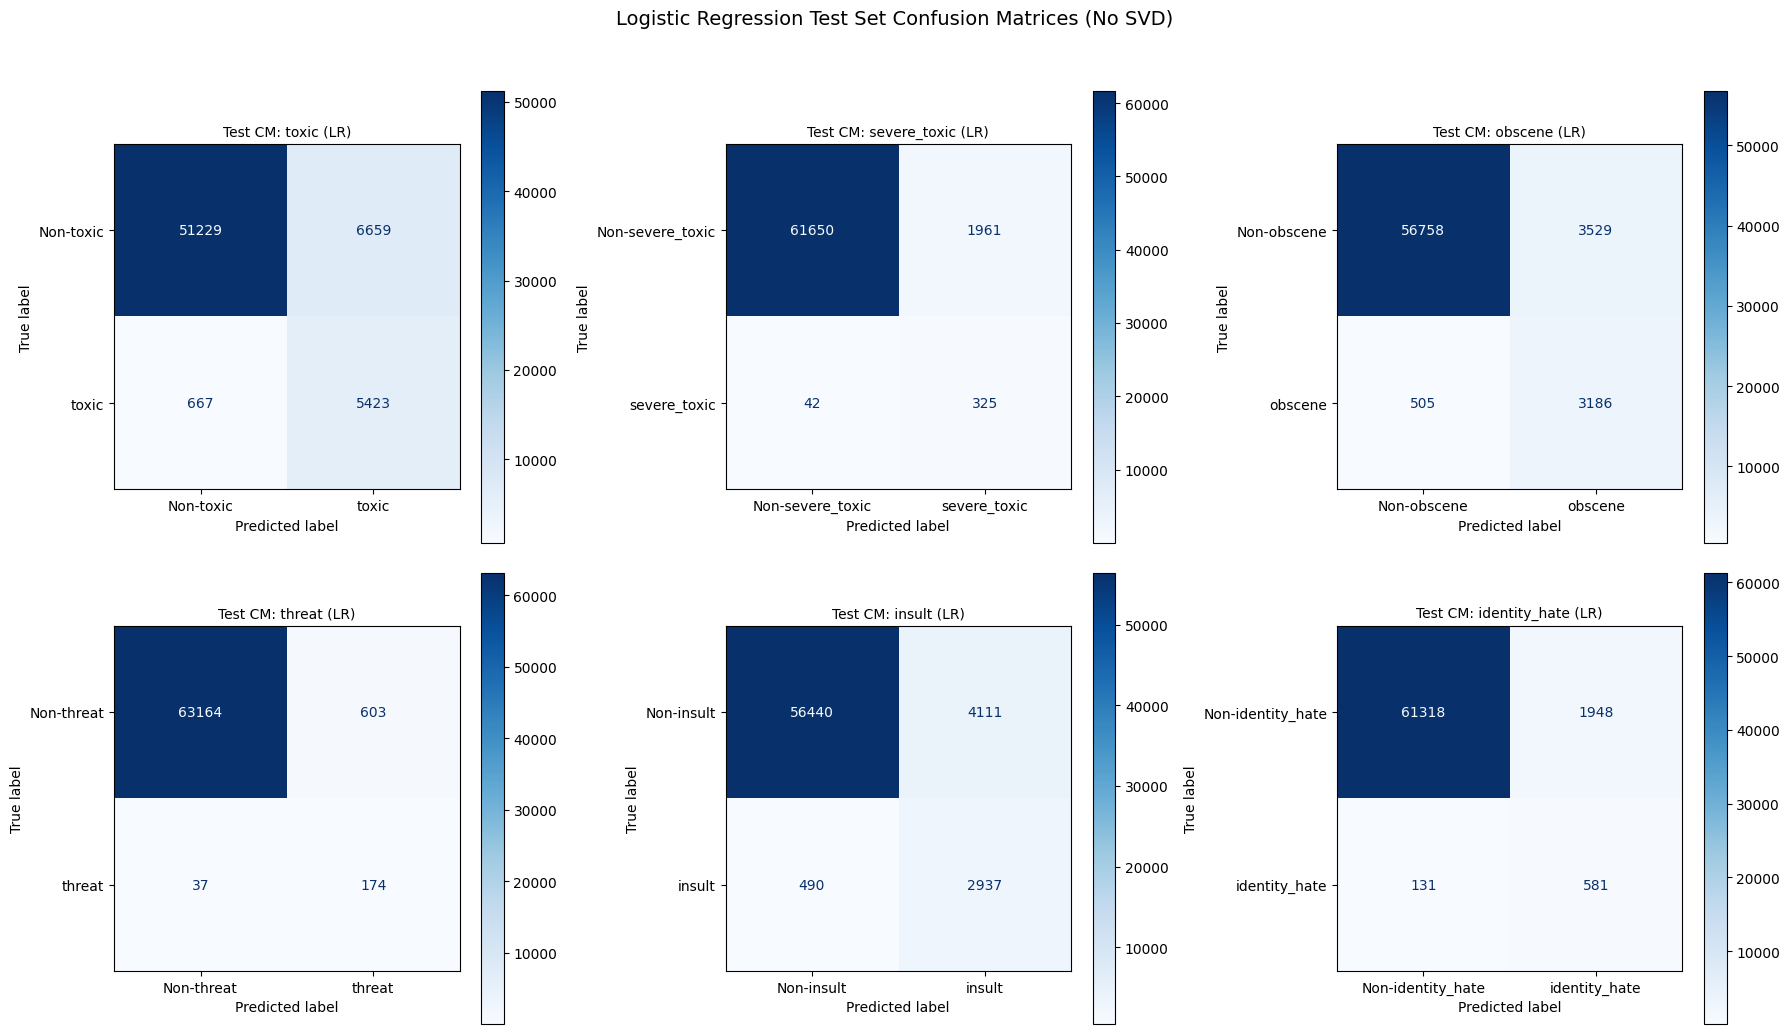


Confusion matrix generation finished.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

print("\n--- Generating Confusion Matrices for Logistic Regression (No SVD) ---")

# Define directories (optional)
plots_dir = 'jigsaw_data/plots'
os.makedirs(plots_dir, exist_ok=True)

# --- Re-run predictions and store models (if not already stored) ---
# If the previous script didn't store models, we need to retrain/predict
# For simplicity, we'll recalculate predictions here.
# Ideally, store the model object in the `results` list or a separate dict in the previous cell.

models_trained_dict_lr = {} # Store models if retraining is needed
y_preds_binary = {} # Store binary predictions for each category

print("Re-calculating predictions for confusion matrix generation...")
for category in CATEGORIES:
    print(f"  Processing category: {category}")
    y_train = train_df[category]

    # Check if model needs retraining or just load if saved elsewhere
    # For this example, we retrain briefly.
    # In a real workflow, load the saved model if possible.
    temp_model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, class_weight='balanced')
    temp_model.fit(X_train_tfidf, y_train)
    models_trained_dict_lr[category] = temp_model # Store the model

    # Predict binary labels needed for CM
    y_pred = temp_model.predict(X_test_tfidf)
    y_preds_binary[category] = y_pred

print("Predictions recalculated.")

# --- Generate Confusion Matrices ---
try:
    # Ensure y_test_all is defined (it was defined inside the loop in the previous script)
    # We need the full test labels DataFrame for filtering
    y_test_all_df = test_combined_df[CATEGORIES] # Get all label columns

    fig_cm, axes_cm = plt.subplots(2, 3, figsize=(18, 11)) # Create figure and axes
    axes_cm = axes_cm.ravel() # Flatten grid
    plot_generated_cm = False

    for idx, label in enumerate(CATEGORIES):
        print(f"  Generating CM for '{label}'...")
        # Get true labels and predictions for this category
        y_test_all_cat = y_test_all_df[label]
        y_pred_cat = y_preds_binary.get(label) # Get predictions calculated above

        if y_pred_cat is None:
            print(f"    Skipping CM: Predictions not found for '{label}'.")
            axes_cm[idx].text(0.5, 0.5, 'Pred Missing', ha='center', va='center', fontsize=9)
            axes_cm[idx].set_title(f'Test CM: {label} (LR)', fontsize=10)
            continue # Skip to next category

        # Filter out test samples with label -1 for this specific category
        valid_test_indices = (y_test_all_cat != -1)

        if valid_test_indices.sum() == 0:
            print(f"    Skipping CM: No valid test labels (all were -1) for '{label}'.")
            axes_cm[idx].text(0.5, 0.5, 'No Valid Labels', ha='center', va='center', fontsize=9)
            axes_cm[idx].set_title(f'Test CM: {label} (LR)', fontsize=10)
            continue # Skip to next category

        y_test_filtered = y_test_all_cat[valid_test_indices]
        y_pred_filtered = y_pred_cat[valid_test_indices]

        # Check if there's data left after filtering
        if len(y_test_filtered) > 0:
            try:
                # Calculate confusion matrix
                cm = confusion_matrix(y_test_filtered, y_pred_filtered)

                # Plot using ConfusionMatrixDisplay
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Non-{label}', label])
                disp.plot(ax=axes_cm[idx], cmap='Blues', values_format='d') # Use Blues cmap
                axes_cm[idx].set_title(f"Test CM: {label} (LR)", fontsize=10)
                plot_generated_cm = True

            except Exception as e_cm:
                print(f"    Error generating CM plot for '{label}': {e_cm}")
                axes_cm[idx].text(0.5, 0.5, 'Plot Error', ha='center', va='center', fontsize=9, color='red')
                axes_cm[idx].set_title(f'Test CM: {label} (LR) - Error', fontsize=10)
        else:
            # This case shouldn't be hit due to the earlier check, but added for safety
            print(f"    Skipping CM: No data after filtering for '{label}'.")
            axes_cm[idx].text(0.5, 0.5, 'Filtered Empty', ha='center', va='center', fontsize=9)
            axes_cm[idx].set_title(f'Test CM: {label} (LR)', fontsize=10)


    # Finalize and save/show the plot if at least one matrix was generated
    if plot_generated_cm:
        fig_cm.suptitle("Logistic Regression Test Set Confusion Matrices (No SVD)", fontsize=14)
        fig_cm.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
        cm_save_path = os.path.join(plots_dir, 'test_confusion_matrices_lr_nosvd.png') # Specific name
        plt.savefig(cm_save_path, dpi=300)
        print(f"\nConfusion matrices plot saved to {cm_save_path}")
        plt.show() # Display the plot inline
    else:
        print("\nNo confusion matrices were generated.")

    plt.close(fig_cm) # Close the figure object

except NameError as ne:
     print(f"\nNameError: A required variable/DataFrame is missing: {ne}")
     print("Please ensure the previous script defining train_df, X_train_tfidf, X_test_tfidf, test_combined_df ran successfully.")
except FileNotFoundError as fnfe:
     print(f"\nFileNotFoundError: {fnfe}")
     print("Ensure the required data CSV files are present in the specified DATA_DIR.")
except Exception as e:
    print(f"\nAn unexpected error occurred during confusion matrix generation: {e}")
    # Attempt to close the figure if it exists
    if 'fig_cm' in locals():
        plt.close(fig_cm)

print("\nConfusion matrix generation finished.")


--- Generating Performance Comparison Chart for Logistic Regression (No SVD) ---

Using the following summary data for plotting:
        Category  Test_ROC_AUC_LR_NoSVD  Test_Accuracy_LR_NoSVD
0          toxic               0.956200                0.885492
1   severe_toxic               0.980801                0.968692
2        obscene               0.971179                0.936947
3         threat               0.990138                0.989997
4         insult               0.966338                0.928085
5  identity_hate               0.976157                0.967504

Performance comparison chart saved to jigsaw_data/plots/performance_comparison_lr_nosvd.png


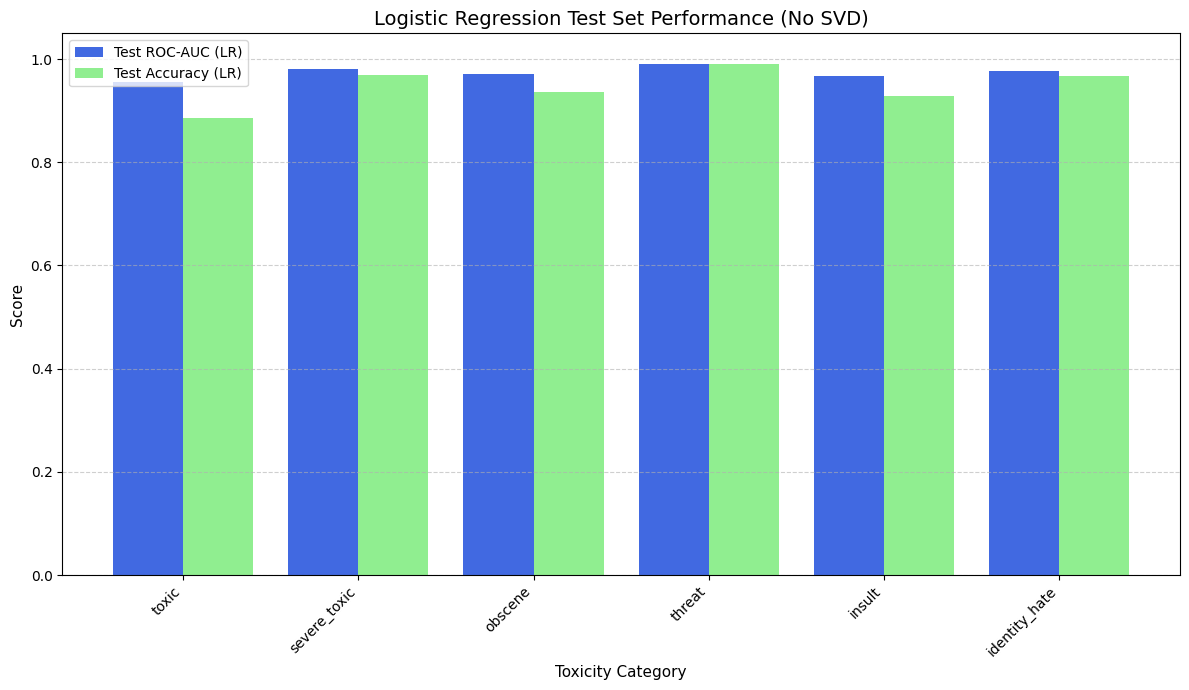


Chart generation for Logistic Regression (No SVD) finished.


In [ ]:
# --- CELL TO GENERATE PERFORMANCE COMPARISON CHART FOR LOGISTIC REGRESSION (NO SVD) ---
# Assumes the previous cell (the one training LR No SVD and calculating metrics)
# ran successfully and created the DataFrame 'results_df'.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print("\n--- Generating Performance Comparison Chart for Logistic Regression (No SVD) ---")

# Define directories (optional)
results_dir = 'jigsaw_data/results'
plots_dir = 'jigsaw_data/plots'
os.makedirs(results_dir, exist_ok=True) # Ensure directory exists
os.makedirs(plots_dir, exist_ok=True) # Ensure directory exists

# Check if the required results DataFrame exists from the previous step
if 'results_df' in locals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    try:
        # Rename columns for clarity if needed (adjust if your previous cell named them differently)
        summary_df_lr_nosvd = results_df.rename(columns={
            'Test_ROC_AUC': 'Test_ROC_AUC_LR_NoSVD',
            'Test_Accuracy': 'Test_Accuracy_LR_NoSVD',
            'Category': 'Category' # Keep Category name standard
        })
        # Select only the columns needed for the chart
        summary_df_lr_nosvd = summary_df_lr_nosvd[['Category', 'Test_ROC_AUC_LR_NoSVD', 'Test_Accuracy_LR_NoSVD']]

        print("\nUsing the following summary data for plotting:")
        print(summary_df_lr_nosvd.to_string())

        # Check if there are metrics to plot
        metrics_present = ('Test_ROC_AUC_LR_NoSVD' in summary_df_lr_nosvd.columns and not summary_df_lr_nosvd['Test_ROC_AUC_LR_NoSVD'].isnull().all()) or \
                          ('Test_Accuracy_LR_NoSVD' in summary_df_lr_nosvd.columns and not summary_df_lr_nosvd['Test_Accuracy_LR_NoSVD'].isnull().all())

        if not metrics_present:
             print("\nSkipping chart generation: No valid scores available after processing.")
        else:
            # --- Plotting ---
            fig_bar_lr, ax_bar_lr = plt.subplots(figsize=(12, 7)) # Use unique figure/axes names
            toxicity_columns = summary_df_lr_nosvd['Category'].tolist() # Get categories from df

            # Determine number of metrics actually present with non-NaN values to plot
            plot_cols = []
            if 'Test_ROC_AUC_LR_NoSVD' in summary_df_lr_nosvd.columns and summary_df_lr_nosvd['Test_ROC_AUC_LR_NoSVD'].notna().any():
                plot_cols.append('Test_ROC_AUC_LR_NoSVD')
            if 'Test_Accuracy_LR_NoSVD' in summary_df_lr_nosvd.columns and summary_df_lr_nosvd['Test_Accuracy_LR_NoSVD'].notna().any():
                plot_cols.append('Test_Accuracy_LR_NoSVD')

            num_metrics = len(plot_cols)
            if num_metrics == 0:
                 print("\nNo valid metric columns found to plot.")
            else:
                bar_width = 0.8 / num_metrics
                index = np.arange(len(toxicity_columns))
                offset = - (num_metrics - 1) * bar_width / 2 if num_metrics > 1 else 0

                colors = ['royalblue', 'lightgreen'] # Colors for LR No SVD chart
                metrics_plotted = 0

                # Plot Test ROC AUC if available and has valid data
                if 'Test_ROC_AUC_LR_NoSVD' in plot_cols:
                    ax_bar_lr.bar(index + offset + metrics_plotted * bar_width, summary_df_lr_nosvd['Test_ROC_AUC_LR_NoSVD'].fillna(0), bar_width, label='Test ROC-AUC (LR)', color=colors[metrics_plotted % len(colors)])
                    metrics_plotted += 1

                # Plot Test Accuracy if available and has valid data
                if 'Test_Accuracy_LR_NoSVD' in plot_cols:
                    ax_bar_lr.bar(index + offset + metrics_plotted * bar_width, summary_df_lr_nosvd['Test_Accuracy_LR_NoSVD'].fillna(0), bar_width, label='Test Accuracy (LR)', color=colors[metrics_plotted % len(colors)])
                    metrics_plotted += 1

                # Chart Formatting
                ax_bar_lr.set_xlabel('Toxicity Category', fontsize=11)
                ax_bar_lr.set_ylabel('Score', fontsize=11)
                ax_bar_lr.set_title('Logistic Regression Test Set Performance (No SVD)', fontsize=14)
                ax_bar_lr.set_xticks(index)
                ax_bar_lr.set_xticklabels(toxicity_columns, rotation=45, ha="right", fontsize=10)
                ax_bar_lr.set_ylim(0, 1.05)
                ax_bar_lr.legend(fontsize=10)
                ax_bar_lr.grid(True, axis='y', linestyle='--', alpha=0.6)
                fig_bar_lr.tight_layout()

                # Save and Show
                chart_save_path_lr = os.path.join(plots_dir, 'performance_comparison_lr_nosvd.png') # Specific name
                plt.savefig(chart_save_path_lr, dpi=300)
                print(f"\nPerformance comparison chart saved to {chart_save_path_lr}")
                plt.show()
                plt.close(fig_bar_lr) # Close the specific figure
                # ------------------

    except Exception as e:
        print(f"\nError generating performance chart for Logistic Regression (No SVD): {e}")
        # Attempt to close the figure if it exists
        if 'fig_bar_lr' in locals():
            plt.close(fig_bar_lr)

else:
    print("\nSkipping Performance Chart generation: Results DataFrame 'results_df' not found or empty.")
    print("Please ensure the previous Logistic Regression (No SVD) evaluation cell ran successfully.")

print("\nChart generation for Logistic Regression (No SVD) finished.")

## **With** SVD (Dimensionality Reduction)

### Dimensionality Reduction using SVD

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

print("--- Starting Dimensionality Reduction with SVD ---")

# Set SVD configuration
N_COMPONENTS_SVD = 120  # hyperparameter
RANDOM_STATE = 42 # hyperparameter

# Load Data
print("Loading preprocessed features...")
X_train_final = sparse.load_npz(os.path.join(DATA_DIR, 'X_train_final.npz'))
X_test_final = sparse.load_npz(os.path.join(DATA_DIR, 'X_test_final.npz'))

print(f"Train final features shape: {X_train_final.shape}")
print(f"Test final features shape: {X_test_final.shape}")

# Apply SVD
print(f"Applying Truncated SVD with {N_COMPONENTS_SVD} components...")

svd = TruncatedSVD(n_components=N_COMPONENTS_SVD, random_state=RANDOM_STATE)

# Fit SVD on training data and transform both train and test sets
X_train_svd = svd.fit_transform(X_train_final)
X_test_svd = svd.transform(X_test_final)

print(f"SVD transformation complete.")
print(f"Shape after SVD (Train): {X_train_svd.shape}")
print(f"Shape after SVD (Test): {X_test_svd.shape}")

sparse.save_npz(os.path.join(DATA_DIR, 'X_train_svd.npz'), sparse.csr_matrix(X_train_svd))
sparse.save_npz(os.path.join(DATA_DIR, 'X_test_svd.npz'), sparse.csr_matrix(X_test_svd))

print(f"SVD reduced features saved: X_train_svd.npz, X_test_svd.npz")

--- Starting Dimensionality Reduction with SVD ---
Loading preprocessed features...
Train final features shape: (159571, 40007)
Test final features shape: (153164, 40007)
Applying Truncated SVD with 120 components...
SVD transformation complete.
Shape after SVD (Train): (159571, 120)
Shape after SVD (Test): (153164, 120)
SVD reduced features saved: X_train_svd.npz, X_test_svd.npz


### Training & Evaluation

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy import sparse

print("--- Starting Logistic Regression (WITH SVD) Training & Evaluation ---")

OUTPUT_CSV = os.path.join(RESULTS_DIR, 'performance_summary_lr_svd.csv')
# Ensure output directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# Target categories
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# --- 1. Load Data ---
print("Loading data...")
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_labels_df = pd.read_csv(os.path.join(DATA_DIR, 'test_labels.csv'))

# Combine test data with labels
test_combined_df = pd.merge(test_df, test_labels_df, on='id')
print("Data loaded successfully.")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_combined_df.shape}")

# --- 2. Load SVD Reduced Features ---
print("\nLoading SVD reduced features...")

# Load the SVD reduced feature matrices
X_train_svd = sparse.load_npz(os.path.join(DATA_DIR, 'X_train_svd.npz'))
X_test_svd = sparse.load_npz(os.path.join(DATA_DIR, 'X_test_svd.npz'))

print(f"Train SVD features shape: {X_train_svd.shape}")
print(f"Test SVD features shape: {X_test_svd.shape}")

# --- 3. Model Training & Evaluation per Category ---
results = []

print("\n--- Training and Evaluating Logistic Regression for each category (WITH SVD) ---")

for category in CATEGORIES:
    print(f"\nProcessing category: {category}")

    y_train = train_df[category]
    y_test_all = test_combined_df[category]

    # Train model
    start_train_time = time.time()
    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, class_weight='balanced')
    model.fit(X_train_svd, y_train)
    end_train_time = time.time()
    train_time = end_train_time - start_train_time
    print(f"Training finished in {train_time:.2f}s")

    # Predict
    start_pred_time = time.time()
    y_pred_proba = model.predict_proba(X_test_svd)[:, 1]
    y_pred = model.predict(X_test_svd)
    end_pred_time = time.time()
    pred_time = end_pred_time - start_pred_time
    print(f"Prediction finished in {pred_time:.2f}s")

    # Filter out test samples with label -1
    valid_test_indices = y_test_all != -1
    y_test_filtered = y_test_all[valid_test_indices]
    y_pred_proba_filtered = y_pred_proba[valid_test_indices]
    y_pred_filtered = y_pred[valid_test_indices]

    test_roc_auc = -1.0
    test_accuracy = -1.0

    if len(y_test_filtered) > 0 and len(np.unique(y_test_filtered)) > 1:
        try:
            test_roc_auc = roc_auc_score(y_test_filtered, y_pred_proba_filtered)
            test_accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
            print(f"Test ROC AUC: {test_roc_auc:.4f}")
            print(f"Test Accuracy: {test_accuracy:.4f}")
        except ValueError as ve:
            print(f"Could not calculate ROC AUC for {category}: {ve}")
        except Exception as e:
            print(f"An error occurred during evaluation for {category}: {e}")
    elif len(y_test_filtered) > 0:
        try:
            test_accuracy = accuracy_score(y_test_filtered, y_pred_filtered)
            print("Only one class present in valid test labels. ROC AUC is not defined.")
            print(f"Test Accuracy: {test_accuracy:.4f}")
        except Exception as e:
            print(f"An error occurred during accuracy calculation for {category}: {e}")
    else:
        print("No valid test labels (all were -1) for this category.")

    # Store results
    results.append({
        'Category': category,
        'Test_ROC_AUC': test_roc_auc,
        'Test_Accuracy': test_accuracy,
        'Train_Time_Seconds': train_time,
        'Prediction_Time_Seconds': pred_time,
        'Model_Type': 'LogisticRegression_SVD',
        'Feature_Type': f'SVD_{N_COMPONENTS_SVD}',
        'Num_Features': X_train_svd.shape[1]
    })

# --- Summarize and Save Results ---
print("\n--- Overall Results Summary (WITH SVD) ---")
results_df = pd.DataFrame(results)
print(results_df.to_string(float_format='%.4f'))

# Save results to CSV
results_df.to_csv(OUTPUT_CSV, index=False, float_format='%.4f')
print(f"\nPerformance summary saved to: {OUTPUT_CSV}")
print("\n--- Logistic Regression (WITH SVD) Process Finished ---")

--- Starting Logistic Regression (WITH SVD) Training & Evaluation ---
Loading data...
Data loaded successfully.
Train shape: (159571, 8)
Test shape: (153164, 8)

Loading SVD reduced features...
Train SVD features shape: (159571, 120)
Test SVD features shape: (153164, 120)

--- Training and Evaluating Logistic Regression for each category (WITH SVD) ---

Processing category: toxic


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 51.36s
Prediction finished in 0.10s
Test ROC AUC: 0.8696
Test Accuracy: 0.8312

Processing category: severe_toxic


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 40.56s
Prediction finished in 0.09s
Test ROC AUC: 0.9250
Test Accuracy: 0.8805

Processing category: obscene


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 44.45s
Prediction finished in 0.09s
Test ROC AUC: 0.9021
Test Accuracy: 0.8998

Processing category: threat


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 37.03s
Prediction finished in 0.09s
Test ROC AUC: 0.9660
Test Accuracy: 0.9128

Processing category: insult


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training finished in 48.76s
Prediction finished in 0.09s
Test ROC AUC: 0.8880
Test Accuracy: 0.8713

Processing category: identity_hate
Training finished in 46.53s
Prediction finished in 0.09s
Test ROC AUC: 0.9079
Test Accuracy: 0.8600

--- Overall Results Summary (WITH SVD) ---
        Category  Test_ROC_AUC  Test_Accuracy  Train_Time_Seconds  Prediction_Time_Seconds              Model_Type Feature_Type  Num_Features
0          toxic        0.8696         0.8312             51.3577                   0.0997  LogisticRegression_SVD      SVD_120           120
1   severe_toxic        0.9250         0.8805             40.5587                   0.0898  LogisticRegression_SVD      SVD_120           120
2        obscene        0.9021         0.8998             44.4514                   0.0928  LogisticRegression_SVD      SVD_120           120
3         threat        0.9660         0.9128             37.0300                   0.0871  LogisticRegression_SVD      SVD_120           120
4         

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Analytics


--- Generating Confusion Matrices for Logistic Regression (WITH SVD) ---
Re-calculating predictions for SVD confusion matrix generation...
  Processing category: toxic
  Processing category: severe_toxic
  Processing category: obscene
  Processing category: threat
  Processing category: insult
  Processing category: identity_hate
Predictions recalculated.
  Generating CM for 'toxic' (SVD)...
  Generating CM for 'severe_toxic' (SVD)...
  Generating CM for 'obscene' (SVD)...
  Generating CM for 'threat' (SVD)...
  Generating CM for 'insult' (SVD)...
  Generating CM for 'identity_hate' (SVD)...

Confusion matrices plot (SVD) saved to /content/jigsaw_data/plots/test_confusion_matrices_lr_svd.png


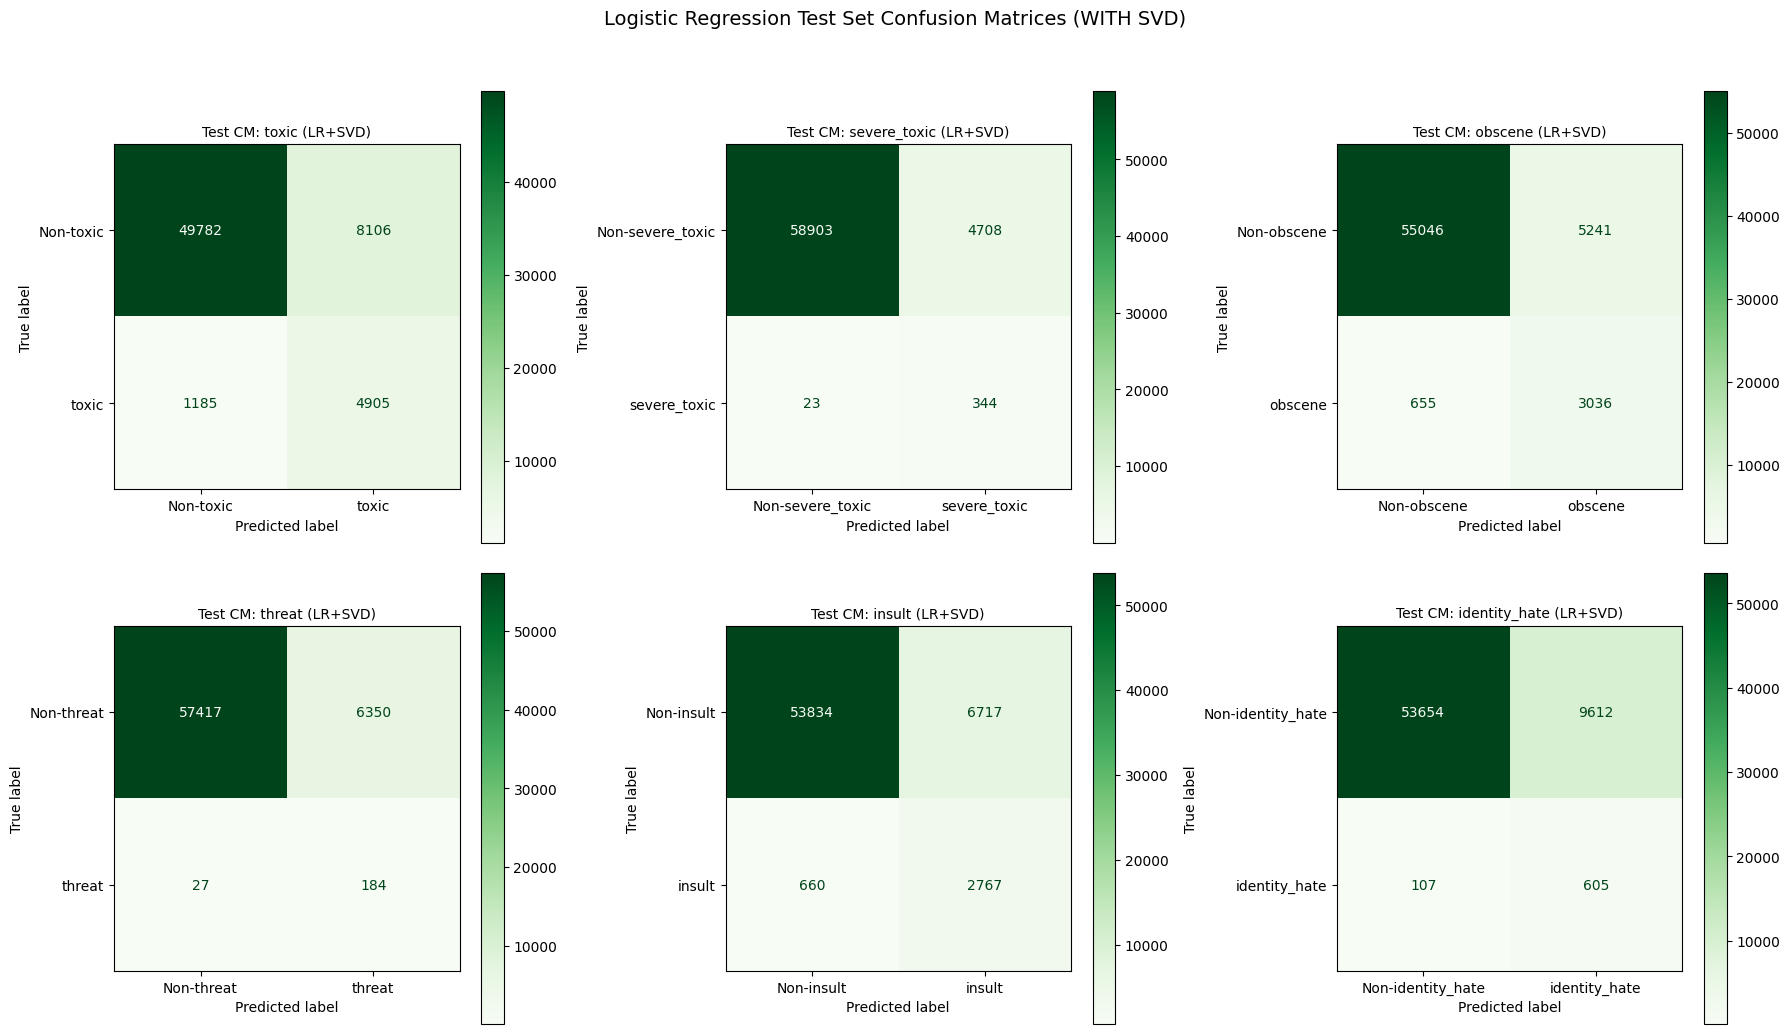


Confusion matrix generation for LR SVD finished.


In [ ]:
# --- CONFUSION MATRIX PLOT FOR LOGISTIC REGRESSION (WITH SVD) ---
# Assumes the previous cell (LR + SVD Training & Evaluation) ran successfully.
# Requires: CATEGORIES, test_combined_df, X_test_svd, train_df, X_train_svd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression

print("\n--- Generating Confusion Matrices for Logistic Regression (WITH SVD) ---")

# Define directories (these should match the previous cell)
DATA_DIR = '/content/jigsaw_data/' # Make sure this is correct
plots_dir = os.path.join(DATA_DIR, 'plots') # Save plots inside jigsaw_data/plots
os.makedirs(plots_dir, exist_ok=True)

# --- Check if necessary variables exist from previous cell ---
required_vars = ['CATEGORIES', 'test_combined_df', 'X_test_svd', 'train_df', 'X_train_svd']
vars_exist = True
for var in required_vars:
    if var not in locals():
        print(f"Error: Required variable '{var}' not found. Cannot proceed.")
        print("Please ensure the previous cell (LR SVD Training/Evaluation) ran successfully.")
        vars_exist = False
        break

# --- Proceed only if all required variables are present ---
if vars_exist:
    # --- Re-calculate Predictions (as models weren't stored explicitly) ---
    y_preds_binary_svd = {} # Dictionary to hold binary predictions

    print("Re-calculating predictions for SVD confusion matrix generation...")
    try:
        for category in CATEGORIES:
            print(f"  Processing category: {category}")
            current_y_train = train_df[category]

            # Retrain model briefly using the same parameters
            # Ideally, load saved models if they were saved in the previous step
            temp_model = LogisticRegression(solver='liblinear', C=1.0, random_state=42, class_weight='balanced')
            temp_model.fit(X_train_svd, current_y_train) # Train on SVD features

            # Predict binary labels needed for CM using SVD test features
            y_pred = temp_model.predict(X_test_svd)
            y_preds_binary_svd[category] = y_pred

        print("Predictions recalculated.")

        # --- Generate Confusion Matrices ---
        y_test_all_df = test_combined_df[CATEGORIES] # Get all true label columns

        fig_cm_svd, axes_cm_svd = plt.subplots(2, 3, figsize=(18, 11)) # Create figure and axes
        axes_cm_svd = axes_cm_svd.ravel() # Flatten grid
        plot_generated_cm_svd = False

        for idx, label in enumerate(CATEGORIES):
            print(f"  Generating CM for '{label}' (SVD)...")
            y_test_all_cat = y_test_all_df[label]
            y_pred_cat = y_preds_binary_svd.get(label)

            if y_pred_cat is None:
                print(f"    Skipping CM: Predictions missing for '{label}'.")
                axes_cm_svd[idx].text(0.5, 0.5, 'Pred Missing', ha='center', va='center', fontsize=9)
                axes_cm_svd[idx].set_title(f'Test CM: {label} (LR+SVD)', fontsize=10)
                continue

            # Filter out test samples with label -1
            valid_test_indices = (y_test_all_cat != -1)

            if valid_test_indices.sum() == 0:
                print(f"    Skipping CM: No valid test labels for '{label}'.")
                axes_cm_svd[idx].text(0.5, 0.5, 'No Valid Labels', ha='center', va='center', fontsize=9)
                axes_cm_svd[idx].set_title(f'Test CM: {label} (LR+SVD)', fontsize=10)
                continue

            y_test_filtered = y_test_all_cat[valid_test_indices]
            y_pred_filtered = y_pred_cat[valid_test_indices]

            if len(y_test_filtered) > 0:
                try:
                    cm = confusion_matrix(y_test_filtered, y_pred_filtered)
                    disp = ConfusionMatrixDisplay(cm, display_labels=[f'Non-{label}', label])
                    disp.plot(ax=axes_cm_svd[idx], cmap='Greens', values_format='d')
                    axes_cm_svd[idx].set_title(f"Test CM: {label} (LR+SVD)", fontsize=10)
                    plot_generated_cm_svd = True
                except Exception as e_cm:
                    print(f"    Error generating CM plot for '{label}' (SVD): {e_cm}")
                    axes_cm_svd[idx].text(0.5, 0.5, 'Plot Error', ha='center', va='center', fontsize=9, color='red')
                    axes_cm_svd[idx].set_title(f'Test CM: {label} (LR+SVD) - Error', fontsize=10)
            else:
                print(f"    Skipping CM: No data after filtering for '{label}'.")
                axes_cm_svd[idx].text(0.5, 0.5, 'Filtered Empty', ha='center', va='center', fontsize=9)
                axes_cm_svd[idx].set_title(f'Test CM: {label} (LR+SVD)', fontsize=10)

        # Finalize and save/show the plot
        if plot_generated_cm_svd:
            fig_cm_svd.suptitle("Logistic Regression Test Set Confusion Matrices (WITH SVD)", fontsize=14)
            fig_cm_svd.tight_layout(rect=[0, 0.03, 1, 0.95])
            cm_save_path_svd = os.path.join(plots_dir, 'test_confusion_matrices_lr_svd.png') # Specific name
            plt.savefig(cm_save_path_svd, dpi=300)
            print(f"\nConfusion matrices plot (SVD) saved to {cm_save_path_svd}")
            plt.show()
        else:
            print("\nNo SVD confusion matrices were generated.")

        plt.close(fig_cm_svd) # Close the figure object

    except KeyError as ke:
         print(f"\nKeyError: Required column not found in DataFrame: {ke}")
         print("Please check the column names in train_df and test_combined_df.")
    except NameError as ne:
         print(f"\nNameError: A required variable is missing: {ne}")
         print("Ensure the previous cell (LR SVD Training/Evaluation) ran successfully.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during confusion matrix generation: {e}")
        if 'fig_cm_svd' in locals(): # Attempt to close figure if error occurred after creation
            plt.close(fig_cm_svd)

print("\nConfusion matrix generation for LR SVD finished.")


--- Generating Performance Comparison Chart for Logistic Regression (WITH SVD) ---

Using the following summary data for plotting:
        Category  Test_ROC_AUC_LR_SVD  Test_Accuracy_LR_SVD
0          toxic             0.914501              0.854778
1   severe_toxic             0.976327              0.926053
2        obscene             0.946838              0.907843
3         threat             0.952341              0.900325
4         insult             0.930281              0.884695
5  identity_hate             0.921489              0.848088

Performance comparison chart saved to jigsaw_data/plots/performance_comparison_lr_svd.png


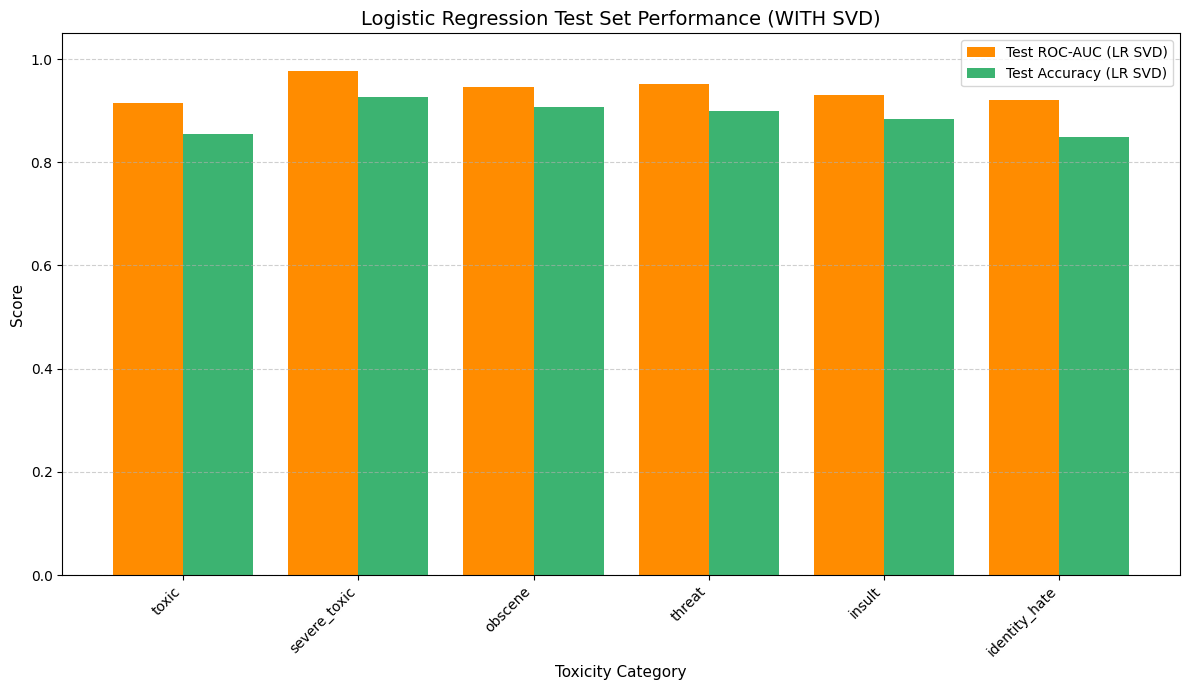


Chart generation for Logistic Regression (SVD) finished.


In [ ]:
# --- CELL TO GENERATE PERFORMANCE COMPARISON CHART FOR LOGISTIC REGRESSION (WITH SVD) ---
# Assumes the previous cell (LR + SVD Training & Evaluation) ran successfully
# and created the DataFrame 'results_df'.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print("\n--- Generating Performance Comparison Chart for Logistic Regression (WITH SVD) ---")

# Define directories (these should match the previous cell)
plots_dir = 'jigsaw_data/plots'
os.makedirs(plots_dir, exist_ok=True) # Ensure directory exists

# Check if the required results DataFrame exists from the previous step
if 'results_df' in locals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    try:
        # Use the results_df directly as it already contains the required columns
        summary_df_lr_svd = results_df.copy()

        # --- Rename columns for clarity in the chart legend ---
        summary_df_lr_svd = summary_df_lr_svd.rename(columns={
            'Test_ROC_AUC': 'Test_ROC_AUC_LR_SVD',
            'Test_Accuracy': 'Test_Accuracy_LR_SVD'
        })

        print("\nUsing the following summary data for plotting:")
        # Select and print only relevant columns for clarity
        print(summary_df_lr_svd[['Category', 'Test_ROC_AUC_LR_SVD', 'Test_Accuracy_LR_SVD']].to_string())

        # --- Check if there are metrics to plot ---
        metrics_present = ('Test_ROC_AUC_LR_SVD' in summary_df_lr_svd.columns and not summary_df_lr_svd['Test_ROC_AUC_LR_SVD'].isnull().all()) or \
                          ('Test_Accuracy_LR_SVD' in summary_df_lr_svd.columns and not summary_df_lr_svd['Test_Accuracy_LR_SVD'].isnull().all())

        if not metrics_present:
             print("\nSkipping chart generation: No valid scores available after processing.")
        else:
            # --- Plotting ---
            fig_bar_lr_svd, ax_bar_lr_svd = plt.subplots(figsize=(12, 7)) # Use unique figure/axes names

            # Get categories from the DataFrame
            if 'Category' in summary_df_lr_svd.columns:
                 toxicity_columns = summary_df_lr_svd['Category'].tolist()
            else:
                 # Fallback if 'Category' column name changed somehow
                 print("Warning: 'Category' column not found in results_df. Using default list.")
                 toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


            # Determine number of metrics actually present with non-NaN values to plot
            plot_cols = []
            if 'Test_ROC_AUC_LR_SVD' in summary_df_lr_svd.columns and summary_df_lr_svd['Test_ROC_AUC_LR_SVD'].notna().any():
                plot_cols.append('Test_ROC_AUC_LR_SVD')
            if 'Test_Accuracy_LR_SVD' in summary_df_lr_svd.columns and summary_df_lr_svd['Test_Accuracy_LR_SVD'].notna().any():
                plot_cols.append('Test_Accuracy_LR_SVD')

            num_metrics = len(plot_cols)
            if num_metrics == 0:
                 print("\nNo valid metric columns found to plot.")
            else:
                bar_width = 0.8 / num_metrics
                index = np.arange(len(toxicity_columns))
                offset = - (num_metrics - 1) * bar_width / 2 if num_metrics > 1 else 0

                colors = ['darkorange', 'mediumseagreen'] # Colors for LR SVD chart
                metrics_plotted = 0

                # Plot Test ROC AUC if available and has valid data
                if 'Test_ROC_AUC_LR_SVD' in plot_cols:
                    ax_bar_lr_svd.bar(index + offset + metrics_plotted * bar_width, summary_df_lr_svd['Test_ROC_AUC_LR_SVD'].fillna(0), bar_width, label='Test ROC-AUC (LR SVD)', color=colors[metrics_plotted % len(colors)])
                    metrics_plotted += 1

                # Plot Test Accuracy if available and has valid data
                if 'Test_Accuracy_LR_SVD' in plot_cols:
                    ax_bar_lr_svd.bar(index + offset + metrics_plotted * bar_width, summary_df_lr_svd['Test_Accuracy_LR_SVD'].fillna(0), bar_width, label='Test Accuracy (LR SVD)', color=colors[metrics_plotted % len(colors)])
                    metrics_plotted += 1

                # Chart Formatting
                ax_bar_lr_svd.set_xlabel('Toxicity Category', fontsize=11)
                ax_bar_lr_svd.set_ylabel('Score', fontsize=11)
                ax_bar_lr_svd.set_title('Logistic Regression Test Set Performance (WITH SVD)', fontsize=14)
                ax_bar_lr_svd.set_xticks(index)
                ax_bar_lr_svd.set_xticklabels(toxicity_columns, rotation=45, ha="right", fontsize=10)
                ax_bar_lr_svd.set_ylim(0, 1.05)
                ax_bar_lr_svd.legend(fontsize=10)
                ax_bar_lr_svd.grid(True, axis='y', linestyle='--', alpha=0.6)
                fig_bar_lr_svd.tight_layout()

                # Save and Show
                chart_save_path_lr_svd = os.path.join(plots_dir, 'performance_comparison_lr_svd.png') # Specific name
                plt.savefig(chart_save_path_lr_svd, dpi=300)
                print(f"\nPerformance comparison chart saved to {chart_save_path_lr_svd}")
                plt.show()
                plt.close(fig_bar_lr_svd) # Close the specific figure
                # ------------------

    except Exception as e:
        print(f"\nError generating performance chart for Logistic Regression (SVD): {e}")
        # Attempt to close the figure if it exists
        if 'fig_bar_lr_svd' in locals():
            plt.close(fig_bar_lr_svd)

else:
    print("\nSkipping Performance Chart generation: Results DataFrame 'results_df' not found or empty.")
    print("Please ensure the previous Logistic Regression (WITH SVD) evaluation cell ran successfully.")

print("\nChart generation for Logistic Regression (SVD) finished.")

## Comparing With SVD vs Without SVD

--- Starting Comparison of SVD vs. No SVD Logistic Regression Models ---
Loading No-SVD LR results from: /content/jigsaw_data/results/performance_summary_lr_nosvd.csv

Loading SVD LR results from: /content/jigsaw_data/results/performance_summary_lr_svd.csv

Successfully loaded performance data.

Merging results for comparison...

--- Logistic Regression Performance Comparison Table ---
        Category  Test_ROC_AUC_NoSVD  Test_Accuracy_NoSVD  Test_ROC_AUC_SVD  Test_Accuracy_SVD
0  identity_hate              0.9762               0.9675            0.9215             0.8481
1         insult              0.9663               0.9281            0.9303             0.8847
2        obscene              0.9712               0.9369            0.9468             0.9078
3   severe_toxic              0.9808               0.9687            0.9763             0.9261
4         threat              0.9901               0.9900            0.9523             0.9003
5          toxic              0.9562     

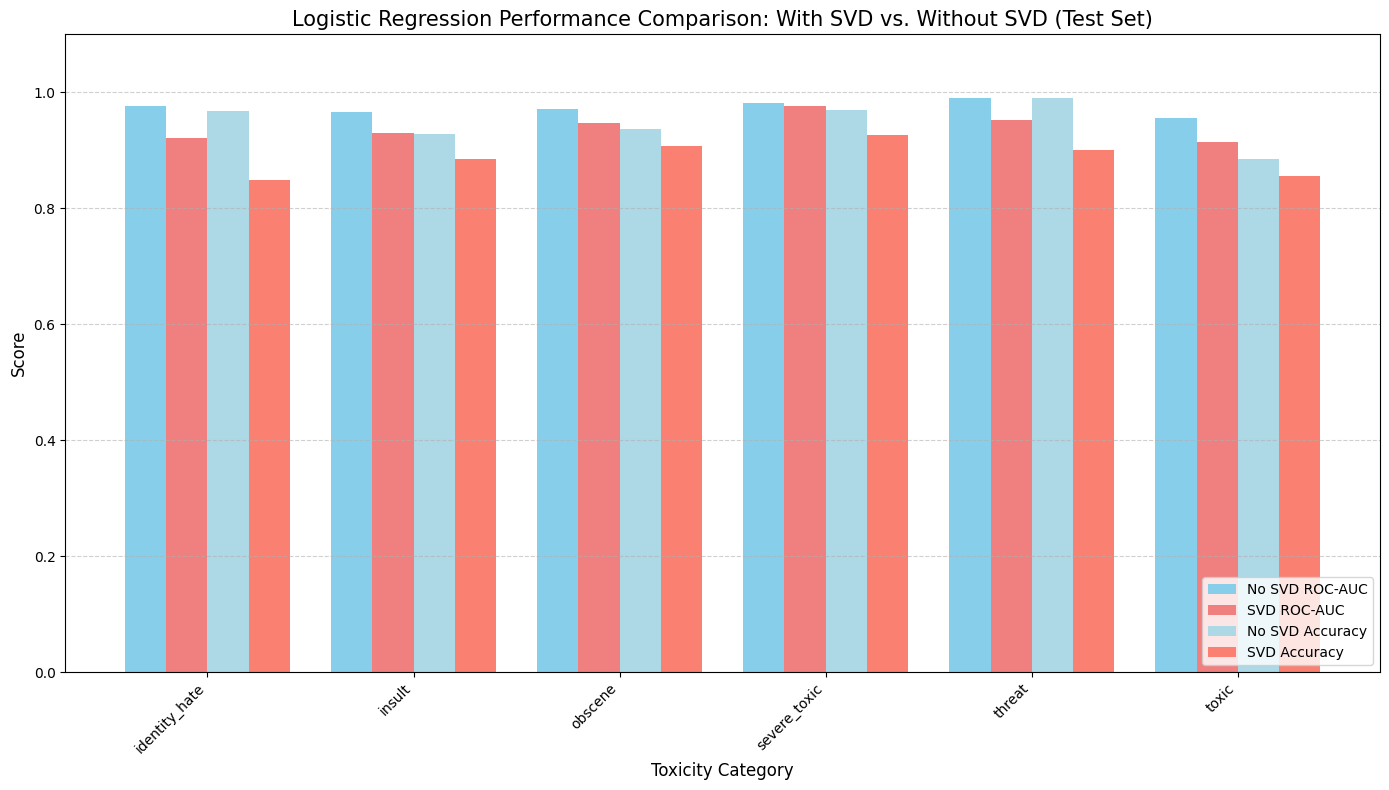

Comparison chart saved to: /content/jigsaw_data/plots/comparison_chart_lr_svd_vs_nosvd.png

--- Logistic Regression Comparison Process Finished ---


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Added import for matplotlib

print("--- Starting Comparison of SVD vs. No SVD Logistic Regression Models ---")

# Define file paths for the results
results_dir = '/content/jigsaw_data/results'
plots_dir = '/content/jigsaw_data/plots'
# --- MODIFIED: Point to Logistic Regression (LR) result files ---
nosvd_results_path = os.path.join(results_dir, 'performance_summary_lr_nosvd.csv')
svd_results_path = os.path.join(results_dir, 'performance_summary_lr_svd.csv')
comparison_output_path = os.path.join(results_dir, 'comparison_summary_lr_svd_vs_nosvd.csv')
comparison_chart_path = os.path.join(plots_dir, 'comparison_chart_lr_svd_vs_nosvd.png')
# --- End Modification ---

# --- Ensure directories exist ---
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
# --- End directory check ---

# --- 1. Load Performance Data ---
try:
    print(f"Loading No-SVD LR results from: {nosvd_results_path}")
    if not os.path.exists(nosvd_results_path):
        # --- MODIFIED: Update error message ---
        raise FileNotFoundError(f"File not found: {nosvd_results_path}. Please run the Logistic Regression 'No SVD' training/evaluation script first.")
        # --- End Modification ---
    df_nosvd = pd.read_csv(nosvd_results_path)
    # Rename columns for clarity before merge (assuming input has 'Test_ROC_AUC', 'Test_Accuracy')
    df_nosvd = df_nosvd.rename(columns={
        'Test_ROC_AUC': 'Test_ROC_AUC_NoSVD',
        'Test_Accuracy': 'Test_Accuracy_NoSVD'
    })
    # Keep only relevant columns for comparison
    df_nosvd = df_nosvd[['Category', 'Test_ROC_AUC_NoSVD', 'Test_Accuracy_NoSVD']]

    print(f"\nLoading SVD LR results from: {svd_results_path}")
    if not os.path.exists(svd_results_path):
         # --- MODIFIED: Update error message ---
         raise FileNotFoundError(f"File not found: {svd_results_path}. Please run the Logistic Regression 'WITH SVD' training/evaluation script first.")
         # --- End Modification ---
    df_svd = pd.read_csv(svd_results_path)
    # Rename columns for clarity before merge (assuming input has 'Test_ROC_AUC', 'Test_Accuracy')
    df_svd = df_svd.rename(columns={
        'Test_ROC_AUC': 'Test_ROC_AUC_SVD',
        'Test_Accuracy': 'Test_Accuracy_SVD'
    })
     # Keep only relevant columns for comparison
    df_svd = df_svd[['Category', 'Test_ROC_AUC_SVD', 'Test_Accuracy_SVD']]


    print("\nSuccessfully loaded performance data.")

except FileNotFoundError as e:
    print(f"\nError loading results files: {e}")
    # --- MODIFIED: Update error message ---
    print("Cannot proceed with comparison. Ensure both Logistic Regression training/evaluation scripts were run successfully.")
    # --- End Modification ---
    # Exit this cell's execution cleanly if files aren't found
    df_comparison = None # Set to None so subsequent steps are skipped
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    df_comparison = None

# --- 2. Merge and Display Comparison Table ---
if 'df_nosvd' in locals() and 'df_svd' in locals(): # Proceed only if loading was successful
    try:
        print("\nMerging results for comparison...")
        # Use outer merge to keep all categories even if one model failed for a specific category
        df_comparison = pd.merge(df_nosvd, df_svd, on='Category', how='outer')

        # --- MODIFIED: Update print statement title ---
        print("\n--- Logistic Regression Performance Comparison Table ---")
        # --- End Modification ---
        print(df_comparison.to_string(float_format='%.4f')) # Display full table

        # Save the comparison table
        df_comparison.to_csv(comparison_output_path, index=False, float_format='%.4f')
        print(f"\nComparison summary saved to: {comparison_output_path}")

    except Exception as e:
        print(f"Error during merging or saving comparison table: {e}")
        df_comparison = None # Prevent chart generation if merge fails

# --- 3. Generate Comparison Bar Chart ---
if df_comparison is not None and not df_comparison.empty: # Proceed only if merge was successful
    try:
        print("\nGenerating comparison bar chart...")
        plt.figure(figsize=(14, 8)) # Wider figure for grouped bars

        categories = df_comparison['Category'].tolist()
        n_categories = len(categories)
        index = np.arange(n_categories)

        # Define metrics to plot and their labels/colors
        # Column names here MUST match the names created in step 1 after renaming
        metrics = {
            'NoSVD_AUC': ('Test_ROC_AUC_NoSVD', 'No SVD ROC-AUC', 'skyblue'),
            'SVD_AUC': ('Test_ROC_AUC_SVD', 'SVD ROC-AUC', 'lightcoral'),
            'NoSVD_Acc': ('Test_Accuracy_NoSVD', 'No SVD Accuracy', 'lightblue'),
            'SVD_Acc': ('Test_Accuracy_SVD', 'SVD Accuracy', 'salmon'),
        }

        # Check which metrics are actually present in the dataframe
        metrics_to_plot = {k: v for k, v in metrics.items() if v[0] in df_comparison.columns}
        num_metric_bars = len(metrics_to_plot)
        bar_width = 0.8 / num_metric_bars if num_metric_bars > 0 else 0.8 # Adjust width based on # bars

        # Calculate offsets for grouped bars
        offsets = np.linspace(-bar_width * (num_metric_bars - 1) / 2,
                              bar_width * (num_metric_bars - 1) / 2,
                              num_metric_bars)

        # Plot bars
        for i, (metric_key, (col_name, label, color)) in enumerate(metrics_to_plot.items()):
            # Fill NaN with 0 for plotting, but NaNs will be visible in the table
            plt.bar(index + offsets[i], df_comparison[col_name].fillna(0), bar_width, label=label, color=color)

        plt.xlabel('Toxicity Category', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        # --- MODIFIED: Update plot title ---
        plt.title('Logistic Regression Performance Comparison: With SVD vs. Without SVD (Test Set)', fontsize=15)
        # --- End Modification ---
        plt.xticks(index, categories, rotation=45, ha="right", fontsize=10)
        plt.ylim(0, 1.1) # Y-axis from 0 to 1.1 for better visibility
        plt.legend(fontsize=10, loc='lower right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()

        # Save and show plot
        plt.savefig(comparison_chart_path, dpi=300)
        plt.show()
        plt.close()
        print(f"Comparison chart saved to: {comparison_chart_path}")

    except Exception as e:
        print(f"Error generating comparison chart: {e}")
else:
    if 'df_comparison' not in locals() or df_comparison is None:
         print("\nSkipping chart generation because data loading failed.")
    elif df_comparison.empty:
        print("\nSkipping chart generation because the comparison dataframe is empty after merge.")


# --- MODIFIED: Update final print statement ---
print("\n--- Logistic Regression Comparison Process Finished ---")
# --- End Modification ---

# XGBoost

## Install & import required libs

In [ ]:
!pip install -q xgboost

import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack, load_npz
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import warnings

## Create output dirs & Load pre-calculated features

In [ ]:
os.makedirs('jigsaw_data/results', exist_ok=True)
os.makedirs('jigsaw_data/plots', exist_ok=True)

def debug_print(label, data):
    print(f"{label}: Shape = {data.shape}, Type = {type(data)}")

## Without SVD

In [ ]:
try:
    print("\nLoading data features...")
    X_train_tfidf = load_npz('jigsaw_data/X_train_tfidf.npz').tocsr()
    X_test_tfidf = load_npz('jigsaw_data/X_test_tfidf.npz').tocsr()
    train_text_features = pd.read_csv('jigsaw_data/train_text_features.csv', dtype=np.float32)
    test_text_features = pd.read_csv('jigsaw_data/test_text_features.csv', dtype=np.float32)
    y_train = pd.read_csv('jigsaw_data/y_train.csv')
    print("Data loading complete.")

    print("\nStandardizing dense features...")
    scaler = StandardScaler(with_mean=False)
    train_text_features_scaled = scaler.fit_transform(train_text_features)
    test_text_features_scaled = scaler.transform(test_text_features)
    print("Dense features standardized.")

    print("\nCombining sparse and dense features...")
    X_train_full = hstack([X_train_tfidf, train_text_features_scaled], format='csc')
    X_test_full = hstack([X_test_tfidf, test_text_features_scaled], format='csc')
    print("Feature combination complete.")

    debug_print("X_train_full", X_train_full)
    debug_print("X_test_full", X_test_full)

except Exception as e:
    print(f"Error during data loading/preparation: {e}")
    raise

# 5. Define model parameters and training function
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

xgb_params = {
    'objective': 'binary:logistic', 'eval_metric': 'auc', 'use_label_encoder': False,
    'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0,
    'tree_method': 'gpu_hist',
    'random_state': 42
}
print(f"\nUsing default XGBoost parameters: {xgb_params}")

def train_model_xgb(label, X_train_data, y_train_data, params):
    try:
        print(f"Training XGBoost for '{label}'...")
        count_neg = y_train_data[label].value_counts().get(0, 0)
        count_pos = y_train_data[label].value_counts().get(1, 0)
        scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1
        params = params.copy()
        params['scale_pos_weight'] = scale_pos_weight
        model = xgb.XGBClassifier(**params)
        model.fit(X_train_data, y_train_data[label])
        print(f"XGBoost model trained for '{label}' successfully.")
        return model
    except Exception as e:
        print(f"GPU training failed for '{label}': {e}, switching to CPU...")
        try:
            params['tree_method'] = 'hist'
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_data, y_train_data[label])
            print(f"CPU training succeeded for '{label}'.")
            return model
        except Exception as e2:
            print(f"Training failed for '{label}' on CPU: {e2}")
            return None

# 6. Train all models
try:
    print("\nStarting training...")
    models_xgb_nosvd = Parallel(n_jobs=-1)(
        delayed(train_model_xgb)(label, X_train_full, y_train, xgb_params) for label in toxicity_columns
    )
    failed_models = [toxicity_columns[i] for i, m in enumerate(models_xgb_nosvd) if m is None]
    if failed_models:
        print(f"Training failed for: {failed_models}")
    else:
        print("All models trained successfully.")
except Exception as e:
    print(f"Training exception: {e}")
    models_xgb_nosvd = [None] * len(toxicity_columns)

models_trained_dict = {label: model for label, model in zip(toxicity_columns, models_xgb_nosvd) if model is not None}

# Save models
if models_trained_dict:
    save_path = 'jigsaw_data/xgboost_models_dict_nosvd.pkl'
    print(f"Saving models to {save_path}...")
    joblib.dump(models_trained_dict, save_path, compress=3)
    print("Models saved successfully.")
else:
    print("No models trained successfully.")

# 7. Evaluate on test set
test_roc_auc_scores_xgb = {}
test_accuracy_scores_xgb = {}

try:
    print("\nLoading test labels...")
    y_test = pd.read_csv('jigsaw_data/y_test.csv')
    test_ids_df = pd.read_csv('jigsaw_data/test.csv', usecols=['id'])

    print("Generating test predictions...")
    y_test_pred_proba_xgb_full = np.zeros((X_test_full.shape[0], len(toxicity_columns)))
    y_test_pred_xgb_full = np.zeros((X_test_full.shape[0], len(toxicity_columns)), dtype=int)

    for i, label in enumerate(toxicity_columns):
        model = models_trained_dict.get(label)
        if model:
            pred_proba = model.predict_proba(X_test_full)[:, 1]
            pred_binary = (pred_proba >= 0.5).astype(int)
            y_test_pred_proba_xgb_full[:, i] = pred_proba
            y_test_pred_xgb_full[:, i] = pred_binary
        else:
            y_test_pred_proba_xgb_full[:, i] = np.nan
            y_test_pred_xgb_full[:, i] = -1

    # Align with test labels
    proba_cols = [f'{col}_proba' for col in toxicity_columns]
    pred_cols = [f'{col}_pred' for col in toxicity_columns]

    df_proba = pd.DataFrame(y_test_pred_proba_xgb_full, columns=proba_cols)
    df_pred = pd.DataFrame(y_test_pred_xgb_full, columns=pred_cols)
    df_proba['id'] = test_ids_df['id']
    df_pred['id'] = test_ids_df['id']

    eval_df_proba = pd.merge(y_test, df_proba, on='id', how='inner')
    eval_df_bin = pd.merge(y_test, df_pred, on='id', how='inner')

    print("Saving aligned predictions...")
    eval_df_proba.to_csv('jigsaw_data/test_predictions_xgb_nosvd_aligned_probas.csv', index=False)
    eval_df_bin.to_csv('jigsaw_data/test_predictions_xgb_nosvd_aligned_preds.csv', index=False)

    print("Calculating evaluation metrics...")
    for label in toxicity_columns:
        y_true = eval_df_bin[label]
        y_pred = eval_df_bin[f'{label}_pred']
        y_score = eval_df_proba[f'{label}_proba']
        try:
            auc = roc_auc_score(y_true, y_score)
            acc = accuracy_score(y_true, y_pred)
            test_roc_auc_scores_xgb[label] = auc
            test_accuracy_scores_xgb[label] = acc
            print(f"{label} - AUC: {auc:.4f}, Accuracy: {acc:.4f}")
        except Exception as e:
            print(f"Error calculating metrics for {label}: {e}")

except Exception as e:
    print(f"Error in evaluation: {e}")


Loading data features...
Data loading complete.

Standardizing dense features...
Dense features standardized.

Combining sparse and dense features...
Feature combination complete.
X_train_full: Shape = (159571, 20007), Type = <class 'scipy.sparse._csc.csc_matrix'>
X_test_full: Shape = (153164, 20007), Type = <class 'scipy.sparse._csc.csc_matrix'>

Using default XGBoost parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'use_label_encoder': False, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'tree_method': 'gpu_hist', 'random_state': 42}

Starting training...
All models trained successfully.
Saving models to jigsaw_data/xgboost_models_dict_nosvd.pkl...
Models saved successfully.

Loading test labels...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:34:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Generating test predictions...
Saving aligned predictions...
Calculating evaluation metrics...
toxic - AUC: 0.9333, Accuracy: 0.8700
severe_toxic - AUC: 0.9719, Accuracy: 0.9587
obscene - AUC: 0.9592, Accuracy: 0.9293
threat - AUC: 0.9793, Accuracy: 0.9878
insult - AUC: 0.9486, Accuracy: 0.9068
identity_hate - AUC: 0.9514, Accuracy: 0.9498



Generating confusion matrices...

Confusion matrices plot saved to jigsaw_data/plots/test_confusion_matrices_xgb_nosvd.png


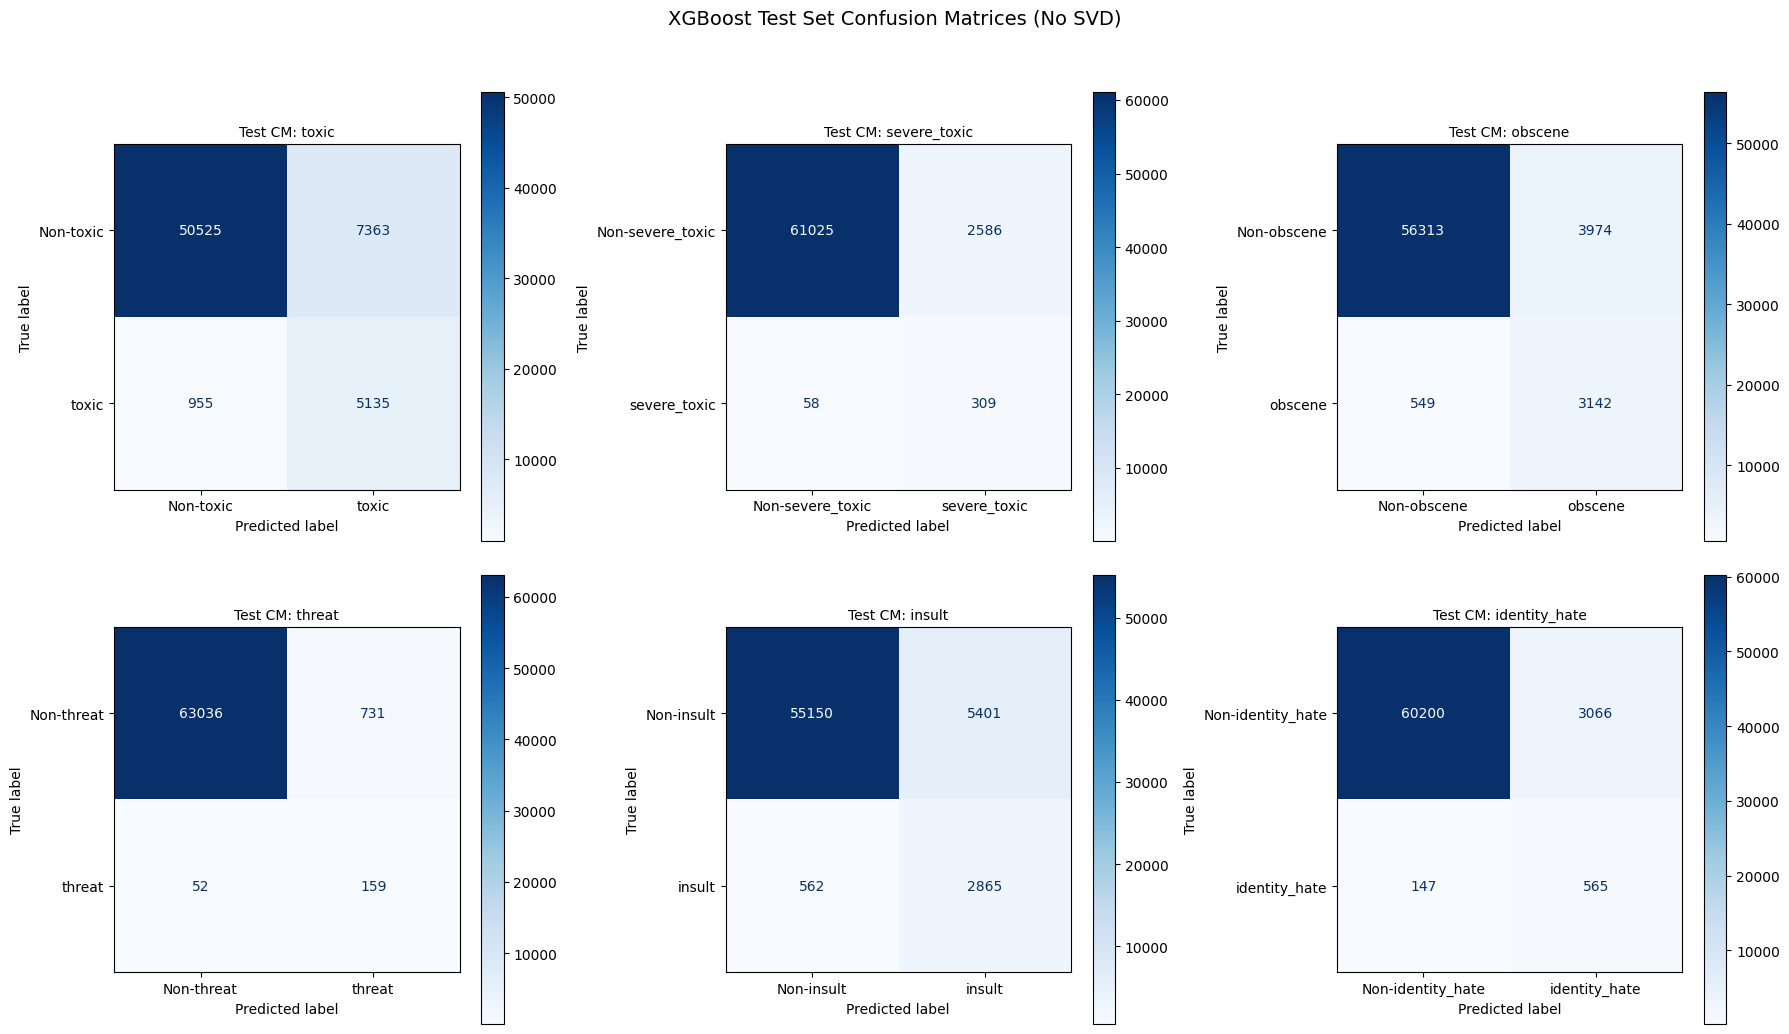


Confusion matrix generation finished.


In [ ]:
# --- Continue in the same cell or add as a new cell ---
# --- Requires variables from the previous cell: ---
# --- toxicity_columns, eval_df_bin ---

# 8. Generate Confusion Matrices

print("\nGenerating confusion matrices...")

# Check if the evaluation DataFrame was created successfully
if 'eval_df_bin' in locals() and not eval_df_bin.empty:
    fig_cm, axes_cm = plt.subplots(2, 3, figsize=(18, 11))
    axes_cm = axes_cm.ravel() # Flatten grid for easy iteration
    plot_generated_cm = False

    for idx, label in enumerate(toxicity_columns):
        # Define column names
        true_col = label
        pred_col = f'{label}_pred' # Column name from the binary prediction DataFrame

        # Check if both columns exist in the evaluation DataFrame
        if true_col in eval_df_bin.columns and pred_col in eval_df_bin.columns:
            try:
                y_true = eval_df_bin[true_col]
                y_pred = eval_df_bin[pred_col]

                # Calculate confusion matrix
                cm = confusion_matrix(y_true, y_pred)

                # Plot using ConfusionMatrixDisplay
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Non-{label}', label])
                disp.plot(ax=axes_cm[idx], cmap='Blues', values_format='d')
                axes_cm[idx].set_title(f"Test CM: {label}", fontsize=10)
                plot_generated_cm = True

            except Exception as e_cm:
                print(f"Error generating CM for '{label}': {e_cm}")
                axes_cm[idx].text(0.5, 0.5, 'Plot Error', ha='center', va='center', fontsize=9)
                axes_cm[idx].set_title(f'Test CM: {label}', fontsize=10)
        else:
            print(f"Skipping CM for '{label}': Columns missing in eval_df_bin.")
            axes_cm[idx].text(0.5, 0.5, 'Data Missing', ha='center', va='center', fontsize=9)
            axes_cm[idx].set_title(f'Test CM: {label}', fontsize=10)

    if plot_generated_cm:
        fig_cm.suptitle("XGBoost Test Set Confusion Matrices (No SVD)", fontsize=14)
        fig_cm.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
        cm_save_path = 'jigsaw_data/plots/test_confusion_matrices_xgb_nosvd.png'
        plt.savefig(cm_save_path, dpi=300)
        print(f"\nConfusion matrices plot saved to {cm_save_path}")
        plt.show() # Display the plot inline
        plt.close(fig_cm) # Close the figure object
    else:
        print("\nNo confusion matrices were generated due to missing data or errors.")
        # plt.close(fig_cm) # Close the figure if it was created but not plotted on

else:
    print("\nSkipping Confusion Matrix generation: Evaluation DataFrame 'eval_df_bin' not found or empty.")

print("\nConfusion matrix generation finished.")


Generating performance comparison chart...

Performance Summary (Test Set - XGBoost No SVD):
        Category  Test_ROC_AUC  Test_Accuracy
0          toxic      0.933323       0.869987
1   severe_toxic      0.971872       0.958673
2        obscene      0.959213       0.929304
3         threat      0.979287       0.987761
4         insult      0.948620       0.906796
5  identity_hate      0.951391       0.949780

Performance summary saved to jigsaw_data/results/performance_summary_xgb_nosvd.csv

Performance comparison chart saved to jigsaw_data/plots/performance_comparison_xgb_nosvd.png


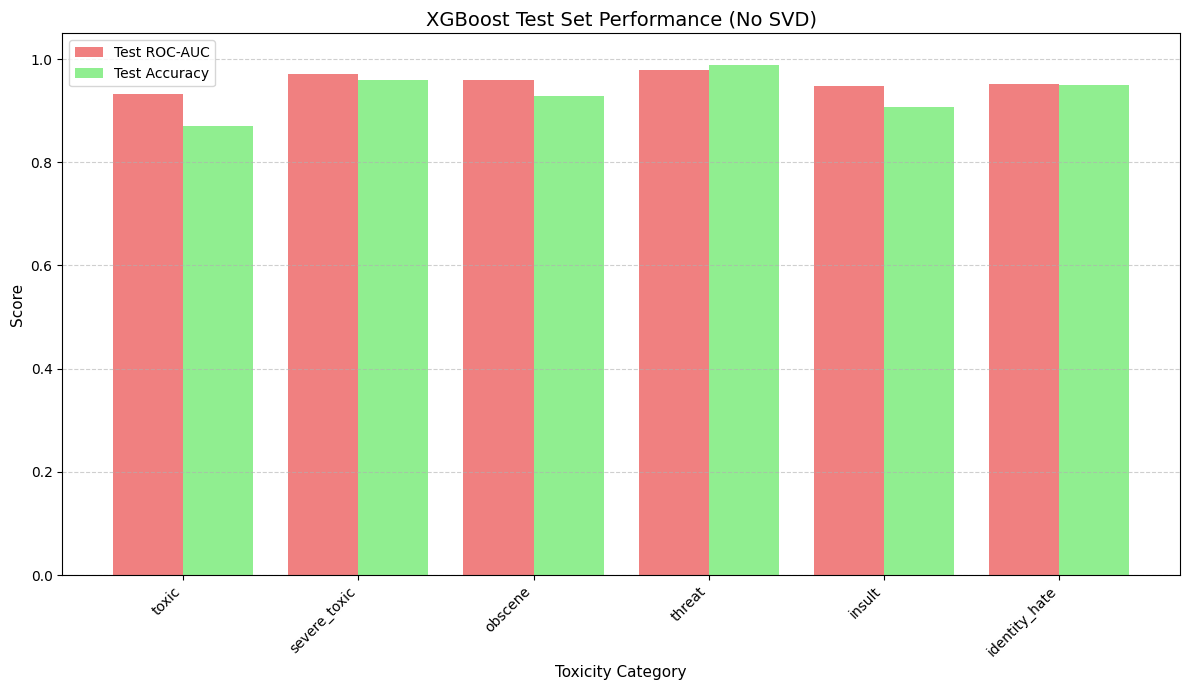


Chart generation finished.


In [ ]:
# --- Continue in the same cell or add as a new cell ---
# --- Requires variables from the previous cell: ---
# --- toxicity_columns, test_roc_auc_scores_xgb, test_accuracy_scores_xgb ---

# 9. Generate Performance Comparison Bar Chart

print("\nGenerating performance comparison chart...")

# Check if score dictionaries exist and contain data
roc_scores_exist = 'test_roc_auc_scores_xgb' in locals() and test_roc_auc_scores_xgb
acc_scores_exist = 'test_accuracy_scores_xgb' in locals() and test_accuracy_scores_xgb

if not roc_scores_exist and not acc_scores_exist:
    print("Skipping chart: No valid ROC AUC or Accuracy scores found.")
else:
    try:
        # Create DataFrame from scores
        summary_data = {'Category': toxicity_columns}
        if roc_scores_exist:
            summary_data['Test_ROC_AUC'] = [test_roc_auc_scores_xgb.get(label, np.nan) for label in toxicity_columns]
        if acc_scores_exist:
            summary_data['Test_Accuracy'] = [test_accuracy_scores_xgb.get(label, np.nan) for label in toxicity_columns]
        summary_df = pd.DataFrame(summary_data)

        # --- Save Summary Table (Optional but good practice) ---
        summary_file_path = 'jigsaw_data/results/performance_summary_xgb_nosvd.csv'
        summary_df.to_csv(summary_file_path, index=False, float_format='%.4f')
        print("\nPerformance Summary (Test Set - XGBoost No SVD):")
        # Check if DataFrame has columns before printing
        if 'Test_ROC_AUC' in summary_df.columns or 'Test_Accuracy' in summary_df.columns:
             print(summary_df.to_string())
        else:
             print("No test metrics available to display.")
        print(f"\nPerformance summary saved to {summary_file_path}")
        # --------------------------------------------------------


        # Check if there are metrics to plot (after potential NaN assignment)
        metrics_present = ('Test_ROC_AUC' in summary_df.columns and not summary_df['Test_ROC_AUC'].isnull().all()) or \
                          ('Test_Accuracy' in summary_df.columns and not summary_df['Test_Accuracy'].isnull().all())

        if not metrics_present:
             print("\nSkipping chart generation: No valid scores available after processing.")
        else:
            # --- Plotting ---
            fig_bar, ax_bar = plt.subplots(figsize=(12, 7))
            num_metrics = sum(1 for col in ['Test_ROC_AUC', 'Test_Accuracy'] if col in summary_df.columns)
            bar_width = 0.8 / num_metrics if num_metrics > 0 else 0.8
            index = np.arange(len(toxicity_columns))
            offset = - (num_metrics - 1) * bar_width / 2

            colors = ['lightcoral', 'lightgreen'] # Colors for XGBoost comparison
            metrics_plotted = 0

            # Plot Test ROC AUC if available
            if 'Test_ROC_AUC' in summary_df.columns:
                ax_bar.bar(index + offset + metrics_plotted * bar_width, summary_df['Test_ROC_AUC'].fillna(0), bar_width, label='Test ROC-AUC', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1

            # Plot Test Accuracy if available
            if 'Test_Accuracy' in summary_df.columns:
                ax_bar.bar(index + offset + metrics_plotted * bar_width, summary_df['Test_Accuracy'].fillna(0), bar_width, label='Test Accuracy', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1

            # Chart Formatting
            ax_bar.set_xlabel('Toxicity Category', fontsize=11)
            ax_bar.set_ylabel('Score', fontsize=11)
            ax_bar.set_title('XGBoost Test Set Performance (No SVD)', fontsize=14)
            ax_bar.set_xticks(index)
            ax_bar.set_xticklabels(toxicity_columns, rotation=45, ha="right", fontsize=10)
            ax_bar.set_ylim(0, 1.05)
            ax_bar.legend(fontsize=10)
            ax_bar.grid(True, axis='y', linestyle='--', alpha=0.6)
            fig_bar.tight_layout()

            # Save and Show
            chart_save_path = 'jigsaw_data/plots/performance_comparison_xgb_nosvd.png'
            plt.savefig(chart_save_path, dpi=300)
            print(f"\nPerformance comparison chart saved to {chart_save_path}")
            plt.show()
            plt.close(fig_bar)
            # ------------------

    except Exception as e:
        print(f"\nError generating performance chart: {e}")

print("\nChart generation finished.")

## With SVD


Loading original data features for SVD...
Data loading complete.

Standardizing dense features...
Dense features standardized.

Combining sparse and dense features (pre-SVD)...
Feature combination complete.
X_train_combined (pre-SVD): Shape = (159571, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>
X_test_combined (pre-SVD): Shape = (153164, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>

Applying Truncated SVD for dimensionality reduction...
Fitting SVD on training data (n_components=500)...
Transforming test data using fitted SVD...
SVD transformation complete.
X_train_svd (post-SVD): Shape = (159571, 500), Type = <class 'numpy.ndarray'>
X_test_svd (post-SVD): Shape = (153164, 500), Type = <class 'numpy.ndarray'>
SVD Explained Variance Ratio (Top 500): 0.9121
SVD model saved to jigsaw_data/svd_model.pkl

Using default XGBoost parameters for SVD data: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'use_label_encoder': False, 'n_estimators': 200, 'learning_rate': 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Test labels loaded. Shape: (63978, 7)
Test IDs loaded. Shape: (153164, 1)

Generating predictions on the SVD test set...
  Predicting for 'toxic' (SVD)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


  Predicting for 'severe_toxic' (SVD)...
  Predicting for 'obscene' (SVD)...
  Predicting for 'threat' (SVD)...
  Predicting for 'insult' (SVD)...
  Predicting for 'identity_hate' (SVD)...

Aligning SVD predictions with scored test labels...
Aligned SVD data for evaluation. Proba shape: (63978, 13), Bin shape: (63978, 13)

Aligned SVD test predictions (probabilities) saved to jigsaw_data/test_predictions_xgb_svd_aligned_probas.csv

Calculating Test Metrics (SVD Models)...
  'toxic' (SVD): Test ROC-AUC = 0.9127, Test Accuracy = 0.8670
  'severe_toxic' (SVD): Test ROC-AUC = 0.9688, Test Accuracy = 0.9768
  'obscene' (SVD): Test ROC-AUC = 0.9373, Test Accuracy = 0.9219
  'threat' (SVD): Test ROC-AUC = 0.9523, Test Accuracy = 0.9948
  'insult' (SVD): Test ROC-AUC = 0.9313, Test Accuracy = 0.9108
  'identity_hate' (SVD): Test ROC-AUC = 0.9274, Test Accuracy = 0.9651

Generating confusion matrices for the test set (SVD Models)...


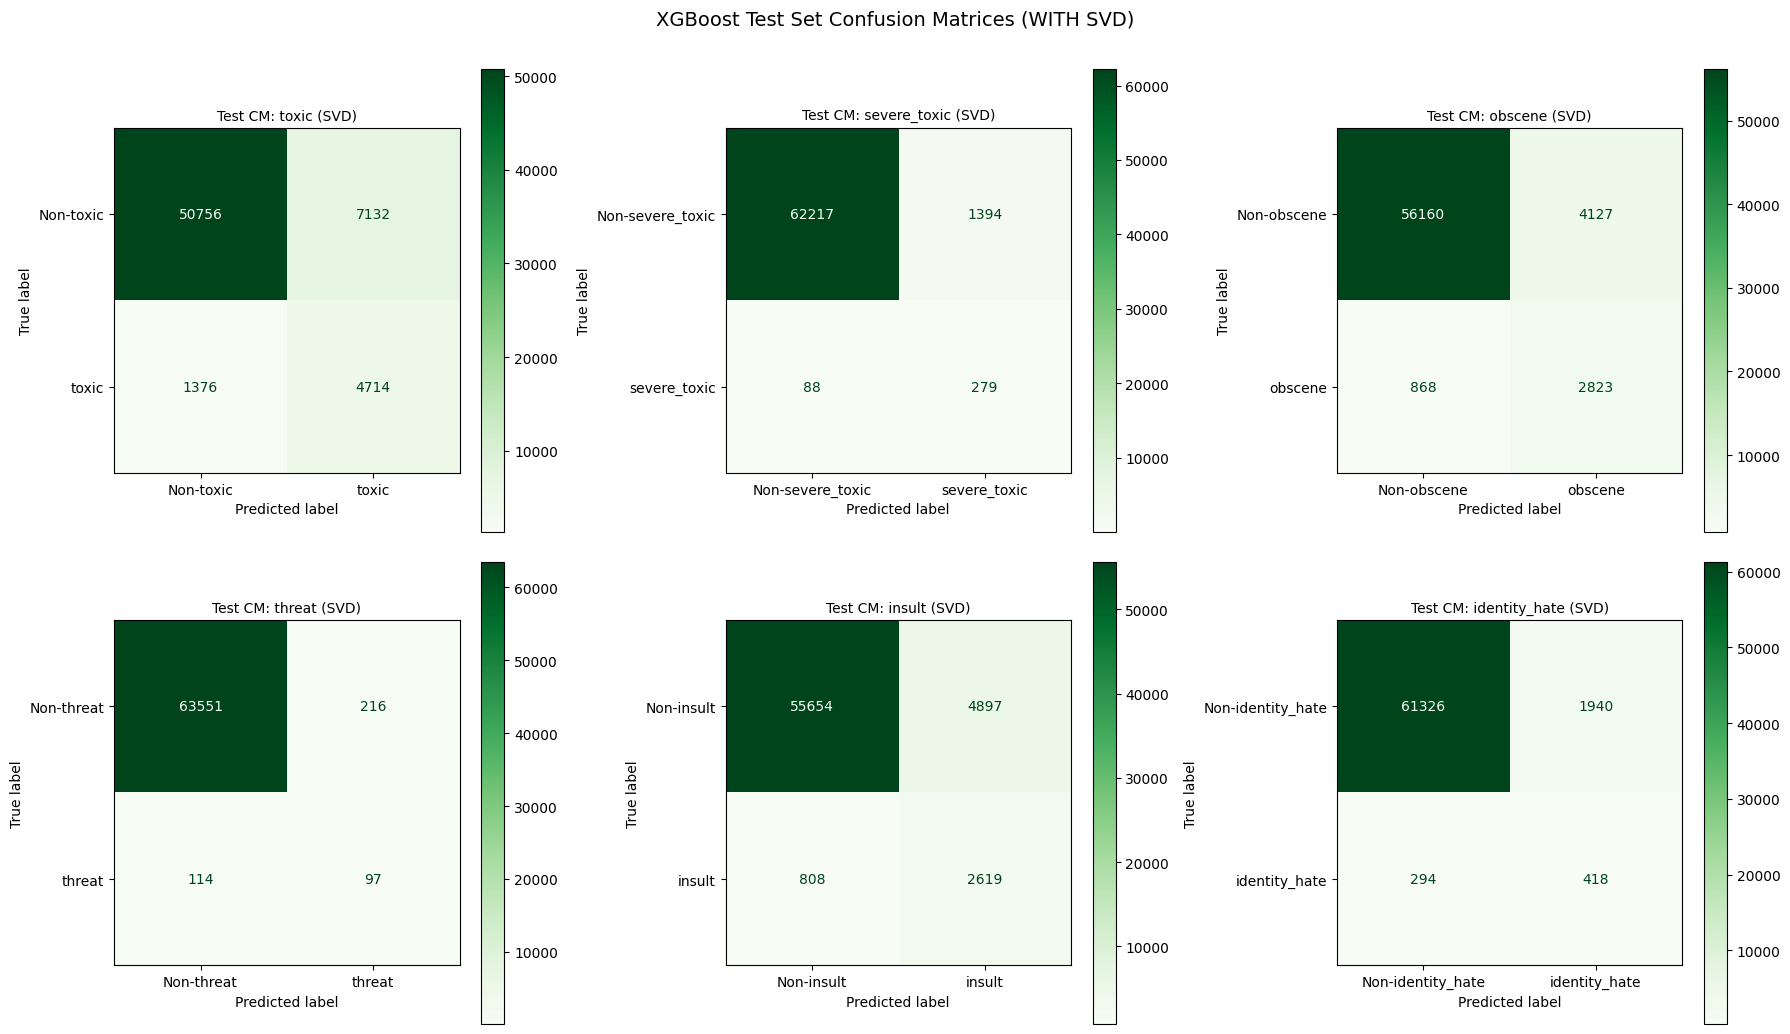

Test confusion matrices (SVD) saved to jigsaw_data/plots/test_confusion_matrices_xgb_svd.png

--- Summarizing SVD Results ---

Performance Summary (Test Set - SVD):
        Category  Test_ROC_AUC_SVD  Test_Accuracy_SVD
0          toxic          0.912724           0.867017
1   severe_toxic          0.968792           0.976836
2        obscene          0.937301           0.921926
3         threat          0.952345           0.994842
4         insult          0.931294           0.910829
5  identity_hate          0.927361           0.965082

SVD performance summary saved to jigsaw_data/results/performance_summary_xgb_svd.csv

Generating SVD performance comparison chart...


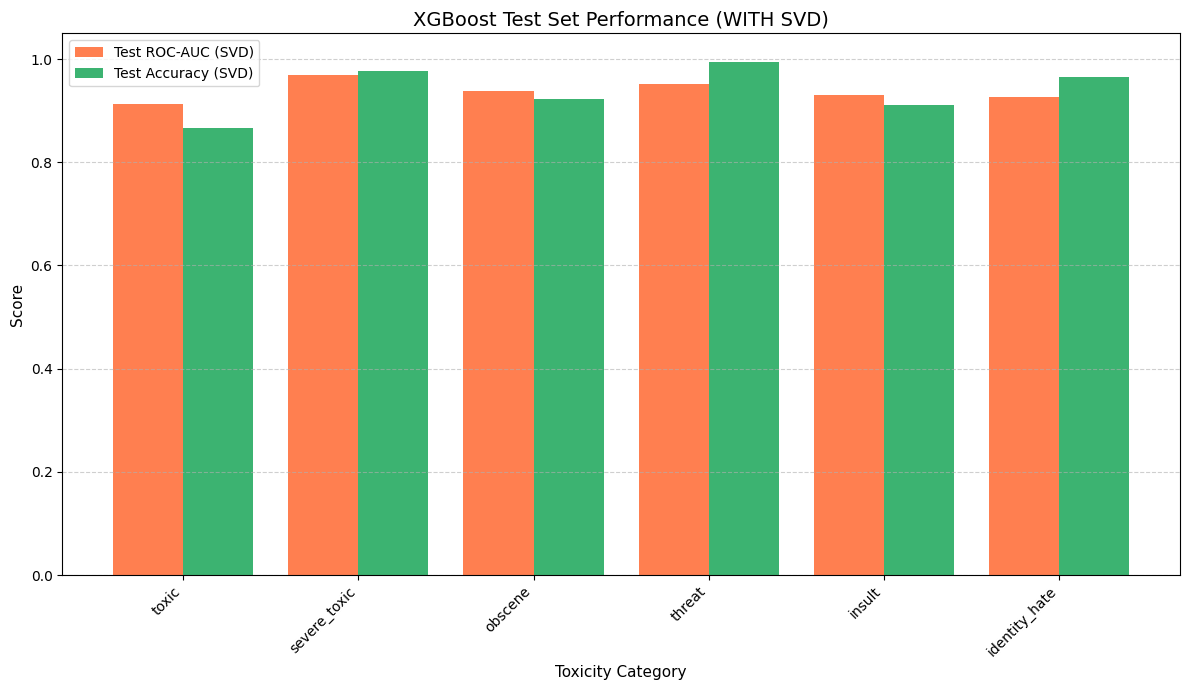

SVD performance comparison chart saved to jigsaw_data/plots/performance_comparison_xgb_svd.png

✅ XGBoost (WITH SVD) replacement block finished.
Ensure 'jigsaw_data/y_test.csv' exists for test evaluation.


In [ ]:
try:
    print("\nLoading original data features for SVD...")
    X_train_tfidf = load_npz('jigsaw_data/X_train_tfidf.npz').tocsr()
    X_test_tfidf = load_npz('jigsaw_data/X_test_tfidf.npz').tocsr()
    train_text_features = pd.read_csv('jigsaw_data/train_text_features.csv', dtype=np.float32)
    test_text_features = pd.read_csv('jigsaw_data/test_text_features.csv', dtype=np.float32)
    y_train = pd.read_csv('jigsaw_data/y_train.csv')
    print("Data loading complete.")

    # --- 4. Standardize and Combine Features ---
    print("\nStandardizing dense features...")
    scaler = StandardScaler(with_mean=False)
    train_text_features_scaled = scaler.fit_transform(train_text_features)
    test_text_features_scaled = scaler.transform(test_text_features)
    print("Dense features standardized.")

    print("\nCombining sparse and dense features (pre-SVD)...")
    # Combine for SVD input - CSR is fine here
    X_train_combined = hstack([X_train_tfidf, train_text_features_scaled], format='csr')
    X_test_combined = hstack([X_test_tfidf, test_text_features_scaled], format='csr')
    print("Feature combination complete.")

    debug_print("X_train_combined (pre-SVD)", X_train_combined)
    debug_print("X_test_combined (pre-SVD)", X_test_combined)

    # --- 5. Apply SVD ---
    print("\nApplying Truncated SVD for dimensionality reduction...")
    n_components_svd = 500 # Number of SVD components (tune this)
    svd = TruncatedSVD(n_components=n_components_svd, random_state=42)

    print(f"Fitting SVD on training data (n_components={n_components_svd})...")
    X_train_svd = svd.fit_transform(X_train_combined)
    print("Transforming test data using fitted SVD...")
    X_test_svd = svd.transform(X_test_combined)
    print("SVD transformation complete.")

    debug_print("X_train_svd (post-SVD)", X_train_svd)
    debug_print("X_test_svd (post-SVD)", X_test_svd)
    print(f"SVD Explained Variance Ratio (Top {n_components_svd}): {sum(svd.explained_variance_ratio_):.4f}")

    # Save the SVD model
    svd_save_path = 'jigsaw_data/svd_model.pkl'
    joblib.dump(svd, svd_save_path, compress=3)
    print(f"SVD model saved to {svd_save_path}")


except Exception as e:
    print(f"Error during data loading/preparation/SVD: {e}")
    raise


# --- 6. Hyperparameters & Training Function Definition ---
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Define default XGBoost parameters (Using SVD, data is dense, GPU still beneficial)
xgb_params_svd = {
    'objective': 'binary:logistic', 'eval_metric': 'auc', 'use_label_encoder': False,
    'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0,
    # SVD data is dense, gpu_hist still works. 'hist' is CPU fallback.
    'tree_method': 'gpu_hist',
    'random_state': 42
    # Note: colsample_bylevel/bynode might be relevant for dense data tuning
}
print(f"\nUsing default XGBoost parameters for SVD data: {xgb_params_svd}")

# Training function (same as before, handles GPU/CPU fallback)
def train_model_xgb_svd(label, X_train_data_svd, y_train_data, params):
    try:
        print(f"Defining training process for '{label}' (SVD)...")
        count_neg = y_train_data[label].value_counts().get(0, 0)
        count_pos = y_train_data[label].value_counts().get(1, 0)
        scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1
        print(f"  Label: '{label}', scale_pos_weight: {scale_pos_weight:.2f}")
        current_params = params.copy()
        current_params['scale_pos_weight'] = scale_pos_weight
        model = xgb.XGBClassifier(**current_params)
        print(f"Attempting GPU training for '{label}' (SVD)...")
        model.fit(X_train_data_svd, y_train_data[label]) # Fit on SVD data
        print(f"XGBoost model trained for '{label}' successfully (GPU, SVD).")
        return model
    except Exception as e:
        print(f"Error training XGBoost model for '{label}' (GPU attempt, SVD): {e}")
        if 'gpu_hist' in str(e).lower() or 'cuda' in str(e).lower():
             print(f"GPU for '{label}' (SVD) failed. Trying with 'hist' (CPU)...")
             try:
                 cpu_params = params.copy(); cpu_params['tree_method'] = 'hist'; cpu_params['scale_pos_weight'] = scale_pos_weight; cpu_params['n_jobs'] = -1
                 model = xgb.XGBClassifier(**cpu_params)
                 model.fit(X_train_data_svd, y_train_data[label])
                 print(f"XGBoost model trained for '{label}' using CPU (SVD).")
                 return model
             except Exception as e2:
                 print(f"Error training XGBoost model for '{label}' (CPU fallback, SVD): {e2}")
                 return None
        else:
             print(f"Non-GPU Error training XGBoost model for '{label}' (SVD): {e}")
             return None

# --- 7. Train Models & Save ---
try:
    print("\nStarting parallel training of XGBoost models (WITH SVD)...")
    models_xgb_svd = Parallel(n_jobs=-1)(
        delayed(train_model_xgb_svd)(label, X_train_svd, y_train, xgb_params_svd) for label in toxicity_columns
    )
    failed_models = [toxicity_columns[i] for i, m in enumerate(models_xgb_svd) if m is None]
    if failed_models: print(f"\nWarning: Training failed for SVD models: {failed_models}")
    else: print("\nAll XGBoost models (SVD) trained successfully.")
except Exception as e:
    print(f"\nError during parallel XGBoost training execution (SVD): {e}")
    models_xgb_svd = [None] * len(toxicity_columns)

models_trained_dict_svd = {label: model for label, model in zip(toxicity_columns, models_xgb_svd) if model is not None}
if models_trained_dict_svd:
    try:
        save_path = 'jigsaw_data/xgboost_models_dict_svd.pkl'
        print(f"\nSaving {len(models_trained_dict_svd)} successfully trained models to {save_path}...")
        joblib.dump(models_trained_dict_svd, save_path, compress=3)
        print("SVD models saved successfully.")
    except Exception as e:
        print(f"\nError saving XGBoost models (SVD): {e}")
else:
    print("\nNo SVD models trained successfully, skipping saving.")

# --- 8. Test Set Evaluation (Metrics & Confusion Matrices) ---
test_roc_auc_scores_xgb_svd = {}
test_accuracy_scores_xgb_svd = {}
test_predictions_svd = {}

try:
    print("\n--- Starting Test Set Evaluation (SVD Models) ---")
    y_test_path = 'jigsaw_data/y_test.csv'
    test_path = 'jigsaw_data/test.csv' # Need the original test IDs
    print(f"Attempting to load test labels from: {y_test_path}")
    print(f"Attempting to load test IDs from: {test_path}")

    if not os.path.exists(y_test_path):
        raise FileNotFoundError(f"{y_test_path} not found. Create it from test_labels.csv.")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"{test_path} not found. Ensure it was unzipped.")

    y_test = pd.read_csv(y_test_path)
    test_ids_df = pd.read_csv(test_path, usecols=['id'])
    print(f"Test labels loaded. Shape: {y_test.shape}")
    print(f"Test IDs loaded. Shape: {test_ids_df.shape}")

    # Generate Test Predictions using SVD features
    print("\nGenerating predictions on the SVD test set...")
    y_test_pred_proba_xgb_svd_full = np.zeros((X_test_svd.shape[0], len(toxicity_columns)))
    y_test_pred_xgb_svd_full = np.zeros((X_test_svd.shape[0], len(toxicity_columns)), dtype=int)

    for i, label in enumerate(toxicity_columns):
        model = models_trained_dict_svd.get(label) # Use SVD models
        if model:
            print(f"  Predicting for '{label}' (SVD)...")
            pred_proba = model.predict_proba(X_test_svd)[:, 1] # Predict on X_test_svd
            pred_binary = (pred_proba >= 0.5).astype(int)
            y_test_pred_proba_xgb_svd_full[:, i] = pred_proba
            y_test_pred_xgb_svd_full[:, i] = pred_binary
        else:
            print(f"  Skipping prediction for '{label}' (SVD) - model not trained.")
            y_test_pred_proba_xgb_svd_full[:, i] = np.nan
            y_test_pred_xgb_svd_full[:, i] = -1

    # Align Predictions with Scored Labels (using SVD predictions)
    print("\nAligning SVD predictions with scored test labels...")
    proba_cols_svd = [f'{col}_proba_svd' for col in toxicity_columns]
    predictions_df_proba_full_svd = pd.DataFrame(y_test_pred_proba_xgb_svd_full, columns=proba_cols_svd)
    predictions_df_proba_full_svd['id'] = test_ids_df['id']

    pred_cols_svd = [f'{col}_pred_svd' for col in toxicity_columns]
    predictions_df_bin_full_svd = pd.DataFrame(y_test_pred_xgb_svd_full, columns=pred_cols_svd)
    predictions_df_bin_full_svd['id'] = test_ids_df['id']

    eval_df_proba_svd = pd.merge(y_test, predictions_df_proba_full_svd, on='id', how='inner')
    eval_df_bin_svd = pd.merge(y_test, predictions_df_bin_full_svd, on='id', how='inner')
    print(f"Aligned SVD data for evaluation. Proba shape: {eval_df_proba_svd.shape}, Bin shape: {eval_df_bin_svd.shape}")

    # Save Aligned Probabilities
    prob_save_path_aligned_svd = 'jigsaw_data/test_predictions_xgb_svd_aligned_probas.csv'
    eval_df_proba_svd[['id'] + proba_cols_svd].to_csv(prob_save_path_aligned_svd, index=False, float_format='%.6f')
    print(f"\nAligned SVD test predictions (probabilities) saved to {prob_save_path_aligned_svd}")

    # Calculate Test Metrics on Aligned SVD Data
    print("\nCalculating Test Metrics (SVD Models)...")
    for label in toxicity_columns:
        true_label_col = label
        proba_label_col = f'{label}_proba_svd'
        pred_label_col = f'{label}_pred_svd'

        if label in models_trained_dict_svd and proba_label_col in eval_df_proba_svd.columns and pred_label_col in eval_df_bin_svd.columns:
            y_true = eval_df_proba_svd[true_label_col]
            y_pred_proba = eval_df_proba_svd[proba_label_col]
            y_pred_binary = eval_df_bin_svd[pred_label_col]
            test_predictions_svd[label] = y_pred_binary # Store for CM

            if len(np.unique(y_true)) > 1: score_roc = roc_auc_score(y_true, y_pred_proba)
            else: print(f"  '{label}': ROC AUC undefined."); score_roc = np.nan
            score_acc = accuracy_score(y_true, y_pred_binary)
            test_roc_auc_scores_xgb_svd[label] = score_roc
            test_accuracy_scores_xgb_svd[label] = score_acc
            print(f"  '{label}' (SVD): Test ROC-AUC = {score_roc:.4f}, Test Accuracy = {score_acc:.4f}")
        else:
            print(f"  '{label}' (SVD): Skipping metrics.")
            test_roc_auc_scores_xgb_svd[label] = np.nan
            test_accuracy_scores_xgb_svd[label] = np.nan

    # Generate Confusion Matrices (SVD Models)
    print("\nGenerating confusion matrices for the test set (SVD Models)...")
    fig_svd, axes_svd = plt.subplots(2, 3, figsize=(18, 11))
    axes_svd = axes_svd.ravel()
    plot_generated_svd = False

    for idx, label in enumerate(toxicity_columns):
         if label in models_trained_dict_svd and label in test_predictions_svd:
             y_true = eval_df_bin_svd[label]
             y_pred = test_predictions_svd[label]
             cm = confusion_matrix(y_true, y_pred)
             disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Non-{label}', label])
             disp.plot(ax=axes_svd[idx], cmap='Greens', values_format='d') # Different color map
             axes_svd[idx].set_title(f"Test CM: {label} (SVD)", fontsize=10)
             plot_generated_svd = True
         else:
            axes_svd[idx].text(0.5, 0.5, 'Model Failed / No Data', ha='center', va='center', fontsize=9)
            axes_svd[idx].set_title(f'Test CM: {label} (SVD)', fontsize=10)

    if plot_generated_svd:
        plt.suptitle("XGBoost Test Set Confusion Matrices (WITH SVD)", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        cm_save_path_svd = 'jigsaw_data/plots/test_confusion_matrices_xgb_svd.png'
        plt.savefig(cm_save_path_svd, dpi=300); plt.show(); plt.close()
        print(f"Test confusion matrices (SVD) saved to {cm_save_path_svd}")
    else:
        print("No SVD confusion matrices generated.")

except FileNotFoundError as e:
    print(f"\n{e}")
    print("Skipping ALL Test Set Evaluation & Plotting for SVD models.")
    test_roc_auc_scores_xgb_svd = None
    test_accuracy_scores_xgb_svd = None
except Exception as e:
    print(f"\nAn error occurred during SVD test set evaluation: {e}")
    test_roc_auc_scores_xgb_svd = test_roc_auc_scores_xgb_svd if test_roc_auc_scores_xgb_svd else None
    test_accuracy_scores_xgb_svd = test_accuracy_scores_xgb_svd if test_accuracy_scores_xgb_svd else None

# --- 9. Results Summary & Comparison Chart (SVD Models) ---
try:
    print("\n--- Summarizing SVD Results ---")
    if 'test_roc_auc_scores_xgb_svd' not in locals() or test_roc_auc_scores_xgb_svd is None:
         print("SVD test results unavailable. Cannot generate summary or chart.")
    else:
        summary_data_svd = {'Category': toxicity_columns}
        if test_roc_auc_scores_xgb_svd: summary_data_svd['Test_ROC_AUC_SVD'] = [test_roc_auc_scores_xgb_svd.get(label, np.nan) for label in toxicity_columns]
        if test_accuracy_scores_xgb_svd: summary_data_svd['Test_Accuracy_SVD'] = [test_accuracy_scores_xgb_svd.get(label, np.nan) for label in toxicity_columns]

        summary_df_svd = pd.DataFrame(summary_data_svd)
        summary_file_path_svd = 'jigsaw_data/results/performance_summary_xgb_svd.csv'
        summary_df_svd.to_csv(summary_file_path_svd, index=False, float_format='%.4f')
        print("\nPerformance Summary (Test Set - SVD):")
        if 'Test_ROC_AUC_SVD' in summary_df_svd.columns or 'Test_Accuracy_SVD' in summary_df_svd.columns: print(summary_df_svd.to_string())
        else: print("No SVD test metrics available to display.")
        print(f"\nSVD performance summary saved to {summary_file_path_svd}")

        # Generate Comparison Bar Chart
        if test_roc_auc_scores_xgb_svd and test_accuracy_scores_xgb_svd and not summary_df_svd[['Test_ROC_AUC_SVD', 'Test_Accuracy_SVD']].isnull().all().all():
            print("\nGenerating SVD performance comparison chart...")
            plt.figure(figsize=(12, 7))
            num_metrics = sum(1 for col in ['Test_ROC_AUC_SVD', 'Test_Accuracy_SVD'] if col in summary_df_svd.columns)
            bar_width = 0.8 / num_metrics
            index = np.arange(len(toxicity_columns))
            offset = - (num_metrics - 1) * bar_width / 2
            colors = ['coral', 'mediumseagreen'] # Different colors for SVD chart
            metrics_plotted = 0
            if 'Test_ROC_AUC_SVD' in summary_df_svd.columns: plt.bar(index + offset + metrics_plotted * bar_width, summary_df_svd['Test_ROC_AUC_SVD'].fillna(0), bar_width, label='Test ROC-AUC (SVD)', color=colors[metrics_plotted % len(colors)]); metrics_plotted += 1
            if 'Test_Accuracy_SVD' in summary_df_svd.columns: plt.bar(index + offset + metrics_plotted * bar_width, summary_df_svd['Test_Accuracy_SVD'].fillna(0), bar_width, label='Test Accuracy (SVD)', color=colors[metrics_plotted % len(colors)]); metrics_plotted += 1

            plt.xlabel('Toxicity Category', fontsize=11); plt.ylabel('Score', fontsize=11)
            plt.title('XGBoost Test Set Performance (WITH SVD)', fontsize=14)
            plt.xticks(index, toxicity_columns, rotation=45, ha="right", fontsize=10); plt.ylim(0, 1.05)
            plt.legend(fontsize=10); plt.grid(True, axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout(); chart_path_svd = 'jigsaw_data/plots/performance_comparison_xgb_svd.png'
            plt.savefig(chart_path_svd, dpi=300); plt.show(); plt.close()
            print(f"SVD performance comparison chart saved to {chart_path_svd}")
        else:
            print("\nSkipping SVD performance comparison chart (no valid test metrics).")

except NameError:
    print("Evaluation results dictionaries not found. Skipping summary and chart for SVD.")
except Exception as e:
    print(f"Error summarizing SVD results or plotting: {e}")


print("\n✅ XGBoost (WITH SVD) replacement block finished.")
print("Ensure 'jigsaw_data/y_test.csv' exists for test evaluation.")

## Compare SVD vs no SVD

Loading No-SVD results from: jigsaw_data/results/performance_summary_xgb_nosvd.csv

Loading SVD results from: jigsaw_data/results/performance_summary_xgb_svd.csv

Successfully loaded performance data.

Merging results for comparison...

--- Performance Comparison Table ---
        Category  Test_ROC_AUC_NoSVD  Test_Accuracy_NoSVD  Test_ROC_AUC_SVD  Test_Accuracy_SVD
0  identity_hate              0.9514               0.9498            0.9274             0.9651
1         insult              0.9486               0.9068            0.9313             0.9108
2        obscene              0.9592               0.9293            0.9373             0.9219
3   severe_toxic              0.9719               0.9587            0.9688             0.9768
4         threat              0.9793               0.9878            0.9523             0.9948
5          toxic              0.9333               0.8700            0.9127             0.8670

Comparison summary saved to: jigsaw_data/results/comparison_

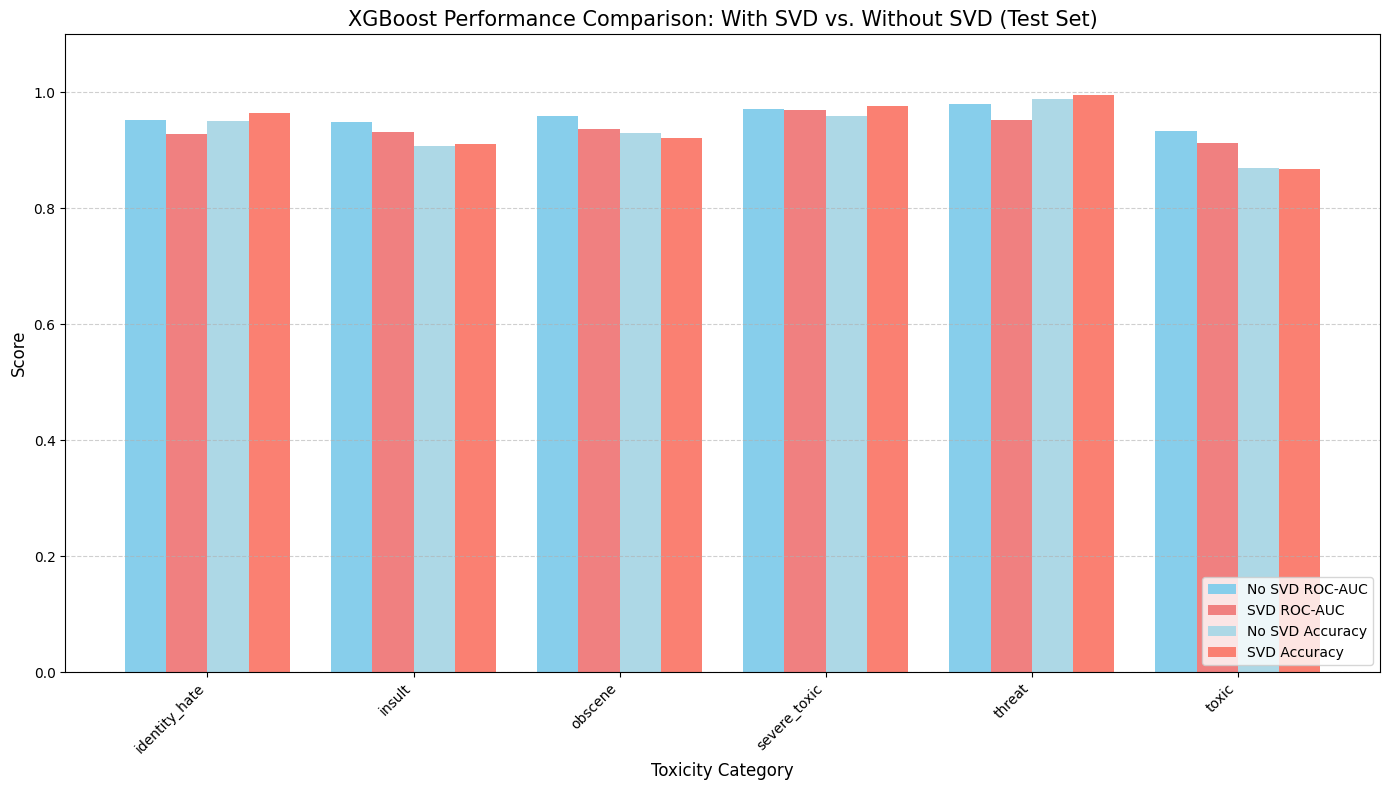

Comparison chart saved to: jigsaw_data/plots/comparison_chart_xgb_svd_vs_nosvd.png

--- Comparison Process Finished ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define file paths for the results
results_dir = 'jigsaw_data/results'
plots_dir = 'jigsaw_data/plots'
nosvd_results_path = os.path.join(results_dir, 'performance_summary_xgb_nosvd.csv')
svd_results_path = os.path.join(results_dir, 'performance_summary_xgb_svd.csv')
comparison_output_path = os.path.join(results_dir, 'comparison_summary_xgb_svd_vs_nosvd.csv')
comparison_chart_path = os.path.join(plots_dir, 'comparison_chart_xgb_svd_vs_nosvd.png')

# --- 1. Load Performance Data ---
try:
    print(f"Loading No-SVD results from: {nosvd_results_path}")
    if not os.path.exists(nosvd_results_path):
        raise FileNotFoundError(f"File not found: {nosvd_results_path}. Please run the 'No SVD' training/evaluation cell.")
    df_nosvd = pd.read_csv(nosvd_results_path)
    # Rename columns for clarity before merge
    df_nosvd = df_nosvd.rename(columns={
        'Test_ROC_AUC': 'Test_ROC_AUC_NoSVD',
        'Test_Accuracy': 'Test_Accuracy_NoSVD'
    })
    # Keep only relevant columns for comparison
    df_nosvd = df_nosvd[['Category', 'Test_ROC_AUC_NoSVD', 'Test_Accuracy_NoSVD']]

    print(f"\nLoading SVD results from: {svd_results_path}")
    if not os.path.exists(svd_results_path):
         raise FileNotFoundError(f"File not found: {svd_results_path}. Please run the 'WITH SVD' training/evaluation cell.")
    df_svd = pd.read_csv(svd_results_path)
    # Rename columns for clarity before merge
    df_svd = df_svd.rename(columns={
        'Test_ROC_AUC_SVD': 'Test_ROC_AUC_SVD',
        'Test_Accuracy_SVD': 'Test_Accuracy_SVD'
    })
     # Keep only relevant columns for comparison
    df_svd = df_svd[['Category', 'Test_ROC_AUC_SVD', 'Test_Accuracy_SVD']]


    print("\nSuccessfully loaded performance data.")

except FileNotFoundError as e:
    print(f"\nError loading results files: {e}")
    print("Cannot proceed with comparison. Ensure both XGBoost blocks were run successfully including test evaluation.")
    # Exit this cell's execution cleanly if files aren't found
    df_comparison = None # Set to None so subsequent steps are skipped
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    df_comparison = None

# --- 2. Merge and Display Comparison Table ---
if 'df_nosvd' in locals() and 'df_svd' in locals(): # Proceed only if loading was successful
    try:
        print("\nMerging results for comparison...")
        # Use outer merge to keep all categories even if one model failed for a specific category
        df_comparison = pd.merge(df_nosvd, df_svd, on='Category', how='outer')

        print("\n--- Performance Comparison Table ---")
        print(df_comparison.to_string(float_format='%.4f')) # Display full table

        # Save the comparison table
        df_comparison.to_csv(comparison_output_path, index=False, float_format='%.4f')
        print(f"\nComparison summary saved to: {comparison_output_path}")

    except Exception as e:
        print(f"Error during merging or saving comparison table: {e}")
        df_comparison = None # Prevent chart generation if merge fails

# --- 3. Generate Comparison Bar Chart ---
if df_comparison is not None and not df_comparison.empty: # Proceed only if merge was successful
    try:
        print("\nGenerating comparison bar chart...")
        plt.figure(figsize=(14, 8)) # Wider figure for grouped bars

        categories = df_comparison['Category'].tolist()
        n_categories = len(categories)
        index = np.arange(n_categories)

        # Define metrics to plot and their labels/colors
        metrics = {
            'NoSVD_AUC': ('Test_ROC_AUC_NoSVD', 'No SVD ROC-AUC', 'skyblue'),
            'SVD_AUC': ('Test_ROC_AUC_SVD', 'SVD ROC-AUC', 'lightcoral'),
            'NoSVD_Acc': ('Test_Accuracy_NoSVD', 'No SVD Accuracy', 'lightblue'),
            'SVD_Acc': ('Test_Accuracy_SVD', 'SVD Accuracy', 'salmon'),
        }

        # Check which metrics are actually present in the dataframe
        metrics_to_plot = {k: v for k, v in metrics.items() if v[0] in df_comparison.columns}
        num_metric_bars = len(metrics_to_plot)
        bar_width = 0.8 / num_metric_bars if num_metric_bars > 0 else 0.8 # Adjust width based on # bars

        # Calculate offsets for grouped bars
        offsets = np.linspace(-bar_width * (num_metric_bars - 1) / 2,
                              bar_width * (num_metric_bars - 1) / 2,
                              num_metric_bars)

        # Plot bars
        for i, (metric_key, (col_name, label, color)) in enumerate(metrics_to_plot.items()):
            # Fill NaN with 0 for plotting, but NaNs will be visible in the table
            plt.bar(index + offsets[i], df_comparison[col_name].fillna(0), bar_width, label=label, color=color)

        plt.xlabel('Toxicity Category', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.title('XGBoost Performance Comparison: With SVD vs. Without SVD (Test Set)', fontsize=15)
        plt.xticks(index, categories, rotation=45, ha="right", fontsize=10)
        plt.ylim(0, 1.1) # Y-axis from 0 to 1.1 for better visibility
        plt.legend(fontsize=10, loc='lower right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()

        # Save and show plot
        plt.savefig(comparison_chart_path, dpi=300)
        plt.show()
        plt.close()
        print(f"Comparison chart saved to: {comparison_chart_path}")

    except Exception as e:
        print(f"Error generating comparison chart: {e}")
else:
    print("\nSkipping chart generation because comparison data is unavailable.")


print("\n--- Comparison Process Finished ---")

# Random Forest

## Import libs

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier # Changed import
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack, load_npz
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import warnings

## Create output dirs & Load pre-calculated features

In [ ]:
os.makedirs('jigsaw_data/results', exist_ok=True)
os.makedirs('jigsaw_data/plots', exist_ok=True)

def debug_print(label, data):
    print(f"{label}: Shape = {data.shape}, Type = {type(data)}")

## Without SVD

In [ ]:
try:
    print("\nLoading data features...")
    X_train_tfidf = load_npz('jigsaw_data/X_train_tfidf.npz').tocsr()
    X_test_tfidf = load_npz('jigsaw_data/X_test_tfidf.npz').tocsr()
    train_text_features = pd.read_csv('jigsaw_data/train_text_features.csv', dtype=np.float32)
    test_text_features = pd.read_csv('jigsaw_data/test_text_features.csv', dtype=np.float32)
    y_train = pd.read_csv('jigsaw_data/y_train.csv')
    print("Data loading complete.")

    print("\nStandardizing dense features...")
    # Use with_mean=True for RF, which doesn't handle sparse centering well implicitly
    scaler = StandardScaler(with_mean=True) # Changed with_mean to True for RF
    train_text_features_scaled = scaler.fit_transform(train_text_features)
    test_text_features_scaled = scaler.transform(test_text_features)
    print("Dense features standardized.")

    print("\nCombining sparse and dense features...")
    # Convert scaled dense features to sparse matrix for hstack
    from scipy.sparse import csr_matrix
    train_text_features_scaled_sparse = csr_matrix(train_text_features_scaled)
    test_text_features_scaled_sparse = csr_matrix(test_text_features_scaled)

    # Use CSR format, often better for RF row slicing during training
    X_train_full = hstack([X_train_tfidf, train_text_features_scaled_sparse], format='csr')
    X_test_full = hstack([X_test_tfidf, test_text_features_scaled_sparse], format='csr')
    print("Feature combination complete.")

    debug_print("X_train_full", X_train_full)
    debug_print("X_test_full", X_test_full)

except Exception as e:
    print(f"Error during data loading/preparation: {e}")
    raise

# 5. Define model parameters and training function
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Define Random Forest parameters
rf_params = {
    'n_estimators': 150,       # Number of trees
    'max_depth': 20,          # Max depth of trees (can be None for fully grown)
    'min_samples_split': 5,   # Min samples to split a node
    'min_samples_leaf': 3,    # Min samples in a leaf node
    'class_weight': 'balanced', # Handle class imbalance
    'n_jobs': -1,             # Use all available CPU cores
    'random_state': 42,
    'max_features': 'sqrt'    # Number of features to consider for best split (common choice)
    # 'verbose': 1 # Uncomment for more verbose output during training
}
print(f"\nUsing Random Forest parameters: {rf_params}")

def train_model_rf(label, X_train_data, y_train_data, params):
    try:
        print(f"Training Random Forest for '{label}'...")
        # No need for scale_pos_weight calculation, handled by class_weight='balanced'
        model = RandomForestClassifier(**params)
        model.fit(X_train_data, y_train_data[label])
        print(f"Random Forest model trained for '{label}' successfully.")
        return model
    # Removed GPU/CPU fallback as RF is CPU-based in scikit-learn
    except Exception as e:
        print(f"Training failed for '{label}': {e}")
        return None

# 6. Train all models
try:
    print("\nStarting training...")
    # Parallel training using Joblib
    models_rf_nosvd = Parallel(n_jobs=1)( # Run model training sequentially if parallel causes memory issues
                                        # Or adjust n_jobs based on your system (e.g., n_jobs=4)
                                        # Running N RF models in parallel might consume lots of RAM
        delayed(train_model_rf)(label, X_train_full, y_train, rf_params) for label in toxicity_columns
    )
    failed_models = [toxicity_columns[i] for i, m in enumerate(models_rf_nosvd) if m is None]
    if failed_models:
        print(f"Training failed for: {failed_models}")
    else:
        print("All models trained successfully.")
except Exception as e:
    print(f"Training exception: {e}")
    models_rf_nosvd = [None] * len(toxicity_columns)

# Create a dictionary of successfully trained models
models_trained_dict = {label: model for label, model in zip(toxicity_columns, models_rf_nosvd) if model is not None}

# Save models
if models_trained_dict:
    save_path = 'jigsaw_data/rf_models_dict_nosvd.pkl' # Changed filename
    print(f"Saving models to {save_path}...")
    joblib.dump(models_trained_dict, save_path, compress=3)
    print("Models saved successfully.")
else:
    print("No models were trained successfully.")

# 7. Evaluate on test set
test_roc_auc_scores_rf = {}   # Renamed variable
test_accuracy_scores_rf = {}  # Renamed variable
confusion_matrices_rf = {}    # Store confusion matrices

if not models_trained_dict:
    print("\nSkipping evaluation as no models were trained.")
else:
    try:
        print("\nLoading test labels...")
        y_test = pd.read_csv('jigsaw_data/y_test.csv')
        test_ids_df = pd.read_csv('jigsaw_data/test.csv', usecols=['id'])

        print("Generating test predictions...")
        # Initialize prediction arrays
        y_test_pred_proba_rf_full = np.zeros((X_test_full.shape[0], len(toxicity_columns)))
        y_test_pred_rf_full = np.zeros((X_test_full.shape[0], len(toxicity_columns)), dtype=int)

        for i, label in enumerate(toxicity_columns):
            model = models_trained_dict.get(label)
            if model:
                print(f"Predicting for '{label}'...")
                # Predict probabilities and binary labels
                pred_proba = model.predict_proba(X_test_full)[:, 1]
                # Using default 0.5 threshold for binary prediction
                pred_binary = (pred_proba >= 0.5).astype(int)
                y_test_pred_proba_rf_full[:, i] = pred_proba
                y_test_pred_rf_full[:, i] = pred_binary
            else:
                # Handle cases where a model failed to train
                print(f"Skipping prediction for '{label}' (model not found).")
                y_test_pred_proba_rf_full[:, i] = np.nan # Use NaN for missing predictions
                y_test_pred_rf_full[:, i] = -1          # Use -1 or another indicator for missing binary predictions

        # Create DataFrames for predictions
        proba_cols = [f'{col}_proba' for col in toxicity_columns]
        pred_cols = [f'{col}_pred' for col in toxicity_columns]

        df_proba = pd.DataFrame(y_test_pred_proba_rf_full, columns=proba_cols)
        df_pred = pd.DataFrame(y_test_pred_rf_full, columns=pred_cols)
        df_proba['id'] = test_ids_df['id']
        df_pred['id'] = test_ids_df['id']

        # Align predictions with test labels based on 'id'
        # Use inner join to only evaluate on samples present in both y_test and predictions
        print("Aligning predictions with test labels...")
        eval_df_proba = pd.merge(y_test, df_proba, on='id', how='inner')
        eval_df_bin = pd.merge(y_test, df_pred, on='id', how='inner')

        # Check if alignment resulted in data
        if eval_df_proba.empty or eval_df_bin.empty:
             print("Alignment resulted in empty DataFrame. Check 'id' columns in test.csv and y_test.csv.")
        else:
            print(f"Aligned data shape for evaluation: {eval_df_bin.shape}")
            print("Saving aligned predictions...")
            eval_df_proba.to_csv('jigsaw_data/test_predictions_rf_nosvd_aligned_probas.csv', index=False) # Renamed file
            eval_df_bin.to_csv('jigsaw_data/test_predictions_rf_nosvd_aligned_preds.csv', index=False)     # Renamed file

            print("Calculating evaluation metrics and plotting confusion matrices...")
            results_summary = []
            plt.figure(figsize=(20, 15)) # Adjust figure size as needed

            for i, label in enumerate(toxicity_columns):
                 # Check if predictions exist for this label (in case model failed)
                 if f'{label}_pred' in eval_df_bin.columns and eval_df_bin[f'{label}_pred'].notna().all() and (eval_df_bin[f'{label}_pred'] != -1).all():
                     y_true = eval_df_bin[label]
                     y_pred = eval_df_bin[f'{label}_pred']
                     y_score = eval_df_proba[f'{label}_proba']

                     # Handle cases where a class might be missing in y_true for a specific label after alignment
                     if len(np.unique(y_true)) < 2:
                         print(f"Skipping AUC for '{label}': Only one class present in y_true.")
                         auc = np.nan # Cannot compute AUC with only one class
                     else:
                          try:
                             auc = roc_auc_score(y_true, y_score)
                          except Exception as e:
                             print(f"Error calculating AUC for {label}: {e}")
                             auc = np.nan

                     try:
                         acc = accuracy_score(y_true, y_pred)
                         cm = confusion_matrix(y_true, y_pred)
                         confusion_matrices_rf[label] = cm

                         test_roc_auc_scores_rf[label] = auc
                         test_accuracy_scores_rf[label] = acc
                         results_summary.append({'Label': label, 'AUC': auc, 'Accuracy': acc})
                         print(f"{label} - AUC: {auc:.4f}, Accuracy: {acc:.4f}")

                         # Plot confusion matrix
                         ax = plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
                         disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                         disp.plot(ax=ax, cmap=plt.cm.Blues)
                         ax.set_title(f'Confusion Matrix: {label}')

                     except Exception as e:
                         print(f"Error calculating metrics or plotting CM for {label}: {e}")
                         test_roc_auc_scores_rf[label] = np.nan
                         test_accuracy_scores_rf[label] = np.nan
                         confusion_matrices_rf[label] = None
                 else:
                     print(f"Skipping metrics for '{label}' due to missing predictions or failed model.")
                     test_roc_auc_scores_rf[label] = np.nan
                     test_accuracy_scores_rf[label] = np.nan
                     confusion_matrices_rf[label] = None

            plt.tight_layout()
            plot_path = 'jigsaw_data/plots/confusion_matrices_rf_nosvd.png'
            plt.savefig(plot_path)
            print(f"Confusion matrix plots saved to {plot_path}")
            plt.close() # Close the figure to free memory

            # Save results summary
            results_df = pd.DataFrame(results_summary)
            results_path = 'jigsaw_data/results/evaluation_summary_rf_nosvd.csv'
            results_df.to_csv(results_path, index=False)
            print(f"Evaluation summary saved to {results_path}")

            # Print overall average scores
            avg_auc = np.nanmean(list(test_roc_auc_scores_rf.values()))
            avg_acc = np.nanmean(list(test_accuracy_scores_rf.values()))
            print(f"\nAverage Test AUC (RF, No SVD): {avg_auc:.4f}")
            print(f"Average Test Accuracy (RF, No SVD): {avg_acc:.4f}")

    except FileNotFoundError:
        print("Error: y_test.csv or test.csv not found in jigsaw_data/. Cannot perform evaluation.")
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")


Loading data features...
Data loading complete.

Standardizing dense features...
Dense features standardized.

Combining sparse and dense features...
Feature combination complete.
X_train_full: Shape = (159571, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>
X_test_full: Shape = (153164, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>

Using Random Forest parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42, 'max_features': 'sqrt'}

Starting training...
Training Random Forest for 'toxic'...
Random Forest model trained for 'toxic' successfully.
Training Random Forest for 'severe_toxic'...
Random Forest model trained for 'severe_toxic' successfully.
Training Random Forest for 'obscene'...
Random Forest model trained for 'obscene' successfully.
Training Random Forest for 'threat'...
Random Forest model trained for 'threat' successfully.
Training Random Forest for 'insult'


--- Generating Confusion Matrices for Random Forest (No SVD) ---

Confusion matrices plot saved to jigsaw_data/plots/confusion_matrices_rf_nosvd.png


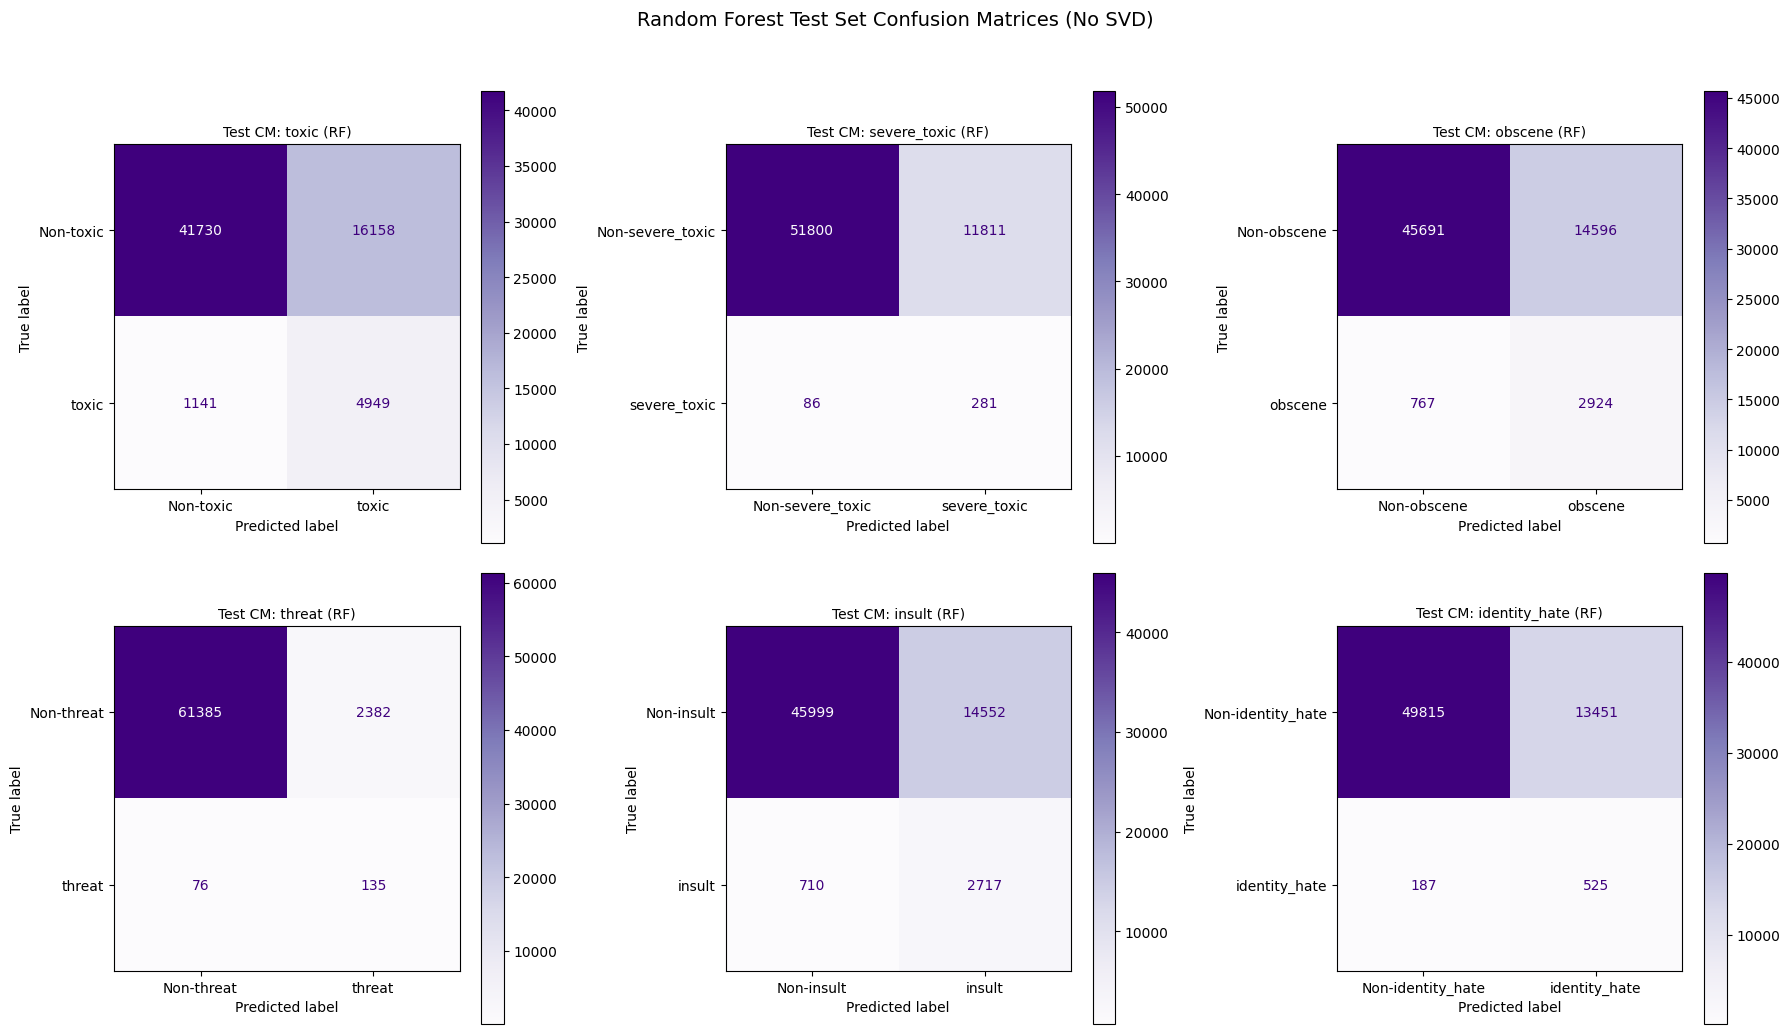


Confusion matrix generation finished.


In [ ]:
# --- CELL TO GENERATE CONFUSION MATRIX PLOT FOR RANDOM FOREST ---
# Assumes the previous cell ran successfully and created 'eval_df_bin'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

print("\n--- Generating Confusion Matrices for Random Forest (No SVD) ---")

# Define directories (optional, ensures plots directory exists)
plots_dir = 'jigsaw_data/plots'
os.makedirs(plots_dir, exist_ok=True)

# Check if the required evaluation DataFrame exists
if 'eval_df_bin' in locals() and isinstance(eval_df_bin, pd.DataFrame) and not eval_df_bin.empty:
    try:
        fig_cm_rf, axes_cm_rf = plt.subplots(2, 3, figsize=(18, 11)) # Create figure and axes
        axes_cm_rf = axes_cm_rf.ravel() # Flatten grid for easy iteration
        plot_generated_cm_rf = False

        # Ensure toxicity_columns is defined (should be from previous cell)
        if 'toxicity_columns' not in locals():
             toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] # Fallback definition

        for idx, label in enumerate(toxicity_columns):
            # Define column names for this label based on previous cell's logic
            true_col = label
            pred_col = f'{label}_pred' # The prediction column name used in eval_df_bin

            # Check if both necessary columns exist in the evaluation DataFrame
            if true_col in eval_df_bin.columns and pred_col in eval_df_bin.columns:
                try:
                    y_true = eval_df_bin[true_col]
                    y_pred = eval_df_bin[pred_col]

                    # Check if there are valid predictions (not the -1 placeholder)
                    if (y_pred != -1).any(): # Ensure there's at least one valid prediction
                        # Calculate confusion matrix only on valid prediction rows
                        valid_indices = y_pred != -1
                        cm = confusion_matrix(y_true[valid_indices], y_pred[valid_indices])

                        # Plot using ConfusionMatrixDisplay
                        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Non-{label}', label])
                        # Use 'Purples' color map for distinction if desired
                        disp.plot(ax=axes_cm_rf[idx], cmap='Purples', values_format='d')
                        axes_cm_rf[idx].set_title(f"Test CM: {label} (RF)", fontsize=10)
                        plot_generated_cm_rf = True
                    else:
                         print(f"Skipping CM for '{label}': No valid predictions found (all were -1).")
                         axes_cm_rf[idx].text(0.5, 0.5, 'No Valid Preds', ha='center', va='center', fontsize=9)
                         axes_cm_rf[idx].set_title(f'Test CM: {label} (RF)', fontsize=10)

                except Exception as e_cm:
                    print(f"Error generating CM for '{label}': {e_cm}")
                    # Display error on the plot
                    axes_cm_rf[idx].text(0.5, 0.5, 'Plot Error', ha='center', va='center', fontsize=9, color='red')
                    axes_cm_rf[idx].set_title(f'Test CM: {label} (RF) - Error', fontsize=10)
            else:
                print(f"Skipping CM for '{label}': Columns ('{true_col}' or '{pred_col}') missing in eval_df_bin.")
                # Display missing data message on the plot
                axes_cm_rf[idx].text(0.5, 0.5, 'Data Missing', ha='center', va='center', fontsize=9)
                axes_cm_rf[idx].set_title(f'Test CM: {label} (RF) - Missing', fontsize=10)

        # Finalize and save/show the plot if at least one matrix was generated
        if plot_generated_cm_rf:
            fig_cm_rf.suptitle("Random Forest Test Set Confusion Matrices (No SVD)", fontsize=14)
            fig_cm_rf.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
            cm_save_path_rf = os.path.join(plots_dir, 'confusion_matrices_rf_nosvd.png')
            plt.savefig(cm_save_path_rf, dpi=300)
            print(f"\nConfusion matrices plot saved to {cm_save_path_rf}")
            plt.show() # Display the plot inline
        else:
            print("\nNo confusion matrices were generated due to missing data or errors.")
            # Need to close the figure manually if subplots were created but not plotted on
            plt.close(fig_cm_rf)


    except Exception as e:
        print(f"\nAn unexpected error occurred during confusion matrix plotting: {e}")
        # Attempt to close the figure if it exists
        if 'fig_cm_rf' in locals():
            plt.close(fig_cm_rf)

else:
    print("\nSkipping Confusion Matrix generation: Evaluation DataFrame 'eval_df_bin' not found or empty.")

print("\nConfusion matrix generation finished.")


--- Generating Performance Comparison Chart for Random Forest (No SVD) ---

Performance Summary (Test Set - Random Forest No SVD):
        Category  Test_ROC_AUC  Test_Accuracy
0          toxic      0.867427       0.729610
1   severe_toxic      0.880470       0.814045
2        obscene      0.882561       0.759871
3         threat      0.921994       0.961581
4         insult      0.879152       0.761449
5  identity_hate      0.863259       0.786833

Performance summary saved to jigsaw_data/results/evaluation_summary_rf_nosvd.csv

Performance comparison chart saved to jigsaw_data/plots/performance_comparison_rf_nosvd.png


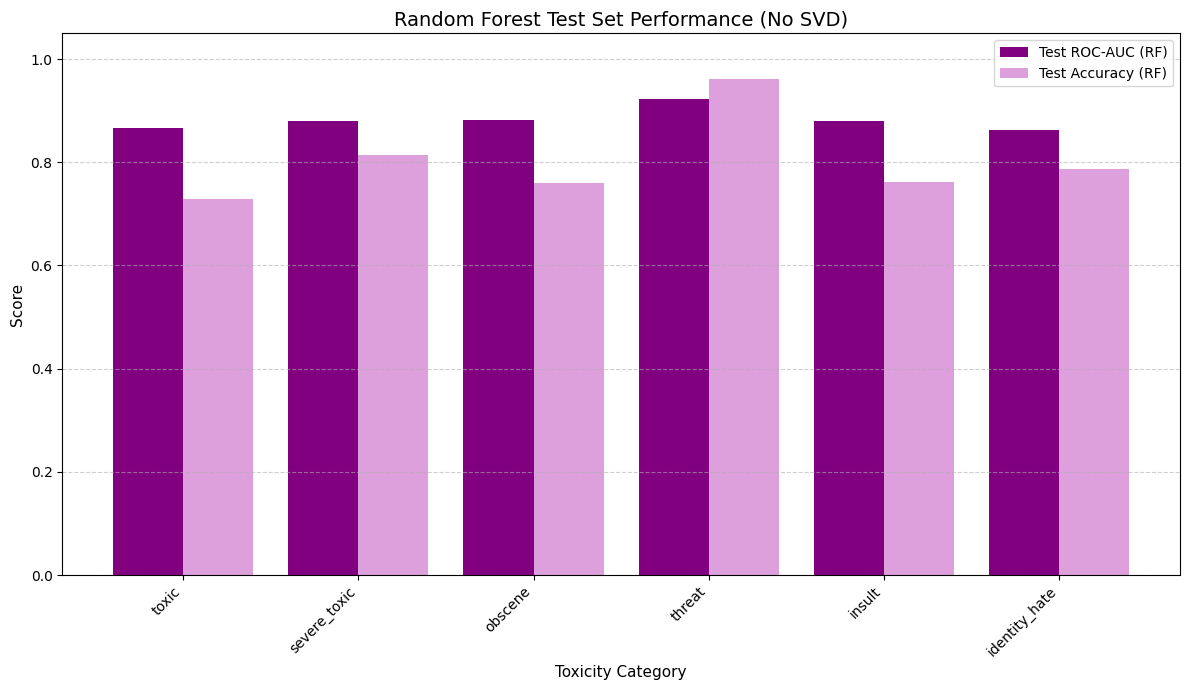


Chart generation for Random Forest finished.


In [ ]:
# --- CELL TO GENERATE PERFORMANCE COMPARISON CHART FOR RANDOM FOREST ---
# Assumes the previous cell ran successfully and created the dictionaries:
#   - test_roc_auc_scores_rf
#   - test_accuracy_scores_rf
# Also assumes 'toxicity_columns' list exists.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

print("\n--- Generating Performance Comparison Chart for Random Forest (No SVD) ---")

# Define directories (optional)
results_dir = 'jigsaw_data/results'
plots_dir = 'jigsaw_data/plots'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Check if score dictionaries exist and contain data
roc_scores_exist_rf = 'test_roc_auc_scores_rf' in locals() and test_roc_auc_scores_rf
acc_scores_exist_rf = 'test_accuracy_scores_rf' in locals() and test_accuracy_scores_rf

if not roc_scores_exist_rf and not acc_scores_exist_rf:
    print("Skipping chart: No valid ROC AUC or Accuracy score dictionaries found.")
else:
    try:
        # Create DataFrame from scores
        summary_data_rf = {'Category': toxicity_columns}
        if roc_scores_exist_rf:
            summary_data_rf['Test_ROC_AUC'] = [test_roc_auc_scores_rf.get(label, np.nan) for label in toxicity_columns]
        if acc_scores_exist_rf:
            summary_data_rf['Test_Accuracy'] = [test_accuracy_scores_rf.get(label, np.nan) for label in toxicity_columns]
        summary_df_rf = pd.DataFrame(summary_data_rf)

        # --- Save Summary Table (using the same path as your previous code) ---
        summary_file_path_rf = os.path.join(results_dir, 'evaluation_summary_rf_nosvd.csv')
        # Check if the dataframe was actually created before saving
        if 'summary_df_rf' in locals() and not summary_df_rf.empty:
             summary_df_rf.to_csv(summary_file_path_rf, index=False, float_format='%.4f')
             print("\nPerformance Summary (Test Set - Random Forest No SVD):")
             # Check if DataFrame has columns with scores before printing
             if 'Test_ROC_AUC' in summary_df_rf.columns or 'Test_Accuracy' in summary_df_rf.columns:
                  print(summary_df_rf.to_string())
             else:
                  print("No test metrics available to display.")
             print(f"\nPerformance summary saved to {summary_file_path_rf}")
        else:
            print("Summary DataFrame is empty or wasn't created. Skipping save.")
        # --------------------------------------------------------

        # Check if there are metrics to plot
        metrics_present = ('Test_ROC_AUC' in summary_df_rf.columns and not summary_df_rf['Test_ROC_AUC'].isnull().all()) or \
                          ('Test_Accuracy' in summary_df_rf.columns and not summary_df_rf['Test_Accuracy'].isnull().all())

        if not metrics_present:
             print("\nSkipping chart generation: No valid scores available after processing.")
        else:
            # --- Plotting ---
            fig_bar_rf, ax_bar_rf = plt.subplots(figsize=(12, 7)) # Use unique figure/axes names
            num_metrics = sum(1 for col in ['Test_ROC_AUC', 'Test_Accuracy'] if col in summary_df_rf.columns)
            bar_width = 0.8 / num_metrics if num_metrics > 0 else 0.8
            index = np.arange(len(toxicity_columns))
            offset = - (num_metrics - 1) * bar_width / 2

            colors = ['purple', 'plum'] # Colors for Random Forest comparison
            metrics_plotted = 0

            # Plot Test ROC AUC if available
            if 'Test_ROC_AUC' in summary_df_rf.columns:
                ax_bar_rf.bar(index + offset + metrics_plotted * bar_width, summary_df_rf['Test_ROC_AUC'].fillna(0), bar_width, label='Test ROC-AUC (RF)', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1

            # Plot Test Accuracy if available
            if 'Test_Accuracy' in summary_df_rf.columns:
                ax_bar_rf.bar(index + offset + metrics_plotted * bar_width, summary_df_rf['Test_Accuracy'].fillna(0), bar_width, label='Test Accuracy (RF)', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1

            # Chart Formatting
            ax_bar_rf.set_xlabel('Toxicity Category', fontsize=11)
            ax_bar_rf.set_ylabel('Score', fontsize=11)
            ax_bar_rf.set_title('Random Forest Test Set Performance (No SVD)', fontsize=14)
            ax_bar_rf.set_xticks(index)
            ax_bar_rf.set_xticklabels(toxicity_columns, rotation=45, ha="right", fontsize=10)
            ax_bar_rf.set_ylim(0, 1.05)
            ax_bar_rf.legend(fontsize=10)
            ax_bar_rf.grid(True, axis='y', linestyle='--', alpha=0.6)
            fig_bar_rf.tight_layout()

            # Save and Show
            chart_save_path_rf = os.path.join(plots_dir, 'performance_comparison_rf_nosvd.png')
            plt.savefig(chart_save_path_rf, dpi=300)
            print(f"\nPerformance comparison chart saved to {chart_save_path_rf}")
            plt.show()
            plt.close(fig_bar_rf) # Close the specific figure
            # ------------------

    except Exception as e:
        print(f"\nError generating performance chart for Random Forest: {e}")
        # Attempt to close the figure if it exists to prevent display issues
        if 'fig_bar_rf' in locals():
            plt.close(fig_bar_rf)

print("\nChart generation for Random Forest finished.")

## With SVD


Loading original data features for SVD...
Data loading complete.

Standardizing dense features...
Dense features standardized.

Combining sparse and dense features (pre-SVD)...
Feature combination complete.
X_train_combined (pre-SVD): Shape = (159571, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>
X_test_combined (pre-SVD): Shape = (153164, 20007), Type = <class 'scipy.sparse._csr.csr_matrix'>

Applying Truncated SVD for dimensionality reduction...
Fitting SVD on training data (n_components=500)...
Transforming test data using fitted SVD...
SVD transformation complete.
X_train_svd (post-SVD): Shape = (159571, 500), Type = <class 'numpy.ndarray'>
X_test_svd (post-SVD): Shape = (153164, 500), Type = <class 'numpy.ndarray'>
SVD Explained Variance Ratio (Top 500): 0.9121
SVD model saved to jigsaw_data/svd_model.pkl

Using Random Forest parameters for SVD data: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'class_weight': 'balanced', 'n_jobs':

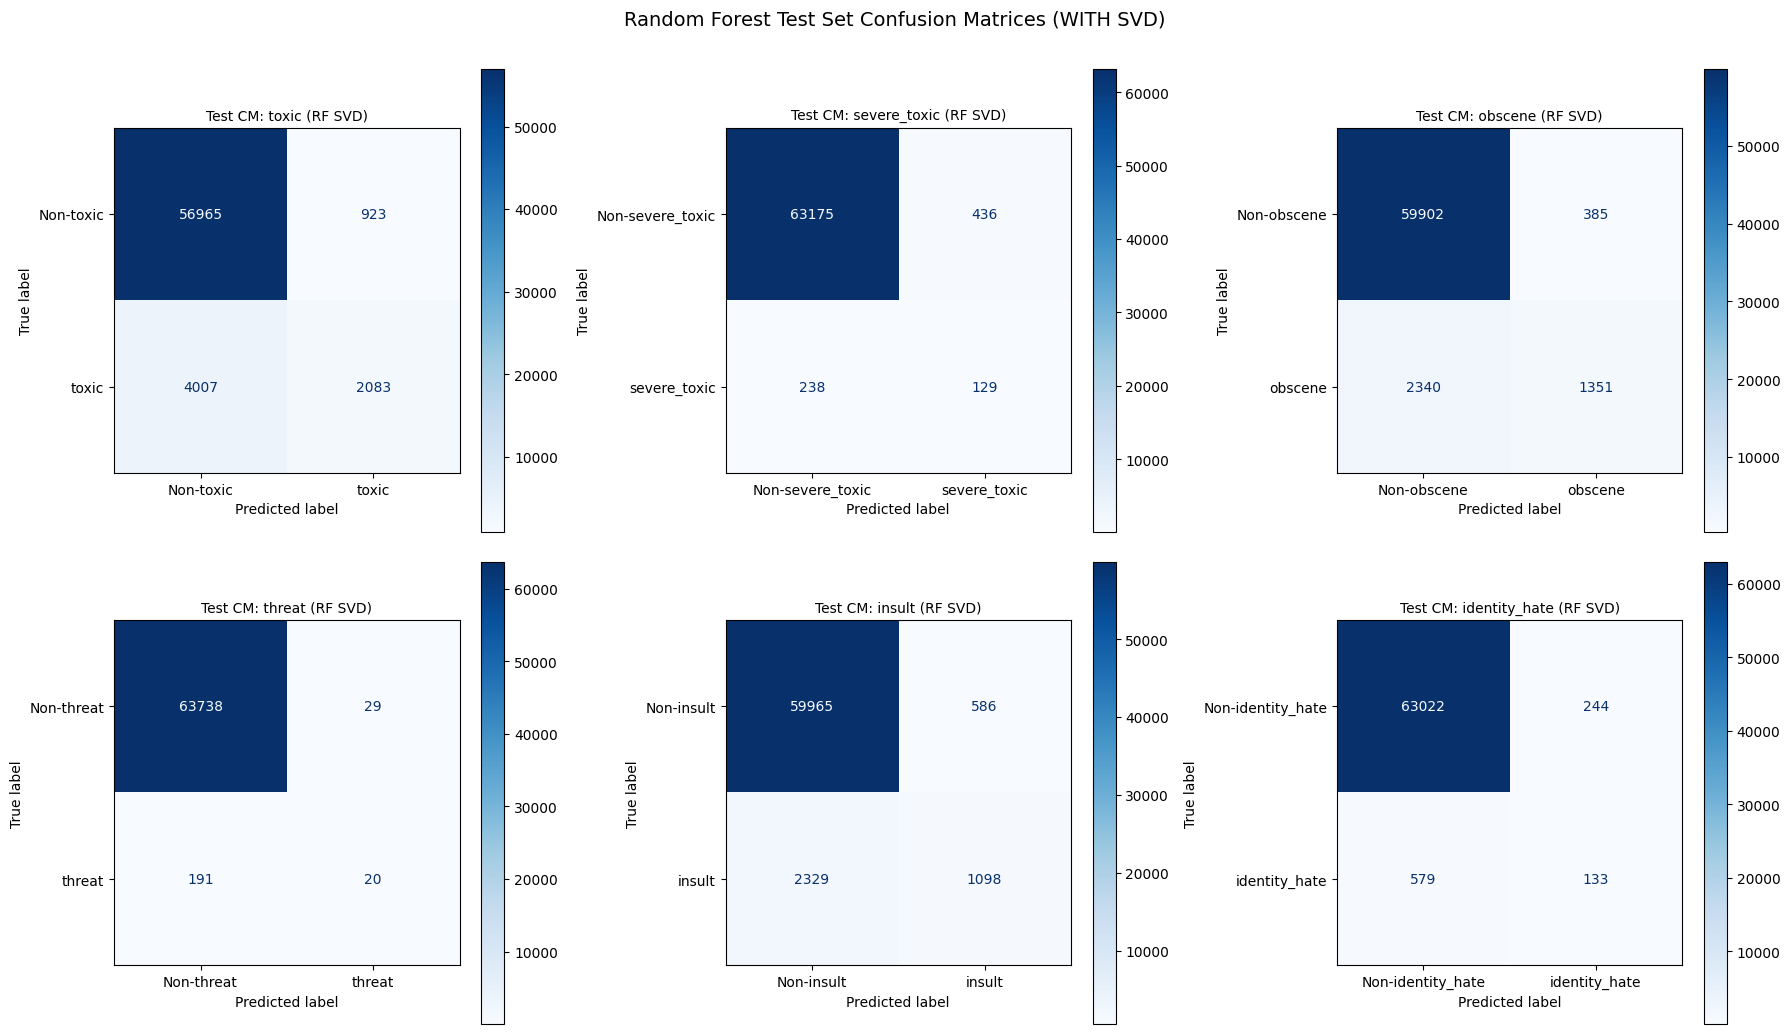

Test confusion matrices (RF SVD) saved to jigsaw_data/plots/test_confusion_matrices_rf_svd.png

--- Summarizing RF SVD Results ---

Performance Summary (Test Set - RF SVD):
        Category  Test_ROC_AUC_RF_SVD  Test_Accuracy_RF_SVD
0          toxic             0.879359              0.922942
1   severe_toxic             0.964713              0.989465
2        obscene             0.914714              0.957407
3         threat             0.927115              0.996561
4         insult             0.909282              0.954437
5  identity_hate             0.904941              0.987136

RF SVD performance summary saved to jigsaw_data/results/performance_summary_rf_svd.csv

Generating RF SVD performance comparison chart...


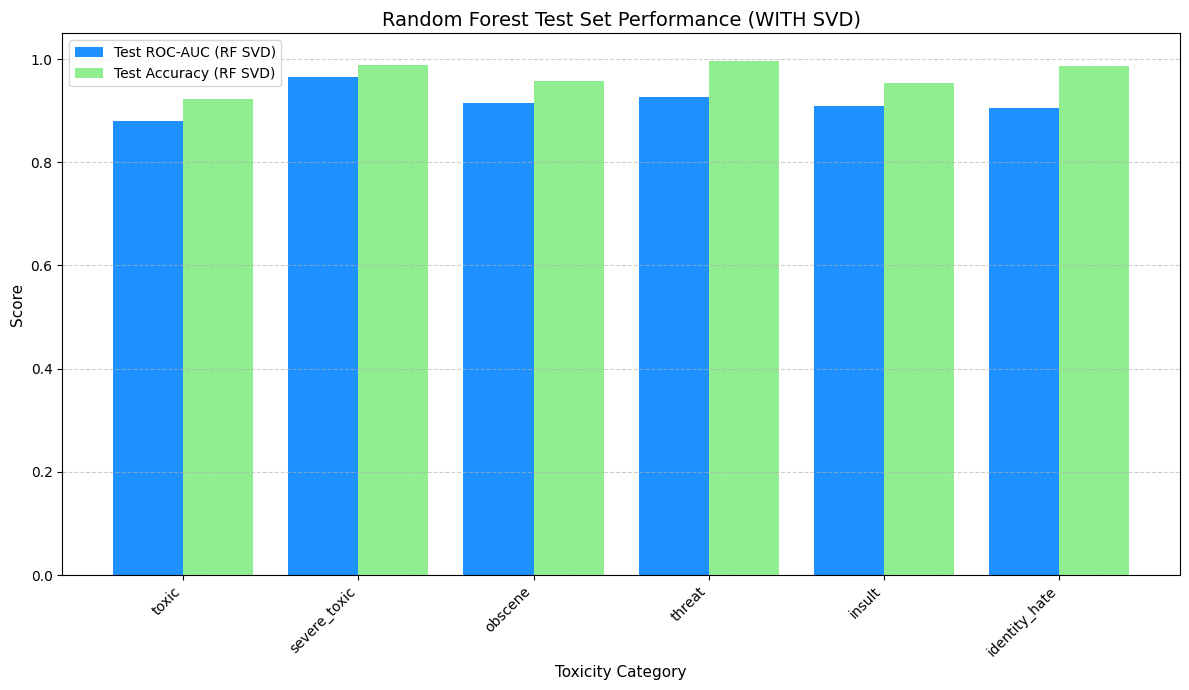

RF SVD performance comparison chart saved to jigsaw_data/plots/performance_comparison_rf_svd.png


In [ ]:
try:
    print("\nLoading original data features for SVD...")
    X_train_tfidf = load_npz('jigsaw_data/X_train_tfidf.npz').tocsr()
    X_test_tfidf = load_npz('jigsaw_data/X_test_tfidf.npz').tocsr()
    train_text_features = pd.read_csv('jigsaw_data/train_text_features.csv', dtype=np.float32)
    test_text_features = pd.read_csv('jigsaw_data/test_text_features.csv', dtype=np.float32)
    y_train = pd.read_csv('jigsaw_data/y_train.csv')
    print("Data loading complete.")

    # --- 4. Standardize and Combine Features ---
    print("\nStandardizing dense features...")
    # Use with_mean=True for consistency with previous RF example, although SVD centers data anyway
    scaler = StandardScaler(with_mean=True)
    train_text_features_scaled = scaler.fit_transform(train_text_features)
    test_text_features_scaled = scaler.transform(test_text_features)
    print("Dense features standardized.")

    print("\nCombining sparse and dense features (pre-SVD)...")
    # Convert scaled dense features to sparse matrix before hstack
    train_text_features_scaled_sparse = csr_matrix(train_text_features_scaled)
    test_text_features_scaled_sparse = csr_matrix(test_text_features_scaled)

    # Combine for SVD input - CSR format is generally good
    X_train_combined = hstack([X_train_tfidf, train_text_features_scaled_sparse], format='csr')
    X_test_combined = hstack([X_test_tfidf, test_text_features_scaled_sparse], format='csr')
    print("Feature combination complete.")

    debug_print("X_train_combined (pre-SVD)", X_train_combined)
    debug_print("X_test_combined (pre-SVD)", X_test_combined)

    # --- 5. Apply SVD ---
    print("\nApplying Truncated SVD for dimensionality reduction...")
    n_components_svd = 500 # Number of SVD components (tune this)
    svd = TruncatedSVD(n_components=n_components_svd, random_state=42)

    print(f"Fitting SVD on training data (n_components={n_components_svd})...")
    # SVD output is a dense NumPy array
    X_train_svd = svd.fit_transform(X_train_combined)
    print("Transforming test data using fitted SVD...")
    X_test_svd = svd.transform(X_test_combined)
    print("SVD transformation complete.")

    debug_print("X_train_svd (post-SVD)", X_train_svd)
    debug_print("X_test_svd (post-SVD)", X_test_svd)
    print(f"SVD Explained Variance Ratio (Top {n_components_svd}): {sum(svd.explained_variance_ratio_):.4f}")

    # Save the SVD model
    svd_save_path = 'jigsaw_data/svd_model.pkl' # Can reuse the same SVD model file
    joblib.dump(svd, svd_save_path, compress=3)
    print(f"SVD model saved to {svd_save_path}")

except Exception as e:
    print(f"Error during data loading/preparation/SVD: {e}")
    raise

# --- 6. Hyperparameters & Training Function Definition ---
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Define Random Forest parameters for SVD data
rf_params_svd = {
    'n_estimators': 150,           # Number of trees (adjust as needed)
    'max_depth': 30,              # Can potentially go deeper with fewer features (tune)
    'min_samples_split': 5,       # Min samples to split a node
    'min_samples_leaf': 3,        # Min samples in a leaf node
    'class_weight': 'balanced',   # Handle class imbalance
    'n_jobs': -1,                 # Use all available CPU cores *within* each model fit
    'random_state': 42,
    'max_features': 'sqrt',       # Or 'log2', or a float like 0.5. 'sqrt' is common.
    # 'verbose': 1 # Uncomment for verbosity during training
}
print(f"\nUsing Random Forest parameters for SVD data: {rf_params_svd}")

# Training function for Random Forest (SVD input)
def train_model_rf_svd(label, X_train_data_svd, y_train_data, params):
    try:
        print(f"Defining training process for '{label}' (RF SVD)...")
        # Class imbalance handled by 'class_weight' in params
        model = RandomForestClassifier(**params)
        print(f"Starting training for '{label}' (RF SVD)...")
        # Fit on the dense SVD data
        model.fit(X_train_data_svd, y_train_data[label])
        print(f"Random Forest model trained for '{label}' successfully (SVD).")
        return model
    except Exception as e:
        print(f"Error training Random Forest model for '{label}' (SVD): {e}")
        return None

# --- 7. Train Models & Save ---
try:
    print("\nStarting parallel training of Random Forest models (WITH SVD)...")
    # Run sequentially outer loop, rely on internal n_jobs=-1 of RF
    # WARNING: Still potentially memory intensive depending on n_estimators/max_depth
    models_rf_svd = Parallel(n_jobs=1)( # ADJUST n_jobs CAREFULLY based on RAM
        delayed(train_model_rf_svd)(label, X_train_svd, y_train, rf_params_svd) for label in toxicity_columns
    )
    failed_models = [toxicity_columns[i] for i, m in enumerate(models_rf_svd) if m is None]
    if failed_models: print(f"\nWarning: Training failed for SVD models: {failed_models}")
    else: print("\nAll Random Forest models (SVD) trained successfully.")
except Exception as e:
    print(f"\nError during parallel Random Forest training execution (SVD): {e}")
    models_rf_svd = [None] * len(toxicity_columns)

# Create dictionary of successfully trained models
models_trained_dict_svd = {label: model for label, model in zip(toxicity_columns, models_rf_svd) if model is not None}

if models_trained_dict_svd:
    try:
        save_path = 'jigsaw_data/rf_models_dict_svd.pkl' # Updated filename
        print(f"\nSaving {len(models_trained_dict_svd)} successfully trained models to {save_path}...")
        joblib.dump(models_trained_dict_svd, save_path, compress=3)
        print("SVD models (RF) saved successfully.")
    except Exception as e:
        print(f"\nError saving Random Forest models (SVD): {e}")
else:
    print("\nNo SVD models (RF) trained successfully, skipping saving.")

# --- 8. Test Set Evaluation (Metrics & Confusion Matrices) ---
test_roc_auc_scores_rf_svd = {}   # Renamed
test_accuracy_scores_rf_svd = {}  # Renamed
test_predictions_rf_svd = {}      # Renamed

try:
    print("\n--- Starting Test Set Evaluation (RF SVD Models) ---")
    y_test_path = 'jigsaw_data/y_test.csv'
    test_path = 'jigsaw_data/test.csv' # Need the original test IDs
    print(f"Attempting to load test labels from: {y_test_path}")
    print(f"Attempting to load test IDs from: {test_path}")

    if not os.path.exists(y_test_path):
        raise FileNotFoundError(f"{y_test_path} not found. Create it from test_labels.csv.")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"{test_path} not found. Ensure it was unzipped.")

    y_test = pd.read_csv(y_test_path)
    test_ids_df = pd.read_csv(test_path, usecols=['id'])
    print(f"Test labels loaded. Shape: {y_test.shape}")
    print(f"Test IDs loaded. Shape: {test_ids_df.shape}")

    # Generate Test Predictions using SVD features
    print("\nGenerating predictions on the SVD test set (RF)...")
    y_test_pred_proba_rf_svd_full = np.zeros((X_test_svd.shape[0], len(toxicity_columns)))
    y_test_pred_rf_svd_full = np.zeros((X_test_svd.shape[0], len(toxicity_columns)), dtype=int)

    for i, label in enumerate(toxicity_columns):
        model = models_trained_dict_svd.get(label) # Use RF SVD models
        if model:
            print(f"  Predicting for '{label}' (RF SVD)...")
            # Predict on the dense X_test_svd
            pred_proba = model.predict_proba(X_test_svd)[:, 1]
            pred_binary = (pred_proba >= 0.5).astype(int)
            y_test_pred_proba_rf_svd_full[:, i] = pred_proba
            y_test_pred_rf_svd_full[:, i] = pred_binary
        else:
            print(f"  Skipping prediction for '{label}' (RF SVD) - model not trained.")
            y_test_pred_proba_rf_svd_full[:, i] = np.nan
            y_test_pred_rf_svd_full[:, i] = -1

    # Align Predictions with Scored Labels (using RF SVD predictions)
    print("\nAligning RF SVD predictions with scored test labels...")
    proba_cols_rf_svd = [f'{col}_proba_rf_svd' for col in toxicity_columns] # Renamed cols
    predictions_df_proba_full_rf_svd = pd.DataFrame(y_test_pred_proba_rf_svd_full, columns=proba_cols_rf_svd)
    predictions_df_proba_full_rf_svd['id'] = test_ids_df['id']

    pred_cols_rf_svd = [f'{col}_pred_rf_svd' for col in toxicity_columns] # Renamed cols
    predictions_df_bin_full_rf_svd = pd.DataFrame(y_test_pred_rf_svd_full, columns=pred_cols_rf_svd)
    predictions_df_bin_full_rf_svd['id'] = test_ids_df['id']

    # Merge with ground truth
    eval_df_proba_rf_svd = pd.merge(y_test, predictions_df_proba_full_rf_svd, on='id', how='inner')
    eval_df_bin_rf_svd = pd.merge(y_test, predictions_df_bin_full_rf_svd, on='id', how='inner')
    print(f"Aligned RF SVD data for evaluation. Proba shape: {eval_df_proba_rf_svd.shape}, Bin shape: {eval_df_bin_rf_svd.shape}")

    # Save Aligned Probabilities
    prob_save_path_aligned_rf_svd = 'jigsaw_data/test_predictions_rf_svd_aligned_probas.csv' # Renamed file
    eval_df_proba_rf_svd[['id'] + proba_cols_rf_svd].to_csv(prob_save_path_aligned_rf_svd, index=False, float_format='%.6f')
    print(f"\nAligned RF SVD test predictions (probabilities) saved to {prob_save_path_aligned_rf_svd}")

    # Calculate Test Metrics on Aligned RF SVD Data
    print("\nCalculating Test Metrics (RF SVD Models)...")
    for label in toxicity_columns:
        true_label_col = label
        proba_label_col = f'{label}_proba_rf_svd' # Use RF SVD col names
        pred_label_col = f'{label}_pred_rf_svd'   # Use RF SVD col names

        if label in models_trained_dict_svd and proba_label_col in eval_df_proba_rf_svd.columns and pred_label_col in eval_df_bin_rf_svd.columns:
            y_true = eval_df_proba_rf_svd[true_label_col] # Ground truth from y_test merge
            y_pred_proba = eval_df_proba_rf_svd[proba_label_col]
            y_pred_binary = eval_df_bin_rf_svd[pred_label_col]
            test_predictions_rf_svd[label] = y_pred_binary # Store for CM

            # Calculate metrics, handle single class case for AUC
            if len(np.unique(y_true)) > 1:
                 score_roc = roc_auc_score(y_true, y_pred_proba)
            else:
                 print(f"  '{label}': ROC AUC undefined (only one class in y_true).")
                 score_roc = np.nan
            score_acc = accuracy_score(y_true, y_pred_binary)

            test_roc_auc_scores_rf_svd[label] = score_roc # Store in RF SVD dict
            test_accuracy_scores_rf_svd[label] = score_acc # Store in RF SVD dict
            print(f"  '{label}' (RF SVD): Test ROC-AUC = {score_roc:.4f}, Test Accuracy = {score_acc:.4f}")
        else:
            print(f"  '{label}' (RF SVD): Skipping metrics (model missing or prediction columns not found).")
            test_roc_auc_scores_rf_svd[label] = np.nan
            test_accuracy_scores_rf_svd[label] = np.nan

    # Generate Confusion Matrices (RF SVD Models)
    print("\nGenerating confusion matrices for the test set (RF SVD Models)...")
    fig_rf_svd, axes_rf_svd = plt.subplots(2, 3, figsize=(18, 11)) # New figure/axes
    axes_rf_svd = axes_rf_svd.ravel()
    plot_generated_rf_svd = False

    for idx, label in enumerate(toxicity_columns):
         # Check if model exists and predictions were made and stored
         if label in models_trained_dict_svd and label in test_predictions_rf_svd and not eval_df_bin_rf_svd[f'{label}_pred_rf_svd'].isnull().any():
             y_true = eval_df_bin_rf_svd[label]
             y_pred = test_predictions_rf_svd[label]
             cm = confusion_matrix(y_true, y_pred)
             disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Non-{label}', label])
             disp.plot(ax=axes_rf_svd[idx], cmap='Blues', values_format='d') # RF plot uses Blues
             axes_rf_svd[idx].set_title(f"Test CM: {label} (RF SVD)", fontsize=10)
             plot_generated_rf_svd = True
         else:
            # Handle cases where model failed or predictions are missing
            axes_rf_svd[idx].text(0.5, 0.5, 'Model/Data Missing', ha='center', va='center', fontsize=9)
            axes_rf_svd[idx].set_title(f'Test CM: {label} (RF SVD)', fontsize=10)
            axes_rf_svd[idx].set_xticks([])
            axes_rf_svd[idx].set_yticks([])


    if plot_generated_rf_svd:
        plt.suptitle("Random Forest Test Set Confusion Matrices (WITH SVD)", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        cm_save_path_rf_svd = 'jigsaw_data/plots/test_confusion_matrices_rf_svd.png' # Renamed file
        plt.savefig(cm_save_path_rf_svd, dpi=300); plt.show(); plt.close()
        print(f"Test confusion matrices (RF SVD) saved to {cm_save_path_rf_svd}")
    else:
        print("No RF SVD confusion matrices generated (likely due to model failures or missing data).")
        plt.close(fig_rf_svd) # Close the empty figure

except FileNotFoundError as e:
    print(f"\n{e}")
    print("Skipping ALL Test Set Evaluation & Plotting for RF SVD models.")
    test_roc_auc_scores_rf_svd = None
    test_accuracy_scores_rf_svd = None
except Exception as e:
    print(f"\nAn error occurred during RF SVD test set evaluation: {e}")
    # Preserve any partial results if they exist
    test_roc_auc_scores_rf_svd = test_roc_auc_scores_rf_svd if 'test_roc_auc_scores_rf_svd' in locals() and test_roc_auc_scores_rf_svd else None
    test_accuracy_scores_rf_svd = test_accuracy_scores_rf_svd if 'test_accuracy_scores_rf_svd' in locals() and test_accuracy_scores_rf_svd else None


# --- 9. Results Summary & Comparison Chart (RF SVD Models) ---
try:
    print("\n--- Summarizing RF SVD Results ---")
    # Check if the results dictionaries exist and are not None
    if 'test_roc_auc_scores_rf_svd' not in locals() or test_roc_auc_scores_rf_svd is None:
         print("RF SVD test results unavailable. Cannot generate summary or chart.")
    else:
        # Prepare data for summary DataFrame
        summary_data_rf_svd = {'Category': toxicity_columns}
        if test_roc_auc_scores_rf_svd: summary_data_rf_svd['Test_ROC_AUC_RF_SVD'] = [test_roc_auc_scores_rf_svd.get(label, np.nan) for label in toxicity_columns]
        if test_accuracy_scores_rf_svd: summary_data_rf_svd['Test_Accuracy_RF_SVD'] = [test_accuracy_scores_rf_svd.get(label, np.nan) for label in toxicity_columns]

        summary_df_rf_svd = pd.DataFrame(summary_data_rf_svd)
        summary_file_path_rf_svd = 'jigsaw_data/results/performance_summary_rf_svd.csv' # Renamed file
        summary_df_rf_svd.to_csv(summary_file_path_rf_svd, index=False, float_format='%.4f')

        print("\nPerformance Summary (Test Set - RF SVD):")
        # Check if there are any metrics columns to print
        metric_cols_rf_svd = [col for col in summary_df_rf_svd.columns if 'Test_' in col]
        if metric_cols_rf_svd: print(summary_df_rf_svd.to_string())
        else: print("No RF SVD test metrics available to display.")
        print(f"\nRF SVD performance summary saved to {summary_file_path_rf_svd}")

        # Generate Comparison Bar Chart only if metrics were calculated
        if test_roc_auc_scores_rf_svd and test_accuracy_scores_rf_svd and not summary_df_rf_svd[metric_cols_rf_svd].isnull().all().all():
            print("\nGenerating RF SVD performance comparison chart...")
            plt.figure(figsize=(12, 7))
            num_metrics = len(metric_cols_rf_svd)
            bar_width = 0.8 / num_metrics if num_metrics > 0 else 0.8
            index = np.arange(len(toxicity_columns))
            # Calculate offset to center bars
            offset = - (num_metrics - 1) * bar_width / 2 if num_metrics > 1 else 0
            colors = ['dodgerblue', 'lightgreen'] # Colors for RF SVD chart
            metrics_plotted = 0

            if 'Test_ROC_AUC_RF_SVD' in summary_df_rf_svd.columns:
                plt.bar(index + offset + metrics_plotted * bar_width, summary_df_rf_svd['Test_ROC_AUC_RF_SVD'].fillna(0), bar_width, label='Test ROC-AUC (RF SVD)', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1
            if 'Test_Accuracy_RF_SVD' in summary_df_rf_svd.columns:
                plt.bar(index + offset + metrics_plotted * bar_width, summary_df_rf_svd['Test_Accuracy_RF_SVD'].fillna(0), bar_width, label='Test Accuracy (RF SVD)', color=colors[metrics_plotted % len(colors)])
                metrics_plotted += 1

            plt.xlabel('Toxicity Category', fontsize=11)
            plt.ylabel('Score', fontsize=11)
            plt.title('Random Forest Test Set Performance (WITH SVD)', fontsize=14)
            plt.xticks(index, toxicity_columns, rotation=45, ha="right", fontsize=10)
            plt.ylim(0, 1.05)
            plt.legend(fontsize=10)
            plt.grid(True, axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            chart_path_rf_svd = 'jigsaw_data/plots/performance_comparison_rf_svd.png' # Renamed file
            plt.savefig(chart_path_rf_svd, dpi=300); plt.show(); plt.close()
            print(f"RF SVD performance comparison chart saved to {chart_path_rf_svd}")
        else:
            print("\nSkipping RF SVD performance comparison chart (no valid test metrics).")

# Handle potential NameError if evaluation failed early
except NameError as e:
    print(f"Evaluation results dictionary likely not created due to earlier error: {e}. Skipping summary and chart for RF SVD.")
except Exception as e:
    print(f"Error summarizing RF SVD results or plotting: {e}")

## Compare SVD vs Without SVD

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("--- Starting Comparison of SVD vs. No SVD Random Forest Models ---")

# Define file paths for the results
results_dir = 'jigsaw_data/results'
plots_dir = 'jigsaw_data/plots'
# *** Filenames updated for Random Forest results ***
nosvd_results_path = os.path.join(results_dir, 'performance_summary_rf_nosvd.csv')
svd_results_path = os.path.join(results_dir, 'performance_summary_rf_svd.csv')
# *** Output filenames updated for Random Forest comparison ***
comparison_output_path = os.path.join(results_dir, 'comparison_summary_rf_svd_vs_nosvd.csv')
comparison_chart_path = os.path.join(plots_dir, 'comparison_chart_rf_svd_vs_nosvd.png')

# --- 1. Load Performance Data ---
df_comparison = None # Initialize to handle potential loading errors
try:
    print(f"Loading No-SVD results from: {nosvd_results_path}")
    if not os.path.exists(nosvd_results_path):
        raise FileNotFoundError(f"File not found: {nosvd_results_path}. Please run the 'Random Forest No SVD' training/evaluation script.")
    df_nosvd = pd.read_csv(nosvd_results_path)
    # *** Rename columns for clarity and RF specificity ***
    df_nosvd = df_nosvd.rename(columns={
        'AUC': 'Test_ROC_AUC_RF_NoSVD',       # Assuming 'AUC' from the RF script
        'Accuracy': 'Test_Accuracy_RF_NoSVD', # Assuming 'Accuracy' from the RF script
        'Label': 'Category'                  # Assuming 'Label' from the RF script
    })
    # Keep only relevant columns for comparison
    df_nosvd = df_nosvd[['Category', 'Test_ROC_AUC_RF_NoSVD', 'Test_Accuracy_RF_NoSVD']]


    print(f"\nLoading SVD results from: {svd_results_path}")
    if not os.path.exists(svd_results_path):
         raise FileNotFoundError(f"File not found: {svd_results_path}. Please run the 'Random Forest WITH SVD' training/evaluation script.")
    df_svd = pd.read_csv(svd_results_path)
    # *** Rename columns for clarity and RF specificity ***
    # Column names here are expected to match the output of the RF SVD script
    df_svd = df_svd.rename(columns={
        'Test_ROC_AUC_RF_SVD': 'Test_ROC_AUC_RF_SVD',
        'Test_Accuracy_RF_SVD': 'Test_Accuracy_RF_SVD',
        # 'Category' should already be correct if it came from the RF SVD script
    })
     # Keep only relevant columns for comparison
    df_svd = df_svd[['Category', 'Test_ROC_AUC_RF_SVD', 'Test_Accuracy_RF_SVD']]


    print("\nSuccessfully loaded performance data.")

except FileNotFoundError as e:
    print(f"\nError loading results files: {e}")
    print("Cannot proceed with comparison. Ensure both Random Forest blocks were run successfully including test evaluation.")
    # df_comparison remains None
except KeyError as e:
    print(f"\nError: Column {e} not found in one of the loaded CSV files.")
    print("Please check the column names in the generated performance summary CSVs:")
    print(f" - Expected in {nosvd_results_path}: 'Category' (or 'Label'), 'AUC', 'Accuracy'")
    print(f" - Expected in {svd_results_path}: 'Category', 'Test_ROC_AUC_RF_SVD', 'Test_Accuracy_RF_SVD'")
    print("Cannot proceed with comparison.")
    # df_comparison remains None
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    # df_comparison remains None

# --- 2. Merge and Display Comparison Table ---
# Check if both dataframes were loaded successfully
if 'df_nosvd' in locals() and isinstance(df_nosvd, pd.DataFrame) and \
   'df_svd' in locals() and isinstance(df_svd, pd.DataFrame):
    try:
        print("\nMerging results for comparison...")
        # Use outer merge to keep all categories even if one model failed for a specific category
        df_comparison = pd.merge(df_nosvd, df_svd, on='Category', how='outer')

        print("\n--- Random Forest Performance Comparison Table ---")
        print(df_comparison.to_string(float_format='%.4f')) # Display full table

        # Save the comparison table
        df_comparison.to_csv(comparison_output_path, index=False, float_format='%.4f')
        print(f"\nComparison summary saved to: {comparison_output_path}")

    except Exception as e:
        print(f"Error during merging or saving comparison table: {e}")
        df_comparison = None # Prevent chart generation if merge fails

# --- 3. Generate Comparison Bar Chart ---
if df_comparison is not None and not df_comparison.empty: # Proceed only if merge was successful
    try:
        print("\nGenerating comparison bar chart...")
        plt.figure(figsize=(14, 8)) # Wider figure for grouped bars

        categories = df_comparison['Category'].tolist()
        n_categories = len(categories)
        index = np.arange(n_categories)

        # *** Define metrics to plot and their labels/colors for RF ***
        metrics = {
            'RF_NoSVD_AUC': ('Test_ROC_AUC_RF_NoSVD', 'RF No SVD ROC-AUC', 'dodgerblue'),
            'RF_SVD_AUC': ('Test_ROC_AUC_RF_SVD', 'RF SVD ROC-AUC', 'darkorange'),
            'RF_NoSVD_Acc': ('Test_Accuracy_RF_NoSVD', 'RF No SVD Accuracy', 'lightskyblue'),
            'RF_SVD_Acc': ('Test_Accuracy_RF_SVD', 'RF SVD Accuracy', 'sandybrown'),
        }

        # Check which metrics are actually present in the dataframe
        metrics_to_plot = {k: v for k, v in metrics.items() if v[0] in df_comparison.columns}

        if not metrics_to_plot:
            print("No valid metric columns found in the comparison DataFrame. Skipping chart generation.")
        else:
            num_metric_bars = len(metrics_to_plot)
            bar_width = 0.8 / num_metric_bars if num_metric_bars > 0 else 0.8 # Adjust width based on # bars

            # Calculate offsets for grouped bars
            offsets = np.linspace(-bar_width * (num_metric_bars - 1) / 2,
                                  bar_width * (num_metric_bars - 1) / 2,
                                  num_metric_bars) if num_metric_bars > 1 else [0]


            # Plot bars
            plot_successful = False
            for i, (metric_key, (col_name, label, color)) in enumerate(metrics_to_plot.items()):
                # Fill NaN with 0 for plotting, but NaNs will be visible in the table
                plt.bar(index + offsets[i], df_comparison[col_name].fillna(0), bar_width, label=label, color=color)
                plot_successful = True

            if plot_successful:
                plt.xlabel('Toxicity Category', fontsize=12)
                plt.ylabel('Score', fontsize=12)
                # *** Updated Title ***
                plt.title('Random Forest Performance Comparison: With SVD vs. Without SVD (Test Set)', fontsize=15)
                plt.xticks(index, categories, rotation=45, ha="right", fontsize=10)
                plt.ylim(0, 1.1) # Y-axis from 0 to 1.1 for better visibility
                plt.legend(fontsize=10, loc='best') # Adjusted legend location
                plt.grid(True, axis='y', linestyle='--', alpha=0.6)
                plt.tight_layout()

                # Save and show plot
                plt.savefig(comparison_chart_path, dpi=300)
                plt.show()
                plt.close()
                print(f"Comparison chart saved to: {comparison_chart_path}")
            else:
                 # This case should be caught earlier, but added for safety
                 print("No data plotted. Skipping chart saving and display.")


    except Exception as e:
        print(f"Error generating comparison chart: {e}")
        # Attempt to close any open plot
        try:
            plt.close()
        except:
            pass
elif df_comparison is None:
     print("\nSkipping chart generation because data loading or merging failed.")
elif df_comparison.empty:
     print("\nSkipping chart generation because the comparison DataFrame is empty.")

--- Starting Comparison of SVD vs. No SVD Random Forest Models ---
Loading No-SVD results from: jigsaw_data/results/performance_summary_rf_nosvd.csv

Error loading results files: File not found: jigsaw_data/results/performance_summary_rf_nosvd.csv. Please run the 'Random Forest No SVD' training/evaluation script.
Cannot proceed with comparison. Ensure both Random Forest blocks were run successfully including test evaluation.

Merging results for comparison...

--- Random Forest Performance Comparison Table ---
        Category  Test_ROC_AUC_NoSVD  Test_Accuracy_NoSVD  Test_ROC_AUC_SVD  Test_Accuracy_SVD
0  identity_hate              0.9514               0.9498            0.9274             0.9651
1         insult              0.9486               0.9068            0.9313             0.9108
2        obscene              0.9592               0.9293            0.9373             0.9219
3   severe_toxic              0.9719               0.9587            0.9688             0.9768
4        

<Figure size 1400x800 with 0 Axes>